# Citation Intent Classification - SciBERT_CASED

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## A survey of methodologies for Citation Intent Classification
#### Brief description of the task
The aim of this project is to walk through the building of a Machine Learning model capable of classifying citation intents in scientific papers.

I will make use of a Pre-trained language model (PLM) to build a meaningful comparison between some of the different techniques that could be used to produce the final outcome, in order to investigate which works better for the task.

The techniques I aim to compare are:
- The fine-tuning of a PLM;
- The construction of an ensemble multi-class classifier based on binary classifiers.

#### Requirements

Download additional libraries and modules.

In [ ]:
!pip install transformers datasets scikit-learn accelerate ray[tune]==2.9.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.0 MB/s eta 0:00:00


Below you will find all the necessary imports for the project, together with the version of the main libraries.

In [ ]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import missingno as msno
import seaborn as sns
import sklearn
import tensorflow as tf
import datasets
from datasets import load_dataset
import random
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

print(f"Python Version: {sys.version}\n\nMain libraries of the project:\n")
print(f"- NumPy Version: {np.__version__}")
print(f"- Pandas Version: {pd.__version__}")
print(f"- Matplotlib Version: {mpl.__version__}")
print(f"- Seaborn Version: {sns.__version__}")
print(f"- Scikit-learn Version: {sklearn.__version__}")
print(f"- TensorFlow Version: {tf.__version__}")
print(f"- PyTorch Version: {torch.__version__}")
print(f"- Datasets Version: {datasets.__version__}")
print(f"- Transformers Version: {transformers.__version__}")

Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

Main libraries of the project:

- NumPy Version: 1.23.5
- Pandas Version: 1.5.3
- Matplotlib Version: 3.7.1
- Seaborn Version: 0.13.1
- Scikit-learn Version: 1.2.2
- TensorFlow Version: 2.15.0
- PyTorch Version: 2.1.0+cu121
- Datasets Version: 2.16.1
- Transformers Version: 4.35.2


Retrieve GPU device for PyTorch based operations

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Dataset loading and inspection

Below, I download the SciCite dataset directly from the datasets library provided by Huggingface. The dataset will be stored inside a dict-like object yet splitted, consistently with the benchmark dataset, into train, validation and test sets.

In [ ]:
dataset = load_dataset("allenai/scicite", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8194 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/916 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1859 [00:00<?, ? examples/s]

Here I print some information about the dataset we are using. Mainly, we get a brief description of it, as well as the link to access the original dataset.

In [ ]:
print(dataset['train'].description, '\n\n')
print(dataset['train'].homepage)


This is a dataset for classifying citation intents in academic papers.
The main citation intent label for each Json object is specified with the label
key while the citation context is specified in with a context key. Example:
{
 'string': 'In chacma baboons, male-infant relationships can be linked to both
    formation of friendships and paternity success [30,31].'
 'sectionName': 'Introduction',
 'label': 'background',
 'citingPaperId': '7a6b2d4b405439',
 'citedPaperId': '9d1abadc55b5e0',
 ...
 }
You may obtain the full information about the paper using the provided paper ids
with the Semantic Scholar API (https://api.semanticscholar.org/).
The labels are:
Method, Background, Result
 


https://github.com/allenai/scicite


Let's start inspecting our dataset.

At first, we print the shape of each one of the three splits.

In [ ]:
print(dataset.shape)

{'train': (8194, 14), 'validation': (916, 14), 'test': (1859, 14)}


Now, let's look at the specific columns of each one the splits.

For simplicty, I will work around the train split for inspection purposes, but first asserting that all the splits have the same columns.

In [ ]:
assert(dataset['train'].column_names==dataset['validation'].column_names==dataset['test'].column_names)
print(dataset['train'].column_names)

['string', 'sectionName', 'label', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id']


Let's now inspect the types of data contained in these columns.

In [ ]:
dataset['train'].features

{'string': Value(dtype='string', id=None),
 'sectionName': Value(dtype='string', id=None),
 'label': ClassLabel(names=['method', 'background', 'result'], id=None),
 'citingPaperId': Value(dtype='string', id=None),
 'citedPaperId': Value(dtype='string', id=None),
 'excerpt_index': Value(dtype='int32', id=None),
 'isKeyCitation': Value(dtype='bool', id=None),
 'label2': ClassLabel(names=['supportive', 'not_supportive', 'cant_determine', 'none'], id=None),
 'citeEnd': Value(dtype='int64', id=None),
 'citeStart': Value(dtype='int64', id=None),
 'source': ClassLabel(names=['properNoun', 'andPhrase', 'acronym', 'etAlPhrase', 'explicit', 'acronymParen', 'nan'], id=None),
 'label_confidence': Value(dtype='float32', id=None),
 'label2_confidence': Value(dtype='float32', id=None),
 'id': Value(dtype='string', id=None)}

The dataset has been thought to represent a real distribution of citation intents in the average research paper. Thus, it presents an higly imbalanced distribution of labels. </br>To better see this, let's visualize the distribution for each of the splits.

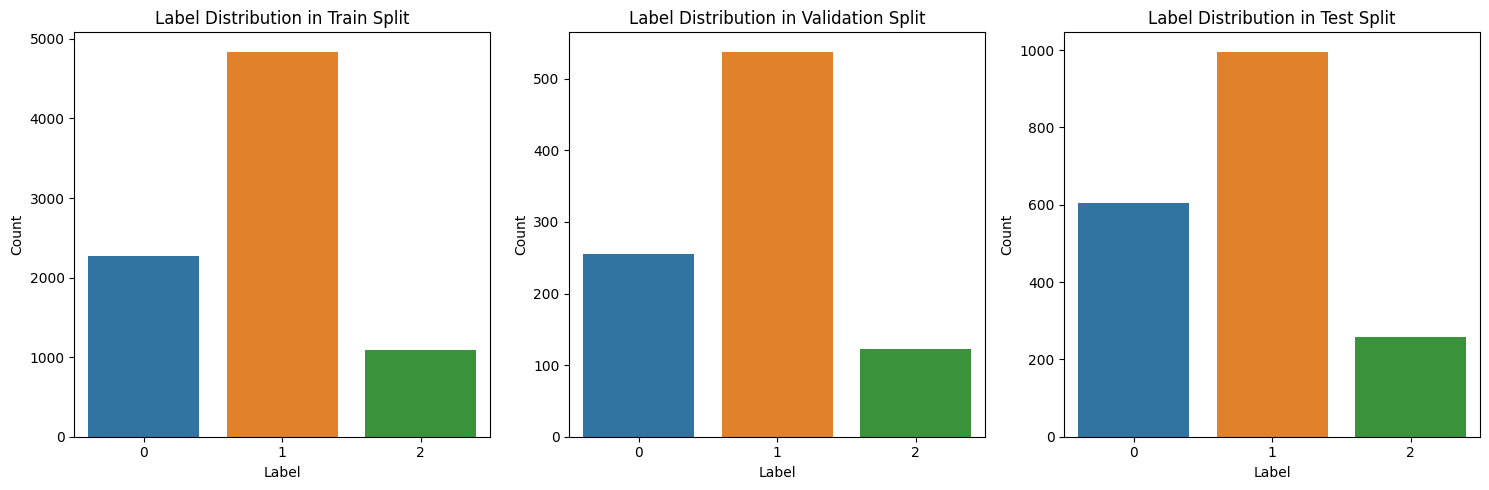

In [ ]:
splits = ['train', 'validation', 'test']

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, split in enumerate(splits):
    labels = [example['label'] for example in dataset[split]]
    # Here I count the occurrence of each label thanks to counter, imported from collections
    label_counts = Counter(labels)

    df = pd.DataFrame({'label': list(label_counts.keys()), 'count': list(label_counts.values())})
    sns.barplot(x='label', y='count', data=df, ax=axs[i])

    axs[i].set_title(f'Label Distribution in {split.capitalize()} Split')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Count')

# Below is to adjust padding
plt.tight_layout()
plt.show()

As stated above, the distribution of labels is consistent within the splits.

Now, let's inspect the missing values from the dataset.

According to how the dataset has been created, <b>NaN</b> values are not present in the huggingface version. Thus, in order to have a grasp of which columns present missing values, and how many of them we have to deal with, we should made a simple conversion from "", or " ", to np.nan.</br>Then, we plot a mtrix like representation of missing values for each of the splits.

Missing values in Train: 587
Missing values in Train Split:
Missing values in Validation: 71
Missing values in Validation Split:
Missing values in Test: 66
Missing values in Test Split:


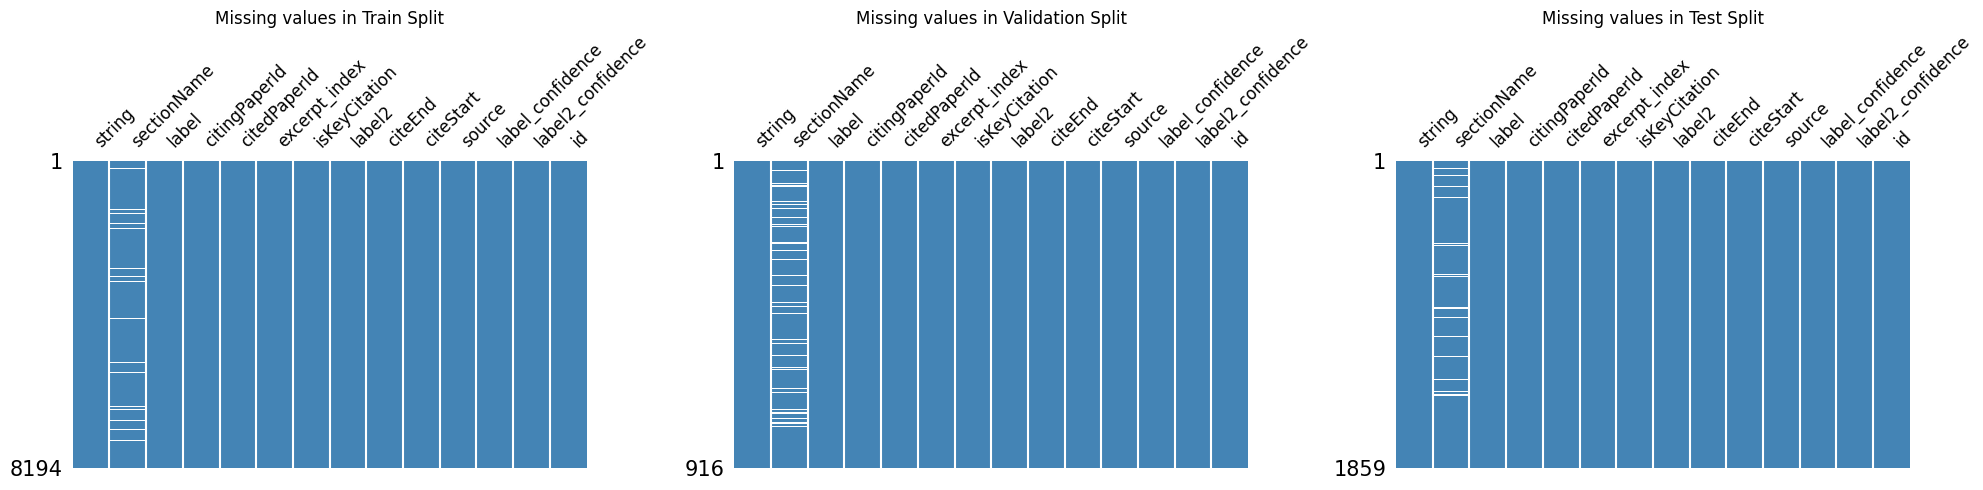

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, split in enumerate(splits):
    df = pd.DataFrame(dataset[split])
    # Conversion of empty cells into np.nan
    df.replace({"": np.nan, " ": np.nan}, inplace=True)
    # Find missing values
    missing_values = df.isna().sum().sum()
    print(f"Missing values in {split.capitalize()}: {missing_values}")
    # Visualizing the missing values with missingno library
    print(f"Missing values in {split.capitalize()} Split:")
    msno.matrix(df, ax=axs[i], sparkline=False, fontsize=12, color=(0.27, 0.52, 0.71))
    axs[i].set_title(f'Missing values in {split.capitalize()} Split')

plt.tight_layout()
plt.show()

From this dataset, we are mainly interested in seeing how to deal with string, sectionName, and label columns. All the other information can be discarded because are not useful for the task.

## 2. Brief discussion: PLMs and SOTA

The Citation Intent Classification task has been studied intensively, and the current state of the art is a Macro-F1 score of 88.93 obtained with an XLNet based model ([SOTA page](https://paperswithcode.com/sota/citation-intent-classification-on-scicite)). Other methodologies, like embedding based analyses, together with LSTM based approaches, show a much lower performance.

As you can imagine, the task can be tackled from very different perspectives, we could use prompt-tuning, fine-tuning, zero-shot, few-shot, sentence-transformer based similarity, and so on... But, for the aim of this project, I'd like to go deeper on the scores we can obtain by using an ensemble based approach, and see whether or not it will outperform the scores obtained with task specific fine-tuning. Additionally, I'd like to investigate the impact that a mix of feature and prompt engineering, correctly applied to these PLMs could have.

In order to move our first steps into the task, we must first decide which model we would like to use. To make such decision, I have a list of candidate PLMs.

The models I will take into consideration are the following:
- <b>SciBERT</b>: A BERT based model trained on a corpus of scientific texts. Its main advantages is its good understanding of the scientific domain and the SciVocab, a newly designed vocabulary containing a great number of terms from the scientific literature - [Reference Paper](https://arxiv.org/abs/1903.10676);
- <b>XLNet</b>: A model presenting an evolution of the way in which LMs are trained for Language Understanding tasks. As said before, it is also the current base-model of SOTA results for this task - [Reference Paper](https://arxiv.org/abs/1906.08237);
- <b>Galactica</b>: A big open source science based language model from META. It is a controversial model for the results it has obtained in text generation tasks, but it is now back on track - [Reference Paper](https://arxiv.org/abs/2211.09085).

Each of these models could be particularly suited for the task.


## 3. SciBERT_cased Fine-Tuning
In this section, I will tackle the problem with the raw fine-tuning of the SciBERT model on the SciCite dataset.

Fine tuning is an approach that involves changing the weights of the PLM to adapt it to a new task. Additionally, the process involves the use of a classification head in this specific case. Such head is useful to classify, by means of the logits of the model, its answers into either one of the three possible classes.

For this part, I will solely rely on Huggingface for fine tuning and Ray Tune for hyperparameter optimization.

Below, you can see and inspect SciBERT configuration.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

ckp = "allenai/scibert_scivocab_cased"
model = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=3)
model.to(device)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31116, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
layer_count=0
for layer in model.bert.encoder.layer:
    layer_count+=1
    print(layer)

print(layer_count)

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (qu

#### 3.a) Tokenization and Model download

The tokenization part is mostly carried out by the AutoTokenizer object of  Huggingface. What we need to do is simply load the tokenizer we want to use, and then define a mapping function to the dataset.

For what concerns the model download, the same is true. We can easily rely on huggingface to download the model we want to use, and add a mapping from labels to numerical values of them.

#### 3.b) Ray Tune for HP optimization

To optimize the search in the HP space, we will make use of ray tune library. This library gives us the possibility to define in high details the way in which we want to perform such search.

<b><u>"Unfortunately", seen the dimension of these PLMs, I will need to define each of the steps I am describing inside a single function, otherwise Ray Tune wouldn't be able to correctly handle GPU RAM.</b></u>

For what concerns the task specific Fine-Tuning, I would like to make use of some prompt and feature engineering on the sentences that the model will need to classify. Additionally, I will implement a Population Based Search for HP optimization.

The main HP I will deal with are the following:
- Learning Rate;
- Weighted loss or non-weighted loss (since the dataset is higly imbalanced, a weighted loss could, or not, help);
- Weight decay for the optimizer;
- Batch size.

Additionally, these models are highly sensible to weights initialization and data order, which may result in drastically different performances, as stated in [Fine-Tuning Pretrained Language Models:
Weight Initializations, Data Orders, and Early Stopping](https://arxiv.org/pdf/2002.06305v1.pdf). Thus, searching also through the seeds could be a good idea but, for memory and efficiency requirements, I will manually set a pre-defined seed.

#### 3.c) Training loop

Inside the main function, that you will see below, I have implemented a particular training loop.

This is not the standard training suggested for PLMs fine tuning (which is way less flexible...), I have implemented an early stopping condition to deal with the fact that such PLMs heavily tends to overfit. Moreover, since the problem of overfitting is real, I will save the model with the best generalization performance in terms of validation loss at each step, to finally retrieve the best performing overall.

Additionally, seen that PLMs need really low learning rate values in their fine tuning, they risk many times to get stuck. Thus, instead of opting for a linear decrease of the learning rate through epochs, I found way better results with a static reduction of the learning rate when the model gets stuck in a plateau.

Since the number of epochs needed for PLMs is relatively low (around 5 epochs at most, or they will for sure overfit...), I have decided to add a fine-grained evaluation of generalization performances. This means that the model will look into validation data more than once during each epoch, and these data are used to implement LR reduction and Early Stopping.

Finally, to speed up the fine tuning process, I have used mixed precision training thanks to Autocast and GradScaler. The former is useful to perform forward and backward passes at half precision (float16 instead of float32), thus reducing memory requirements and speeding up the process, while the latter serves to purpose of mitigating numerical instability issues due to the half precision. With this strategy, we are in the end able to obtain more or less the same results but with a significantly lower use of resources and with a training that requires less than a half of the time that a normal loop would need.

#### 3.d) Implementation

Below I implement and describe through comments all the steps I have discussed above.

In [ ]:
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from ray import tune, train
from sklearn.metrics import f1_score, accuracy_score
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import tempfile
from ray.train import Checkpoint


def train_model(config):
    dataset = load_dataset("allenai/scicite", trust_remote_code=True)

    # Use config from ray Tune
    ckp = config["model_ckp"]
    loss_balance = config["loss_balance"]
    seed = config["seed"]
    lr = config["lr"]
    weight_decay = config["weight_decay"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    ray_checkpoint_interval = config['ray_checkpoint_interval']
    tokens_max_length = config["tokens_max_length"]

    # Here I define the mapping from numerical to string labels, and viceversa
    # This is useful for Huggingface automodel
    id2label = {0: "method", 1: "background", 2: "result"}
    label2id = {"method": 0, "background": 1, "result": 2}

    # Download the model from the checkpoint of SciBERT, and move it on GPU
    model = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=3, id2label=id2label, label2id=label2id)

    num_layers_to_freeze = 3
    for layer in model.bert.encoder.layer[:num_layers_to_freeze]:
        for param in layer.parameters():
            param.requires_grad = False

    model = model.to(device)

    loss = torch.nn.CrossEntropyLoss()

    # Load SciBERT tokenizer
    tokenizer = AutoTokenizer.from_pretrained(ckp)

    # The function below defines the tokenization process
    def tokenize_function(examples):
        augmented = ['[SECTION] ' + section + '. [CITATION] ' + string + ". Has function:" for section, string in zip(examples['sectionName'], examples['string'])]
        tokenized = tokenizer(augmented, max_length=tokens_max_length, padding='max_length', truncation=True)
        tokenized['augmented'] = augmented
        return tokenized

    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id'])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    # Set seed
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Define train and validation sets according to the standard splits
    train_dataset = tokenized_datasets["train"]
    val_dataset = tokenized_datasets["validation"]

    # Define the dataloaders
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=128)

    # It is good norm to not applying weight decay to the following two layers if present
    # I will check if they are in the model and in case set their weight decay to 0
    no_decay = ['bias', 'LayerNorm.weight']

    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    # Define the optimizer and the scheduler
    optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=6, factor=0.75, min_lr=8e-7, cooldown=2, verbose=True)

    batch_counter = 0
    # Accumulation steps are only useful if the GPU is not sufficiently big,
    # in this case I leave it to 1, so it is like if it is not here
    accumulation_steps = 1
    validation_interval = ray_checkpoint_interval
    step_counter = 0
    evaluation_counter = 0

    # Set extreme values to have checkpointing
    best_val_loss = float('inf')
    best_val_f1 = float('-inf')

    scaler = GradScaler()

    no_improvement = 0
    early_stopping_patience = 8 # Number of evaluations without performance improvement before stopping

    start_epoch = 0
    last_batch_index = 0

    # If `train.get_checkpoint()` is populated, then we are resuming from a checkpoint.
    checkpoint = train.get_checkpoint()
    if checkpoint:
        print("GETTING BACK CHECKPOINT AFTER PAUSED TRAINING")
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))

        model.load_state_dict(checkpoint_dict["model_state_dict"])
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])
        step_counter = checkpoint_dict["step"]
        best_val_loss = checkpoint_dict["best_val_loss"]
        evaluation_counter = checkpoint_dict["performed_evaluation"]
        scheduler.load_state_dict(checkpoint_dict["scheduler_state_dict"])

        # Give a cooldown step
        no_improvement = checkpoint_dict["no_improvement_steps"]
        if no_improvement >= 1:
            no_improvement-=1

        start_epoch = checkpoint_dict["last_epoch_index"]
        last_batch_index = checkpoint_dict["last_batch_index"]
        print(f"Resuming training from Epoch {start_epoch}, Batch Index: {last_batch_index}")
        metrics = checkpoint_dict["metrics"]

    # Training loop
    for epoch in range(start_epoch, num_epochs):
        train_loss = 0.0
        num_train_batches = 0
        train_predictions_list = []
        train_labels_list = []

        optimizer.zero_grad()

        for batch_index, batch in enumerate(train_dataloader):
            if epoch == start_epoch and batch_index < last_batch_index:
                continue  # Skip batches up to checkpoint

            batch = {k: v.to(device) for k, v in batch.items()}
            # Mixed precision below
            with autocast():
                outputs = model(**batch)
                loss = outputs.loss

            scaler.scale(loss).backward()
            batch_counter += 1

            if batch_counter % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                batch_counter = 0

            train_loss += loss.item()
            num_train_batches += 1

            train_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
            train_predictions_list.extend(train_preds)
            train_labels_list.extend(batch["labels"].cpu().numpy())

            # This below should ensure that the same amount of data has been seen by the model
            # even if it has the smallest batch size (16) between the searched ones.
            # This is useful to have a meaningful comparison of val_loss at the evaluation time,
            # because both bs=32 and bs=16 models should have seen the same amount of data.
            if batch_size==16:
                step_counter += 0.5
            else:
                step_counter += 1

            # Evaluation on Validation data + Ray Checkpoint creation
            if step_counter % validation_interval == 0:
                model.eval()
                val_loss = 0.0
                num_val_batches = 0
                val_predictions_list = []
                val_labels_list = []

                with torch.no_grad():
                    for batch in val_dataloader:
                        batch = {k: v.to(device) for k, v in batch.items()}

                        with autocast():
                            outputs = model(**batch)
                            loss = outputs.loss

                        val_loss += loss.item()
                        num_val_batches += 1

                        val_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
                        val_predictions_list.extend(val_preds)
                        val_labels_list.extend(batch["labels"].cpu().numpy())

                val_loss /= num_val_batches
                val_f1 = f1_score(val_labels_list, val_predictions_list, average="macro")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement = 0
                else:
                    no_improvement += 1

                evaluation_counter += 1

                if no_improvement >= early_stopping_patience:
                    print("No improvement in validation loss for {} evaluations, stopping.".format(early_stopping_patience))
                    train.report(metrics)
                    break

                scheduler.step(val_loss)
                intermediate_train_loss = train_loss/num_train_batches

                metrics = {"training_iteration":step_counter, "performed_evaluation":evaluation_counter, "best_val_loss": best_val_loss, "train_loss":intermediate_train_loss, "current_val_loss":val_loss, "current_val_f1":val_f1}

                # Checkpointing with Ray Tune/Train
                with tempfile.TemporaryDirectory() as tmpdir:
                    torch.save(
                        {
                            "performed_evaluation": evaluation_counter,
                            "step": step_counter,
                            "model_state_dict": model.state_dict(),
                            "optimizer_state_dict": optimizer.state_dict(),
                            "best_val_loss": best_val_loss,
                            "no_improvement_steps": no_improvement,
                            "scheduler_state_dict": scheduler.state_dict(),
                            "last_batch_index": batch_index,
                            "last_epoch_index": epoch,
                            "metrics": metrics
                        },
                        os.path.join(tmpdir, "checkpoint.pt"),
                    )
                    train.report(metrics, checkpoint=Checkpoint.from_directory(tmpdir)) # tmpdir
                    print(f"Checkpoint stored at Epoch:{epoch}, Batch:{batch_index} - batch size:{batch_size}")

        if no_improvement >= early_stopping_patience:
            break

        train.report(metrics)
        print(f"EPOCH {epoch} finished")


Below I define the configuration, as well as the population based training. Finally, I start the training process, of which you will be able to see the results under the cell.

In [ ]:
seeds = [1482]
"""
For simplicity, here I will consider a single seed, without performing any kind of search.
Normally, the seed do not need to be searched, but, according to https://arxiv.org/pdf/2002.06305v1.pdf
in a LLM, a different weight initialization, and data order, can higly impact the performances of the
fine tuned model.
"""
# After evaluation_interval batches (depending on batch_size, if 32 is 30, if 16 is 60) -> I consider step_counter as time_attr
evaluation_interval = 30

# Define configuration space
config = {
    "num_epochs": 5,
    "batch_size": tune.grid_search([16, 32]),
    "seed": tune.grid_search(seeds),
    "lr": tune.uniform(1e-5, 2e-5), # These are the recommended learning rates for similar tasks
    "weight_decay": tune.uniform(0.02, 0.01), # Weight decay may highly influence the final results
    "model_ckp": ckp,
    "loss_balance": False, #tune.grid_search([True, False]),
    "tokens_max_length": tune.grid_search([256, 312]),
    "ray_checkpoint_interval": evaluation_interval
}

For the population based training, I have defined a perturbation interval every 30 steps. This means that, after 30 evaluations on validation data for each possible model, the worst (also called explorers) will be randomly mutated according to the parameters defined below. Thus, their learning rate, or weight decay, could be changed in the range defined. Additionally, these modified explorers will be re-trained from zero up to 2x number of perturbation interval (so for 60 evaluations), and the process is repeated.

The best performing models, called exploiters, are then modified according to the best performing explorers in a random way. Finally, the worst performing HP are discarded and the ones that gave best results replace them in following iterations.

This process of "evolution" goes on until all the models have completed their training.

Usually, with Population Based Training (PBT), models converge faster and a broader HP search space is explored. Unfortunately, since I am running this on single GPU on Colab platform, the process is pretty slow because training cannot be parallelized.

In [ ]:
from ray.tune.schedulers import PopulationBasedTraining
import ray

scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=evaluation_interval*8,
    metric="best_val_loss",
    mode="min",
    #burn_in_period=120.0, # Number of training steps before starting with Exploitation/Exploration process
    quantile_fraction=0.5,
    resample_probability=0.3,
    perturbation_factors=(1.15,0.85),
    hyperparam_mutations={
        "lr": tune.uniform(9e-6, 3e-5),
        "weight_decay": tune.uniform(0.001, 0.03),
    },
    synch=True
)

In [ ]:
import time

start_time = time.time()

if ray.is_initialized():
    ray.shutdown()
ray.init()

# This tune.with_resources is basically the same of resources_per_trial
# So this is allocating 3 CPUs and 1/4 GPU for trial, making it possible to
# train more model in parallel (Slows a bit the performances but it's ok)
train_model_with_resources = tune.with_resources(train_model, {"cpu": 3, "gpu":0.25})

tuner = tune.Tuner(
    train_model_with_resources, #train_model,
    run_config=train.RunConfig(
        name="SciBERT_PBT_Uncased",
        stop={"training_iteration": 800}, # a bit more than 3 epochs
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="best_val_loss",
            checkpoint_score_order="min",
            num_to_keep=6,
        ),
        storage_path="/content/tmp/ray_results", #"/content/drive/MyDrive/Models/SciBERT_Models/FT_SciBERT/Ray_PBT_Checkpoints", # "/tmp/ray_results",
    ),
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=2,
    ),
    param_space=config,
)

results_grid = tuner.fit()
end_time = time.time()

2024-01-20 14:18:08,708	INFO worker.py:1724 -- Started a local Ray instance.
2024-01-20 14:18:09,594	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+----------------------------------------------------------+
| Configuration for experiment     SciBERT_PBT_Uncased     |
+----------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator   |
| Scheduler                        PopulationBasedTraining |
| Number of trials                 8                       |
+----------------------------------------------------------+

View detailed results here: /content/tmp/ray_results/SciBERT_PBT_Uncased
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/SciBERT_PBT_Uncased`

Trial status: 8 PENDING
Current time: 2024-01-20 14:18:09. Total running time: 0s
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-----------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length 

(train_model pid=6865) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=6865) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=6866) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]
vocab.txt: 100%|██████████| 222k/222k [00:00<00:00, 4.25MB/s]
Map: 100%|██████████| 916/916 [00:00<00:00, 5393.38 examples/s]



Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-20 14:18:40. Total running time: 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-----------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length |
+-----------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00000   RUNNING    1.73601e-05        0.0152671             16     1482                   256 |
| train_model_bcd85_00001   RUNNING    1.20147e-05        0.0128924             32     1482                   256 |
| train_model_bcd85_00002   RUNNING    1.24347e-05        0.010711              16     1482                   312 |
| train_model_bcd85_00003   RUNNING    1.04872e-05        0.0122677             32     1482                   312 |
| train_mod

(train_model pid=6865) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0129_2024-01-20_14-18-09/checkpoint_000000)
(train_model pid=6864) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference. [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(train_model pid=6864) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias'] [repeated 2x across cluster]
Map: 100%|██████████| 1859/1859 [00:00<00:00, 4776.05 examples/s] [repeated 6x across cluster]
2024-01-20 14:18:50,6

(train_model pid=6865) Checkpoint stored at Epoch:0, Batch:29 - batch size:32


(train_model pid=6864) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000000)
2024-01-20 14:19:06,788	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 1.207 s, which may be a performance bottleneck.
2024-01-20 14:19:06,791	WARNING util.py:202 -- The `process_trial_result` operation took 1.210 s, which may be a performance bottleneck.
2024-01-20 14:19:06,792	WARNING util.py:202 -- Processing trial results took 1.211 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-01-20 14:19:06,794	WARNING util.py:202 -- The `process_trial_result` operation took 1.213 s, which may be a performance bottleneck.


(train_model pid=6864) Checkpoint stored at Epoch:0, Batch:59 - batch size:16


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0123_2024-01-20_14-18-09/checkpoint_000000)


(train_model pid=6867) Checkpoint stored at Epoch:0, Batch:29 - batch size:32
Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-20 14:19:10. Total running time: 1min 0s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00000   RUNNING    1.73601e-05        0.0152671      

2024-01-20 14:19:12,407	WARNING util.py:202 -- The `on_step_begin` operation took 1.587 s, which may be a performance bottleneck.


(train_model pid=6865) Checkpoint stored at Epoch:0, Batch:59 - batch size:32 [repeated 2x across cluster]


(train_model pid=6865) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0129_2024-01-20_14-18-09/checkpoint_000001) [repeated 2x across cluster]
(train_model pid=6864) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000001)


(train_model pid=6864) Checkpoint stored at Epoch:0, Batch:119 - batch size:16
Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-20 14:19:40. Total running time: 1min 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00000   RUNNING    1.73601e-05        0.0152671    

(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0123_2024-01-20_14-18-09/checkpoint_000001)


(train_model pid=6866) Checkpoint stored at Epoch:0, Batch:119 - batch size:16


(train_model pid=6866) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0107_2024-01-20_14-18-09/checkpoint_000001)


(train_model pid=6865) Checkpoint stored at Epoch:0, Batch:89 - batch size:32


(train_model pid=6865) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0129_2024-01-20_14-18-09/checkpoint_000002)
(train_model pid=6864) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000002)


(train_model pid=6864) Checkpoint stored at Epoch:0, Batch:179 - batch size:16


2024-01-20 14:20:06,656	WARNING util.py:202 -- The `on_step_begin` operation took 2.790 s, which may be a performance bottleneck.


Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-20 14:20:10. Total running time: 2min 0s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00000   RUNNING    1.73601e-05        0.0152671             16     1482                   256       90           101.597           

(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0123_2024-01-20_14-18-09/checkpoint_000002)
(train_model pid=6865) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0129_2024-01-20_14-18-09/checkpoint_000003)


(train_model pid=6865) Checkpoint stored at Epoch:0, Batch:119 - batch size:32
(train_model pid=6866) Checkpoint stored at Epoch:0, Batch:179 - batch size:16


(train_model pid=6866) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0107_2024-01-20_14-18-09/checkpoint_000002)


Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-20 14:20:40. Total running time: 2min 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00000   RUNNING    1.73601e-05        0.0152671             16     1482                   256      120            132.944         

(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0123_2024-01-20_14-18-09/checkpoint_000003) [repeated 2x across cluster]
2024-01-20 14:20:50,413	WARNING util.py:202 -- The `on_step_begin` operation took 3.602 s, which may be a performance bottleneck.
(train_model pid=6865) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0129_2024-01-20_14-18-09/checkpoint_000004)


(train_model pid=6865) Checkpoint stored at Epoch:0, Batch:149 - batch size:32
(train_model pid=6866) Checkpoint stored at Epoch:0, Batch:239 - batch size:16


(train_model pid=6866) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0107_2024-01-20_14-18-09/checkpoint_000003)


Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-20 14:21:10. Total running time: 3min 0s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00000   RUNNING    1.73601e-05        0.0152671             16     1482                   256      150            170.085          

(train_model pid=6865) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0129_2024-01-20_14-18-09/checkpoint_000005) [repeated 3x across cluster]
2024-01-20 14:21:14,353	WARNING util.py:202 -- The `on_step_begin` operation took 3.820 s, which may be a performance bottleneck.


(train_model pid=6865) Checkpoint stored at Epoch:0, Batch:179 - batch size:32 [repeated 3x across cluster]
Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-20 14:21:40. Total running time: 3min 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00000   RUNNING    1.7

2024-01-20 14:21:44,239	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 1.169 s, which may be a performance bottleneck.
2024-01-20 14:21:44,242	WARNING util.py:202 -- The `process_trial_result` operation took 1.173 s, which may be a performance bottleneck.
2024-01-20 14:21:44,245	WARNING util.py:202 -- Processing trial results took 1.175 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-01-20 14:21:44,246	WARNING util.py:202 -- The `process_trial_result` operation took 1.176 s, which may be a performance bottleneck.
(train_model pid=6864) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000005)
(train_model pid=6866) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results

(train_model pid=6866) Checkpoint stored at Epoch:0, Batch:299 - batch size:16
(train_model pid=6864) Checkpoint stored at Epoch:0, Batch:359 - batch size:16


2024-01-20 14:22:06,659	WARNING util.py:202 -- The `on_step_begin` operation took 0.552 s, which may be a performance bottleneck.


Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-20 14:22:10. Total running time: 4min 0s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00000   RUNNING    1.73601e-05        0.0152671             16     1482                   256      180            207.228          

(train_model pid=6864) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000006) [repeated 3x across cluster]


(train_model pid=6864) Checkpoint stored at Epoch:0, Batch:419 - batch size:16 [repeated 3x across cluster]


2024-01-20 14:22:20,270	WARNING util.py:202 -- The `on_step_begin` operation took 3.520 s, which may be a performance bottleneck.


(train_model pid=6866) Checkpoint stored at Epoch:0, Batch:359 - batch size:16


(train_model pid=6866) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0107_2024-01-20_14-18-09/checkpoint_000005)
(train_model pid=6865) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0129_2024-01-20_14-18-09/checkpoint_000007)



Trial train_model_bcd85_00004 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_bcd85_00004 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ...rt_scivocab_cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01405 |
+---------------------------------------------------------------+
(train_model pid=6867) Checkpoint stored at Epoch:0, Batch:209 - batch size:32


(train_model pid=6865) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=6865) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 916/916 [00:00<00:00, 3501.21 examples/s]



Trial train_model_bcd85_00005 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_bcd85_00005 config                          |
+---------------------------------------------------------------+
| batch_size                                                 32 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ...rt_scivocab_cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01018 |
+---------------------------------------------------------------+


(train_model pid=6864) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
(train_model pid=6864) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000007) [repeated 2x across cluster]
(train_model pid=6864) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1859/1859 [00:00<00:00, 4137.23 examples/s]
2024-01-20 14:22:42,994	WARNING util.py:202 -- The `on_step_begin` operation took 2.629 s, which may be a performance bottleneck.
Map: 100%|██████████| 1859/1859 [00:04<00:00, 396.10 examples/s] 



Trial status: 2 PAUSED | 4 RUNNING | 2 PENDING
Current time: 2024-01-20 14:22:43. Total running time: 4min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00002   RUNNING    1.24347e-05        0.010711              16     1482                   312      180            251.

(train_model pid=6866) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0107_2024-01-20_14-18-09/checkpoint_000006)
2024-01-20 14:22:50,501	WARNING util.py:202 -- The `process_trial_save` operation took 2.569 s, which may be a performance bottleneck.


(train_model pid=6866) Checkpoint stored at Epoch:0, Batch:419 - batch size:16


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0123_2024-01-20_14-18-09/checkpoint_000007)



Trial train_model_bcd85_00006 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_bcd85_00006 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ...rt_scivocab_cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01344 |
+---------------------------------------------------------------+


(train_model pid=6867) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
(train_model pid=6867) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 916/916 [00:00<00:00, 5414.61 examples/s]


(train_model pid=6865) Checkpoint stored at Epoch:0, Batch:59 - batch size:16


(train_model pid=6865) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0141_2024-01-20_14-18-09/checkpoint_000000)
Map: 100%|██████████| 916/916 [00:03<00:00, 291.88 examples/s] 
2024-01-20 14:23:05,767	WARNING util.py:202 -- The `on_step_begin` operation took 2.741 s, which may be a performance bottleneck.
(train_model pid=6864) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000000)


(train_model pid=6864) Checkpoint stored at Epoch:0, Batch:29 - batch size:32


(train_model pid=6866) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0107_2024-01-20_14-18-09/checkpoint_000007)



Trial status: 3 PAUSED | 4 RUNNING | 1 PENDING
Current time: 2024-01-20 14:23:14. Total running time: 5min 4s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00002   RUNNING    1.24347e-05        0.010711              16     1482                   312      210           273.28

(train_model pid=6866) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
(train_model pid=6866) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1859/1859 [00:02<00:00, 906.49 examples/s] 


(train_model pid=6865) Checkpoint stored at Epoch:0, Batch:119 - batch size:16


(train_model pid=6865) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0141_2024-01-20_14-18-09/checkpoint_000001)
2024-01-20 14:23:27,372	WARNING util.py:202 -- The `on_step_begin` operation took 1.492 s, which may be a performance bottleneck.
(train_model pid=6864) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000001) [repeated 2x across cluster]


(train_model pid=6864) Checkpoint stored at Epoch:0, Batch:59 - batch size:32 [repeated 2x across cluster]

Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-20 14:23:44. Total running time: 5min 34s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00004   RUNNING    1.55

(train_model pid=6866) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0163_2024-01-20_14-18-09/checkpoint_000000)


(train_model pid=6865) Checkpoint stored at Epoch:0, Batch:179 - batch size:16


(train_model pid=6865) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0141_2024-01-20_14-18-09/checkpoint_000002)


(train_model pid=6867) Checkpoint stored at Epoch:0, Batch:119 - batch size:16


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000001)
(train_model pid=6864) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000002)


(train_model pid=6864) Checkpoint stored at Epoch:0, Batch:89 - batch size:32
(train_model pid=6866) Checkpoint stored at Epoch:0, Batch:59 - batch size:32


(train_model pid=6866) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0163_2024-01-20_14-18-09/checkpoint_000001)


Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-20 14:24:14. Total running time: 6min 4s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00004   RUNNING    1.55722e-05        0.0140506             16     1482                   256       90            86.2372           

(train_model pid=6865) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0141_2024-01-20_14-18-09/checkpoint_000003)
2024-01-20 14:24:20,255	WARNING util.py:202 -- The `on_step_begin` operation took 2.660 s, which may be a performance bottleneck.


(train_model pid=6867) Checkpoint stored at Epoch:0, Batch:179 - batch size:16


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000002)
(train_model pid=6864) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000003)


(train_model pid=6864) Checkpoint stored at Epoch:0, Batch:119 - batch size:32


2024-01-20 14:24:44,053	WARNING util.py:202 -- The `on_step_begin` operation took 3.699 s, which may be a performance bottleneck.


Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-20 14:24:44. Total running time: 6min 34s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00004   RUNNING    1.55722e-05        0.0140506             16     1482                   256      150           133.248           

2024-01-20 14:24:57,336	WARNING util.py:202 -- The `on_step_begin` operation took 3.192 s, which may be a performance bottleneck.
(train_model pid=6864) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000004) [repeated 3x across cluster]


(train_model pid=6864) Checkpoint stored at Epoch:0, Batch:149 - batch size:32 [repeated 3x across cluster]


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000003)


Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-20 14:25:14. Total running time: 7min 4s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00004   RUNNING    1.55722e-05        0.0140506             16     1482                   256      150           133.248            

(train_model pid=6866) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0163_2024-01-20_14-18-09/checkpoint_000003)
2024-01-20 14:25:19,377	WARNING util.py:202 -- The `on_step_begin` operation took 1.902 s, which may be a performance bottleneck.
(train_model pid=6864) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000005) [repeated 2x across cluster]


(train_model pid=6864) Checkpoint stored at Epoch:0, Batch:179 - batch size:32 [repeated 2x across cluster]
Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-20 14:25:44. Total running time: 7min 34s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00004   RUNNING    1.55

(train_model pid=6866) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0163_2024-01-20_14-18-09/checkpoint_000004) [repeated 2x across cluster]


(train_model pid=6866) Checkpoint stored at Epoch:0, Batch:179 - batch size:32 [repeated 4x across cluster]


(train_model pid=6866) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0163_2024-01-20_14-18-09/checkpoint_000005) [repeated 4x across cluster]
2024-01-20 14:26:12,634	WARNING util.py:202 -- The `on_step_begin` operation took 2.111 s, which may be a performance bottleneck.


Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-20 14:26:14. Total running time: 8min 4s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00004   RUNNING    1.55722e-05        0.0140506             16     1482                   256      210            201.917           

(train_model pid=6865) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0141_2024-01-20_14-18-09/checkpoint_000007)
(train_model pid=6864) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000007)


(train_model pid=6867) Checkpoint stored at Epoch:0, Batch:419 - batch size:16
(train_model pid=6866) Checkpoint stored at Epoch:0, Batch:209 - batch size:32
Trial status: 6 PAUSED | 2 RUNNING
Current time: 2024-01-20 14:26:44. Total running time: 8min 34s
Logical resource usage: 6.0/12 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(train_model pid=6866) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0163_2024-01-20_14-18-09/checkpoint_000007) [repeated 3x across cluster]
2024-01-20 14:26:53,721	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial bcd85_00000 (score = -0.360659) into trial bcd85_00001 (score = -0.392473)

2024-01-20 14:26:53,722	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trialbcd85_00001:
lr : 1.736007471011396e-05 --- (* 0.85) --> 1.4756063503596865e-05
weight_decay : 0.015267051159593762 --- (* 0.85) --> 0.012976993485654698

2024-01-20 14:26:53,725	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial bcd85_00006 (score = -0.361305) into trial bcd85_00005 (score = -0.391399)

2024-01-20 14:26:53,727	INFO pbt.py:905 -- 

[PopulationBasedTraining]


Trial train_model_bcd85_00000 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_bcd85_00000 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ...rt_scivocab_cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01527 |
+---------------------------------------------------------------+


(train_model pid=6867) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000007)
(train_model pid=6867) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
(train_model pid=6867) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=6867) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING

Trial train_model_bcd85_00001 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_bcd85_00001 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                ...rt_scivocab_cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01298 |
+---------------------------------------------------------------+


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000007)
(train_model pid=9535) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000007)


(train_model pid=6867) Resuming training from Epoch 0, Batch Index: 479


(train_model pid=9535) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=9535) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=6867) EPOCH 0 finished

Trial train_model_bcd85_00002 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_bcd85_00002 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                ...rt_scivocab_cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01071 |
+---------------------------------------------------------------+


(train_model pid=9615) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0107_2024-01-20_14-18-09/checkpoint_000007)


(train_model pid=9535) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING


(train_model pid=9615) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
(train_model pid=9615) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Trial train_model_bcd85_00003 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_bcd85_00003 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ...rt_scivocab_cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.02528 |
+---------------------------------------------------------------+
(train_model pid=9535) Resuming training from Epoch 0, Batch Index: 479


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000008)
(train_model pid=9697) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000007)


(train_model pid=6867) Checkpoint stored at Epoch:1, Batch:25 - batch size:16
(train_model pid=9535) EPOCH 0 finished
(train_model pid=9615) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING

Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-20 14:27:14. Total running time: 9min 4s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(train_model pid=9697) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=9697) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=9615) Resuming training from Epoch 0, Batch Index: 479
(train_model pid=9697) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING


(train_model pid=9535) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0129_2024-01-20_14-18-09/checkpoint_000008)


(train_model pid=9535) Checkpoint stored at Epoch:1, Batch:25 - batch size:16
(train_model pid=9615) EPOCH 0 finished
(train_model pid=9697) Resuming training from Epoch 0, Batch Index: 479
(train_model pid=6867) Checkpoint stored at Epoch:1, Batch:85 - batch size:16
(train_model pid=9697) EPOCH 0 finished


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000009)


Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-20 14:27:44. Total running time: 9min 34s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00000   RUNNING    1.73601e-05        0.0152671             16     1482                   256      300            283.4

(train_model pid=9615) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0107_2024-01-20_14-18-09/checkpoint_000008)


(train_model pid=9615) Checkpoint stored at Epoch:1, Batch:25 - batch size:16
(train_model pid=9535) Checkpoint stored at Epoch:1, Batch:85 - batch size:16


(train_model pid=9535) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0129_2024-01-20_14-18-09/checkpoint_000009)


(train_model pid=9697) Checkpoint stored at Epoch:1, Batch:25 - batch size:16
Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-20 14:28:14. Total running time: 10min 4s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00000   RUNNING    1.73601e-05        0.0

(train_model pid=9535) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0129_2024-01-20_14-18-09/checkpoint_000010) [repeated 4x across cluster]


Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-20 14:28:44. Total running time: 10min 35s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00000   RUNNING    1.73601e-05        0.0152671             16     1482                   256      330            329.

(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000011)


(train_model pid=9697) Checkpoint stored at Epoch:1, Batch:85 - batch size:16


(train_model pid=9697) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0123_2024-01-20_14-18-09/checkpoint_000009)
(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000012) [repeated 3x across cluster]


(train_model pid=6867) Checkpoint stored at Epoch:1, Batch:265 - batch size:16 [repeated 3x across cluster]


(train_model pid=9697) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0123_2024-01-20_14-18-09/checkpoint_000010)


(train_model pid=9697) Checkpoint stored at Epoch:1, Batch:145 - batch size:16
Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-20 14:29:14. Total running time: 11min 5s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00000   RUNNING    1.73601e-05        0.

(train_model pid=9535) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0129_2024-01-20_14-18-09/checkpoint_000012)
2024-01-20 14:29:46,756	WARNING util.py:202 -- The `on_step_begin` operation took 1.601 s, which may be a performance bottleneck.


(train_model pid=9535) Checkpoint stored at Epoch:1, Batch:265 - batch size:16


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000013) [repeated 2x across cluster]


(train_model pid=9697) Checkpoint stored at Epoch:1, Batch:205 - batch size:16 [repeated 3x across cluster]


(train_model pid=9535) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0129_2024-01-20_14-18-09/checkpoint_000013) [repeated 2x across cluster]


Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-20 14:30:15. Total running time: 12min 5s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00000   RUNNING    1.73601e-05        0.0152671             16     1482                   256      420            428.3

2024-01-20 14:30:20,304	WARNING util.py:202 -- The `on_step_begin` operation took 3.391 s, which may be a performance bottleneck.


(train_model pid=6867) Checkpoint stored at Epoch:1, Batch:385 - batch size:16 [repeated 2x across cluster]


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000014)
(train_model pid=9615) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0107_2024-01-20_14-18-09/checkpoint_000012)


(train_model pid=6867) Epoch 00016: reducing learning rate of group 0 to 1.3020e-05.
(train_model pid=6867) Epoch 00016: reducing learning rate of group 1 to 1.3020e-05.
(train_model pid=9615) Checkpoint stored at Epoch:1, Batch:265 - batch size:16
(train_model pid=9697) Checkpoint stored at Epoch:1, Batch:265 - batch size:16


(train_model pid=9697) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0123_2024-01-20_14-18-09/checkpoint_000012)
(train_model pid=9535) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0129_2024-01-20_14-18-09/checkpoint_000014)


(train_model pid=9535) Epoch 00016: reducing learning rate of group 1 to 1.3020e-05. [repeated 4x across cluster]
(train_model pid=9535) Checkpoint stored at Epoch:1, Batch:385 - batch size:16


2024-01-20 14:30:44,605	WARNING util.py:202 -- The `on_step_begin` operation took 4.217 s, which may be a performance bottleneck.


Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-20 14:30:45. Total running time: 12min 35s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00000   RUNNING    1.73601e-05        0.0152671             16     1482                   256      450            459.

(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000015)



Trial train_model_bcd85_00004 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_bcd85_00004 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ...rt_scivocab_cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01405 |
+---------------------------------------------------------------+


(train_model pid=6867) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0141_2024-01-20_14-18-09/checkpoint_000007)
(train_model pid=9615) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0107_2024-01-20_14-18-09/checkpoint_000013)


(train_model pid=9615) Checkpoint stored at Epoch:1, Batch:325 - batch size:16


(train_model pid=6867) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
(train_model pid=6867) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=6867) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING


2024-01-20 14:31:06,513	WARNING util.py:202 -- The `on_step_begin` operation took 1.818 s, which may be a performance bottleneck.


(train_model pid=6867) Resuming training from Epoch 0, Batch Index: 479
(train_model pid=6867) EPOCH 0 finished


(train_model pid=9535) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0129_2024-01-20_14-18-09/checkpoint_000015)
(train_model pid=9697) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0123_2024-01-20_14-18-09/checkpoint_000013)



Trial train_model_bcd85_00005 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_bcd85_00005 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ...rt_scivocab_cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01546 |
+---------------------------------------------------------------+
(train_model pid=9697) Checkpoint stored at Epoch:1, Batch:325 - batch size:16


(train_model pid=9535) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000007)



Trial status: 3 PAUSED | 4 RUNNING | 1 PENDING
Current time: 2024-01-20 14:31:15. Total running time: 13min 5s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00002   RUNNING    1.24347e-05        0.010711              16     1482                   312      420            527.

2024-01-20 14:31:17,413	WARNING util.py:202 -- The `on_step_begin` operation took 0.854 s, which may be a performance bottleneck.
(train_model pid=9535) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=9535) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=9535) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=9535) Resuming training from Epoch 0, Batch Index: 479
(train_model pid=9615) Checkpoint stored at Epoch:1, Batch:385 - batch size:16


(train_model pid=9615) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0107_2024-01-20_14-18-09/checkpoint_000014)


(train_model pid=9535) EPOCH 0 finished

Trial train_model_bcd85_00002 completed after 450.0 iterations at 2024-01-20 14:31:31. Total running time: 13min 22s
+--------------------------------------------------+
| Trial train_model_bcd85_00002 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         8.45025 |
| time_total_s                              562.24 |
| training_iteration                           450 |
| best_val_loss                            0.35816 |
| current_val_f1                           0.84351 |
| current_val_loss                           0.387 |
| performed_evaluation                          15 |
| train_loss                                 0.261 |
+--------------------------------------------------+

Trial train_model_bcd85_00006 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_bcd85_00

(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0141_2024-01-20_14-18-09/checkpoint_000008)


(train_model pid=6867) Checkpoint stored at Epoch:1, Batch:25 - batch size:16


(train_model pid=9615) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000007)
(train_model pid=9697) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0123_2024-01-20_14-18-09/checkpoint_000014)
(train_model pid=9615) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
(train_model pid=9615) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=9697) Epoch 00016: reducing learning rate of group 0 to 1.3914e-05.
(train_model pid=9697) Epoch 00016: reducing learning rate of group 1 to 1.3914e-05.
(train_model pid=9697) Checkpoint stored at Epoch:1, Batch:385 - batch size:16
(train_model pid=9615) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=9615) Resuming training from Epoch 0, Batch Index: 479

Trial status: 2 PAUSED | 1 TERMINATED | 4 RUNNING | 1 PENDING
Current time: 2024-01-20 14:31:45. Total running time: 13min 35s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     bes

(train_model pid=9535) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000008)


(train_model pid=9535) Checkpoint stored at Epoch:1, Batch:25 - batch size:16
(train_model pid=6867) Checkpoint stored at Epoch:1, Batch:85 - batch size:16


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0141_2024-01-20_14-18-09/checkpoint_000009)



Trial train_model_bcd85_00007 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_bcd85_00007 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ...rt_scivocab_cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01201 |
+---------------------------------------------------------------+


(train_model pid=9697) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000007)


(train_model pid=9615) Checkpoint stored at Epoch:1, Batch:25 - batch size:16


(train_model pid=9697) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=9697) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=9697) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=9697) Resuming training from Epoch 0, Batch Index: 479

Trial status: 3 PAUSED | 1 TERMINATED | 4 RUNNING
Current time: 2024-01-20 14:32:15. Total running time: 14min 5s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(train_model pid=9535) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000009) [repeated 3x across cluster]
2024-01-20 14:32:20,117	WARNING util.py:202 -- The `on_step_begin` operation took 2.347 s, which may be a performance bottleneck.


(train_model pid=9697) EPOCH 0 finished
(train_model pid=6867) Checkpoint stored at Epoch:1, Batch:145 - batch size:16


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0141_2024-01-20_14-18-09/checkpoint_000010)
(train_model pid=9615) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000009)


(train_model pid=9615) Checkpoint stored at Epoch:1, Batch:85 - batch size:16


2024-01-20 14:32:44,069	WARNING util.py:202 -- The `on_step_begin` operation took 3.852 s, which may be a performance bottleneck.


Trial status: 3 PAUSED | 1 TERMINATED | 4 RUNNING
Current time: 2024-01-20 14:32:45. Total running time: 14min 35s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00004   RUNNING      1.55722e-05        0.0140506             16     1482                   256      330     

(train_model pid=9535) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000010)


(train_model pid=9535) Checkpoint stored at Epoch:1, Batch:145 - batch size:16


(train_model pid=9697) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0163_2024-01-20_14-18-09/checkpoint_000008)


(train_model pid=6867) Checkpoint stored at Epoch:1, Batch:205 - batch size:16 [repeated 2x across cluster]


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0141_2024-01-20_14-18-09/checkpoint_000011)
(train_model pid=9615) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000010)
2024-01-20 14:33:06,439	WARNING util.py:202 -- The `on_step_begin` operation took 2.291 s, which may be a performance bottleneck.


Trial status: 3 PAUSED | 1 TERMINATED | 4 RUNNING
Current time: 2024-01-20 14:33:15. Total running time: 15min 5s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00004   RUNNING      1.55722e-05        0.0140506             16     1482                   256      360      

(train_model pid=9535) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000011)
2024-01-20 14:33:20,188	WARNING util.py:202 -- The `on_step_begin` operation took 3.671 s, which may be a performance bottleneck.


(train_model pid=9535) Checkpoint stored at Epoch:1, Batch:205 - batch size:16 [repeated 2x across cluster]


(train_model pid=9697) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0163_2024-01-20_14-18-09/checkpoint_000009)


(train_model pid=6867) Checkpoint stored at Epoch:1, Batch:265 - batch size:16 [repeated 2x across cluster]


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0141_2024-01-20_14-18-09/checkpoint_000012)


(train_model pid=6867) Epoch 00014: reducing learning rate of group 0 to 1.1679e-05.
(train_model pid=6867) Epoch 00014: reducing learning rate of group 1 to 1.1679e-05.


(train_model pid=9615) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000011)


(train_model pid=9615) Checkpoint stored at Epoch:1, Batch:205 - batch size:16
Trial status: 3 PAUSED | 1 TERMINATED | 4 RUNNING
Current time: 2024-01-20 14:33:45. Total running time: 15min 35s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00004   RUNNING      1.55722e-

(train_model pid=9535) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000012)


(train_model pid=9697) Checkpoint stored at Epoch:1, Batch:145 - batch size:16


(train_model pid=9697) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0163_2024-01-20_14-18-09/checkpoint_000010)


(train_model pid=6867) Checkpoint stored at Epoch:1, Batch:325 - batch size:16


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0141_2024-01-20_14-18-09/checkpoint_000013)


Trial status: 3 PAUSED | 1 TERMINATED | 4 RUNNING
Current time: 2024-01-20 14:34:15. Total running time: 16min 5s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00004   RUNNING      1.55722e-05        0.0140506             16     1482                   256      420      

(train_model pid=9615) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000012)


(train_model pid=9615) Checkpoint stored at Epoch:1, Batch:265 - batch size:16


(train_model pid=9535) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000013)


(train_model pid=9535) Checkpoint stored at Epoch:1, Batch:325 - batch size:16


2024-01-20 14:34:36,514	WARNING util.py:202 -- The `on_step_begin` operation took 2.561 s, which may be a performance bottleneck.
(train_model pid=9697) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0163_2024-01-20_14-18-09/checkpoint_000011)


(train_model pid=9697) Checkpoint stored at Epoch:1, Batch:205 - batch size:16
Trial status: 3 PAUSED | 1 TERMINATED | 4 RUNNING
Current time: 2024-01-20 14:34:45. Total running time: 16min 35s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00004   RUNNING      1.55722e-

2024-01-20 14:34:49,165	WARNING util.py:202 -- The `on_step_begin` operation took 2.567 s, which may be a performance bottleneck.


(train_model pid=6867) Checkpoint stored at Epoch:1, Batch:385 - batch size:16


(train_model pid=6867) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0141_2024-01-20_14-18-09/checkpoint_000014)



Trial train_model_bcd85_00004 completed after 450.0 iterations at 2024-01-20 14:34:53. Total running time: 16min 43s
+--------------------------------------------------+
| Trial train_model_bcd85_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         3.61115 |
| time_total_s                             475.206 |
| training_iteration                           450 |
| best_val_loss                            0.36014 |
| current_val_f1                           0.83939 |
| current_val_loss                         0.38698 |
| performed_evaluation                          15 |
| train_loss                               0.24714 |
+--------------------------------------------------+
(train_model pid=6867) No improvement in validation loss for 8 evaluations, stopping.


(train_model pid=9615) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000013)


(train_model pid=9615) Checkpoint stored at Epoch:1, Batch:325 - batch size:16


(train_model pid=9535) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000014)


(train_model pid=9535) Checkpoint stored at Epoch:1, Batch:385 - batch size:16


(train_model pid=9697) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0163_2024-01-20_14-18-09/checkpoint_000012)


(train_model pid=9535) Epoch 00016: reducing learning rate of group 0 to 1.3914e-05.
(train_model pid=9535) Epoch 00016: reducing learning rate of group 1 to 1.3914e-05.
(train_model pid=9697) Checkpoint stored at Epoch:1, Batch:265 - batch size:16

Trial status: 3 PAUSED | 2 TERMINATED | 3 RUNNING
Current time: 2024-01-20 14:35:15. Total running time: 17min 5s
Logical resource usage: 9.0/12 CPUs, 0.75/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+--------------------------------------------------------------------------------------------------------

(train_model pid=9615) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000014)


(train_model pid=9615) Checkpoint stored at Epoch:1, Batch:385 - batch size:16
(train_model pid=9615) Epoch 00016: reducing learning rate of group 0 to 1.3914e-05.
(train_model pid=9615) Epoch 00016: reducing learning rate of group 1 to 1.3914e-05.


(train_model pid=9535) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000015)


(train_model pid=9697) Checkpoint stored at Epoch:1, Batch:325 - batch size:16
Trial status: 5 PAUSED | 2 TERMINATED | 1 RUNNING
Current time: 2024-01-20 14:35:45. Total running time: 17min 35s
Logical resource usage: 3.0/12 CPUs, 0.25/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_bcd85_00007   RUNNING      2.1335e-0

(train_model pid=9697) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0163_2024-01-20_14-18-09/checkpoint_000014) [repeated 3x across cluster]


(train_model pid=9697) Checkpoint stored at Epoch:1, Batch:385 - batch size:16
(train_model pid=9697) Epoch 00016: reducing learning rate of group 0 to 1.3914e-05.
(train_model pid=9697) Epoch 00016: reducing learning rate of group 1 to 1.3914e-05.


2024-01-20 14:35:56,796	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial bcd85_00006 (score = -0.357976) into trial bcd85_00000 (score = -0.359378)

2024-01-20 14:35:56,797	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trialbcd85_00000:
lr : 1.8552159637785156e-05 --- (* 1.15) --> 2.1334983583452928e-05
weight_decay : 0.013441945644430315 --- (* 1.15) --> 0.01545823749109486

2024-01-20 14:35:56,800	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial bcd85_00005 (score = -0.357976) into trial bcd85_00001 (score = -0.359378)

2024-01-20 14:35:56,801	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trialbcd85_00001:
lr : 2.231133416792321e-05 --- (* 1.15) --> 2.565803429311169e-05
weight_decay : 0.01545823749109486 --- (* 0.85) --> 0.01313950186743063

(train_model pid=9697) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content


Trial train_model_bcd85_00000 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_bcd85_00000 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ...rt_scivocab_cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01546 |
+---------------------------------------------------------------+


(train_model pid=9697) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000015)
(train_model pid=9697) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=9697) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=9697) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=9697) Resuming training from Epoch 1, Batch Index: 445

Trial train_model_bcd85_00001 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_bcd85_00001 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00003 |
| model_ckp                                ...rt_scivocab_cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01314 |
+-------

(train_model pid=12200) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000015)
(train_model pid=12200) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
(train_model pid=12200) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Trial train_model_bcd85_00003 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_bcd85_00003 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                ...rt_scivocab_cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01957 |
+---------------------------------------------------------------+
(train_model pid=12200) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING


(train_model pid=12285) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0163_2024-01-20_14-18-09/checkpoint_000015)


(train_model pid=9697) Checkpoint stored at Epoch:1, Batch:504 - batch size:16


(train_model pid=9697) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0153_2024-01-20_14-18-09/checkpoint_000016)


(train_model pid=12200) Resuming training from Epoch 1, Batch Index: 445
(train_model pid=9697) EPOCH 1 finished

Trial status: 3 RUNNING | 2 TERMINATED | 1 PENDING | 2 PAUSED
Current time: 2024-01-20 14:36:15. Total running time: 18min 5s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| tr

(train_model pid=12285) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Trial train_model_bcd85_00005 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_bcd85_00005 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ...rt_scivocab_cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01546 |
+---------------------------------------------------------------+


(train_model pid=12285) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']


(train_model pid=12285) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=12285) Resuming training from Epoch 1, Batch Index: 445


(train_model pid=12355) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=12355) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000015)


(train_model pid=9697) No improvement in validation loss for 8 evaluations, stopping.

Trial train_model_bcd85_00000 completed after 510.0 iterations at 2024-01-20 14:36:20. Total running time: 18min 11s
+--------------------------------------------------+
| Trial train_model_bcd85_00000 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         7.15982 |
| time_total_s                              501.88 |
| training_iteration                           510 |
| best_val_loss                            0.35798 |
| current_val_f1                           0.84028 |
| current_val_loss                         0.43307 |
| performed_evaluation                          17 |
| train_loss                               0.12478 |
+--------------------------------------------------+

Trial train_model_bcd85_00006 started with configuration:
+-----------------------------------------------

(train_model pid=9697) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0134_2024-01-20_14-18-09/checkpoint_000015)
(train_model pid=12355) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=9697) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=12355) Resuming training from Epoch 1, Batch Index: 445
(train_model pid=12355) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=9697) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=12200) Checkpoint stored at Epoch:1, Batch:504 - batch size:16


(train_model pid=12200) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0129_2024-01-20_14-18-09/checkpoint_000016)
(train_model pid=9697) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.bias', 'classifier.weight']


(train_model pid=12200) EPOCH 1 finished
(train_model pid=9697) Resuming training from Epoch 1, Batch Index: 445


(train_model pid=12285) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0123_2024-01-20_14-18-09/checkpoint_000016)


(train_model pid=12285) Checkpoint stored at Epoch:1, Batch:504 - batch size:16
(train_model pid=12285) EPOCH 1 finished

Trial train_model_bcd85_00001 completed after 510.0 iterations at 2024-01-20 14:36:40. Total running time: 18min 30s
+--------------------------------------------------+
| Trial train_model_bcd85_00001 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         11.2509 |
| time_total_s                             531.863 |
| training_iteration                           510 |
| best_val_loss                            0.35798 |
| current_val_f1                           0.84028 |
| current_val_loss                         0.43307 |
| performed_evaluation                          17 |
| train_loss                               0.12478 |
+--------------------------------------------------+

Trial train_model_bcd85_00007 started with configuration:
+------------

(train_model pid=12200) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0163_2024-01-20_14-18-09/checkpoint_000015)



Trial train_model_bcd85_00003 completed after 510.0 iterations at 2024-01-20 14:36:43. Total running time: 18min 33s
+--------------------------------------------------+
| Trial train_model_bcd85_00003 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         5.24434 |
| time_total_s                             497.064 |
| training_iteration                           510 |
| best_val_loss                            0.35798 |
| current_val_f1                           0.84028 |
| current_val_loss                         0.43307 |
| performed_evaluation                          17 |
| train_loss                               0.12478 |
+--------------------------------------------------+


(train_model pid=12200) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
(train_model pid=12200) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=12200) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=12200) Resuming training from Epoch 1, Batch Index: 445

Trial status: 5 TERMINATED | 3 RUNNING
Current time: 2024-01-20 14:36:45. Total running time: 18min 35s
Logical resource usage: 9.0/12 CPUs, 0.75/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(train_model pid=12355) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0102_2024-01-20_14-18-09/checkpoint_000016)


(train_model pid=12355) Checkpoint stored at Epoch:1, Batch:504 - batch size:16
(train_model pid=12285) No improvement in validation loss for 8 evaluations, stopping.
(train_model pid=12355) EPOCH 1 finished

Trial train_model_bcd85_00005 completed after 510.0 iterations at 2024-01-20 14:36:55. Total running time: 18min 46s
+--------------------------------------------------+
| Trial train_model_bcd85_00005 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         4.43858 |
| time_total_s                             537.727 |
| training_iteration                           510 |
| best_val_loss                            0.35798 |
| current_val_f1                           0.84028 |
| current_val_loss                         0.43307 |
| performed_evaluation                          17 |
| train_loss                               0.12478 |
+-------------------------------------

(train_model pid=12200) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_bcd85_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0163_2024-01-20_14-18-09/checkpoint_000016) [repeated 2x across cluster]


(train_model pid=12200) Checkpoint stored at Epoch:1, Batch:504 - batch size:16
(train_model pid=9697) EPOCH 1 finished
(train_model pid=12200) EPOCH 1 finished

Trial train_model_bcd85_00006 completed after 510.0 iterations at 2024-01-20 14:36:59. Total running time: 18min 50s
+--------------------------------------------------+
| Trial train_model_bcd85_00006 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         4.62642 |
| time_total_s                             520.436 |
| training_iteration                           510 |
| best_val_loss                            0.35798 |
| current_val_f1                           0.84028 |
| current_val_loss                         0.43307 |
| performed_evaluation                          17 |
| train_loss                               0.12478 |
+--------------------------------------------------+

Trial train_model_bcd85_00007 c

In [ ]:
from ray.train import Result

# Function to convert elapsed time in seconds to minutes and seconds
def convert_seconds_to_minutes_seconds(seconds):
    minutes = seconds // 60
    remaining_seconds = seconds % 60
    return minutes, remaining_seconds

elapsed_time = end_time - start_time  # Calculate the elapsed time
minutes, seconds = convert_seconds_to_minutes_seconds(elapsed_time)
print(f"Time taken: {minutes} minutes and {seconds} seconds")


num_results = len(results_grid)
print("Number of results:", num_results)
# Check if there have been errors
if results_grid.errors:
    print("At least one of the trials failed!")
else:
    print("No errors!")

# Iterate over results
for i, result in enumerate(results_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(
        f"Trial #{i} finished successfully with a validation loss of:",
        result.metrics["current_val_loss"],
        " and the best validation loss through the training has been:",
        result.metrics["best_val_loss"]
    )


# Get the result with the maximum test set `mean_accuracy`
best_result: Result = results_grid.get_best_result(
    metric="best_val_loss", mode="min"
)

# Get the result with the minimum `mean_accuracy`
worst_performing_result: Result = results_grid.get_best_result(
    metric="best_val_loss", mode="max"
)

Time taken: 18.0 minutes and 56.86620593070984 seconds
Number of results: 8
No errors!
Trial #0 finished successfully with a validation loss of: 0.4330729991197586  and the best validation loss through the training has been: 0.35797645151615143
Trial #1 finished successfully with a validation loss of: 0.4330729991197586  and the best validation loss through the training has been: 0.35797645151615143
Trial #2 finished successfully with a validation loss of: 0.38699645921587944  and the best validation loss through the training has been: 0.358162596821785
Trial #3 finished successfully with a validation loss of: 0.4330729991197586  and the best validation loss through the training has been: 0.35797645151615143
Trial #4 finished successfully with a validation loss of: 0.38697531819343567  and the best validation loss through the training has been: 0.3601357638835907
Trial #5 finished successfully with a validation loss of: 0.4330729991197586  and the best validation loss through the train

In [ ]:
print("Best model - final configuration after HP perturbations:\n")
tokenizer_length = best_result.config['tokens_max_length']
best_result.config

Best model - final configuration after HP perturbations:



{'num_epochs': 5,
 'batch_size': 16,
 'seed': 1482,
 'lr': 2.1334983583452928e-05,
 'weight_decay': 0.01545823749109486,
 'model_ckp': 'allenai/scibert_scivocab_cased',
 'loss_balance': False,
 'tokens_max_length': 312,
 'ray_checkpoint_interval': 30}

<Figure size 30000x15000 with 0 Axes>

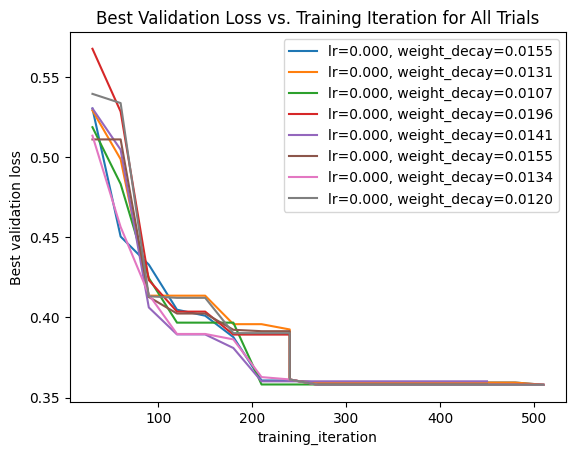

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(300, 150))

ax = None
for result in results_grid:
    label = f"lr={result.config['lr']:.3f}, weight_decay={result.config['weight_decay']:.4f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "best_val_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "best_val_loss", ax=ax, label=label)

ax.set_title("Best Validation Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Best validation loss")
plt.show()  # Display the plot


As you might have noticed, the PBT is not exactly correct: it doesn't re-use models but re-starts training for all models without considering to continue any of them. This is due to the difficulty in providing a working trainable object with this particular train loop.

The positive thing about it is that it ensures HP perturbations and that it maintains only the best performing HP.

#### 3.e) Performance assessment and evaluation

Below, I will assess the performances of the best model obtained above on the test set. To do this we need, in order, to:
1. Retrieve the best performing model's checkpoint;
2. Load the best performing checkpoint;
3. Tokenize again the dataset in order to produce tokenized test set;
4. Implement test dataloader;
5. Assess its performances on unseen data.

In [ ]:
# Load the best fine tuned model and move it to GPU
id2label = {0: "method", 1: "background", 2: "result"}
label2id = {"method": 0, "background": 1, "result": 2}

best_model = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=3, id2label=id2label, label2id=label2id)

with best_result.checkpoint.as_directory() as checkpoint_dir:
    checkpoint = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
    model_state_dict = checkpoint['model_state_dict']  # Extract only the model's state dictionary
    best_model.load_state_dict(model_state_dict)

best_model = best_model.to(device)

full_model_path = "/content/drive/MyDrive/Models/SciBERT_Models/FT_SciBERT/Cased/SciBERT_cased_ft.pt"
torch.save(best_model.state_dict(), full_model_path)

print(f"Model saved to {full_model_path}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model saved to /content/drive/MyDrive/Models/SciBERT_Models/FT_SciBERT/Cased/SciBERT_cased_ft.pt


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(ckp)

def tokenize_function(examples):
    augmented = ['[SECTION] ' + section + '. [CITATION] ' + string + ". Has function:" for section, string in zip(examples['sectionName'], examples['string'])]
    tokenized = tokenizer(augmented, max_length=tokenizer_length, padding='max_length', truncation=True)
    tokenized['augmented'] = augmented
    return tokenized

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id'])#, 'token_type_ids'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

In [ ]:
# Test dataset and dataloader
test_dataset = tokenized_datasets["test"]
eval_dataloader = DataLoader(test_dataset, batch_size=128)

In [ ]:
###############################################################################
########################### Performance assessment ###########################
###############################################################################
from tqdm.auto import tqdm

predictions_list = []
labels_list = []

best_model.eval() # Set the model to evaluation mode
test_loss = 0.0
num_test_batches = 0

test_progress_bar = tqdm(eval_dataloader, desc="Evaluating on Test Set")

with torch.no_grad():  # Disable gradient computation
    for batch in test_progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = best_model(**batch)
        loss = outputs.loss

        test_loss += loss.item()
        num_test_batches += 1

        # Store predictions and labels
        preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
        predictions_list.extend(preds)
        labels_list.extend(batch["labels"].cpu().numpy())

        test_progress_bar.set_postfix({"loss": loss.item()})

test_loss /= num_test_batches

print(f"Test Loss: {test_loss:.4f}")

# Calculate F1 score and accuracy using the stored predictions and labels
test_f1 = f1_score(labels_list, predictions_list, average="macro")
test_f1_none = f1_score(labels_list, predictions_list, average=None)
test_acc = accuracy_score(labels_list, predictions_list)

print(f"Test F1: {test_f1:.4f}, Test_f1_None: {test_f1_none} Test Acc: {test_acc:.4f}")

Evaluating on Test Set:   0%|          | 0/15 [00:00<?, ?it/s]

Test Loss: 0.3748
Test F1: 0.8700, Test_f1_None: [0.8868399  0.89540172 0.82783883] Test Acc: 0.8827


## 4. Ensemble model

#### 4.a) Introduction to the methodology

In order to develop an ensemble model we first need to produce some base models capable of carrying out a part of the entire classification task. To this aim, I will build three different binary classifiers, each of which trained in recognizing whether a specific sentence can or cannot be classified as being part of a specific class.

In the end, I will obtain three binary classifiers:
- Background based model: aimed at correctly classifying whether a sentence is of type background or not;
- Method based model: aimed at correctly classifying whether a sentence is of type method or not;
- Result based model: aimed at correctly classifying whether a sentence is of type result or not.

Once I have the final predictions made by the models, I will use them as input to an ensemble classifier, for which I will inspect different possibilities.

#### 4.b) Base functions

Here, I define the basic functions useful to map labels to their binary counterpart.

In [ ]:
def background_transform_labels(example):
    if example['label'] == 1:
        example['label'] = 1  # 'yes'
    elif example['label'] in [0, 2]:
        example['label'] = 0  # 'no'
    return example

def method_transform_labels(example):
    if example['label'] == 0:
        example['label'] = 1  # 'yes'
    elif example['label'] in [1, 2]:
        example['label'] = 0  # 'no'
    return example

def result_transform_labels(example):
    if example['label'] == 2:
        example['label'] = 1  # 'yes'
    elif example['label'] in [0, 1]:
        example['label'] = 0  # 'no'
    return example

Now, we need a training loop for these binary classifiers we aim at building. For these base models, I will not make use of Hyperparameter search strategies. The loop below is based on the same theoretical information given above (scaled, fine-grained eveluation...).

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from tqdm.auto import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

def train_model(model, class_weights_tensor, train_dataloader, val_dataloader, model_path):
    loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
    no_decay = ['bias', 'LayerNorm.weight']

    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

    # Replace StepLR with ReduceLROnPlateau
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=6, factor=0.2, cooldown=8, verbose=True)

    num_epochs = 5
    batch_counter = 0
    accumulation_steps = 1
    validation_interval = 10
    step_counter = 0

    best_val_loss = float('inf')
    best_model_path = model_path # 'background_model_loss.pt'
    best_val_f1 = float('-inf')
    #best_model_f1_path = 'background_model_f1.pt'

    # For mixed precision training
    scaler = GradScaler()

    # For early stopping
    no_improvement = 0
    early_stopping_patience = 50  # Number of evaluations with no improvement after which training will be stopped

    for epoch in range(num_epochs):
        train_loss = 0.0
        num_train_batches = 0
        train_predictions_list = []
        train_labels_list = []

        epoch_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")

        optimizer.zero_grad()

        for batch in epoch_progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}

            # Use autocast for mixed precision
            with autocast():
                outputs = model(**batch)
                loss = outputs.loss

            # Use scaler for backward
            scaler.scale(loss).backward()

            batch_counter += 1

            if batch_counter % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                batch_counter = 0

            train_loss += loss.item()
            num_train_batches += 1

            train_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
            train_predictions_list.extend(train_preds)
            train_labels_list.extend(batch["labels"].cpu().numpy())

            epoch_progress_bar.set_postfix({"train_loss": train_loss / num_train_batches})

            step_counter += 1

            if step_counter % validation_interval == 0:
                model.eval()
                val_loss = 0.0
                num_val_batches = 0
                val_predictions_list = []
                val_labels_list = []

                with torch.no_grad():
                    for batch in val_dataloader:
                        batch = {k: v.to(device) for k, v in batch.items()}

                        # Use autocast for mixed precision
                        with autocast():
                            outputs = model(**batch)
                            loss = outputs.loss

                        val_loss += loss.item()
                        num_val_batches += 1

                        val_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
                        val_predictions_list.extend(val_preds)
                        val_labels_list.extend(batch["labels"].cpu().numpy())

                val_loss /= num_val_batches

                val_f1 = f1_score(val_labels_list, val_predictions_list, average="macro")
                val_acc = accuracy_score(val_labels_list, val_predictions_list)

                if val_f1 > best_val_f1:
                    best_val_f1 = val_f1
                    #torch.save(model_background.state_dict(), best_model_f1_path)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), best_model_path)
                    no_improvement = 0
                else:
                    no_improvement += 1
                    if no_improvement >= early_stopping_patience:
                        print("No improvement in validation loss for {} steps, stopping.".format(early_stopping_patience))
                        break

                scheduler.step(val_loss)

                print(f"Step {step_counter}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Acc: {val_acc:.4f}")
                print(f"Best Val Loss: {best_val_loss:.4f}")
                print(f"Best Val Macro-F1: {best_val_f1:.4f}")

                model.train()

        if no_improvement >= early_stopping_patience:
            break

        train_loss /= num_train_batches

        train_f1 = f1_score(train_labels_list, train_predictions_list, average="macro")
        train_acc = accuracy_score(train_labels_list, train_predictions_list)
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Acc: {train_acc:.4f}")

Finally, I write a function to compute class weights.

In [ ]:
def compute_weight_tensor(tokenized_datasets):
    label_counts = Counter(tokenized_datasets['train']['label'])
    # Calculate weights
    class_weights = {k: 1.0 / v for k, v in label_counts.items()}
    # Normalize weights such that the sum of weights equals the number of classes
    total_weights = sum(class_weights.values())
    class_weights = {k: v * len(label_counts) / total_weights for k, v in class_weights.items()}
    # Transform the dict to a tensor and give it to device
    class_weights_tensor = torch.tensor([class_weights[i] for i in [0, 1]], dtype=torch.float).to(device)
    return class_weights_tensor

Now, we can go inside the specificity of each particular binary classifiers, each of which will make use of different weight for loss balance, and will work on different dataloaders.

#### 4.c) Base models

The operations for each model will be basically the same but with different objects and computations. Thus, I will explain them in detail only for their first appeareance.

First of all, let's download the dataset again and set the GPU device.

In [ ]:
dataset = load_dataset("allenai/scicite")

if torch.cuda.is_available():
    print('cuda')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

cuda


Let's map the labels to the binary case thanks to the functions defined in the previous section.

In [ ]:
background_datasets = dataset.map(background_transform_labels)
method_datasets = dataset.map(method_transform_labels)
result_datasets = dataset.map(result_transform_labels)

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Now, let's compute all the weights to balance the loss function.

In [ ]:
background_weight_tensor = compute_weight_tensor(background_datasets)
method_weight_tensor = compute_weight_tensor(method_datasets)
result_weight_tensor = compute_weight_tensor(result_datasets)

Now, we can define the various dataloaders. But, before, we write a function to carry on the tokenization part.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(ckp)

def tokenize_function(examples):
    augmented = [section + '. ' + string for section, string in zip(examples['sectionName'], examples['string'])]
    tokenized = tokenizer(augmented, max_length=256, padding='max_length', truncation=True)
    tokenized['augmented'] = augmented
    return tokenized

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def prepare_dataloader(dataset, batch_size, seed=None):
    if seed is not None:
        set_seed(seed)

    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id'])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    train_dataset = tokenized_datasets["train"]
    val_dataset = tokenized_datasets["validation"]

    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    return train_dataloader, val_dataloader

batch_size = 32
random_seed = 1482

background_train_dataloader, background_val_dataloader = prepare_dataloader(background_datasets, batch_size, seed=random_seed)
method_train_dataloader, method_val_dataloader = prepare_dataloader(method_datasets, batch_size, seed=random_seed)
result_train_dataloader, result_val_dataloader = prepare_dataloader(result_datasets, batch_size, seed=random_seed)

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

It is important to notice that I will not use at all the test set with the base models. The first time the test set will be used is with the ensemble classifier.

##### <b>Background model</b>

Now, it is time to define the base models I will use for the ensemble classifier. Let's start with the Background model.

The steps will be the same for each model, so I will not repeat what I do.

The main part consists of a mapping between integer and literal labels. Such map must be fed to the PLM I will use, during the loading.

In [ ]:
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

model_background = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
model_background = model_background.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now, we can procede with the training. In order to do that, I will use the above defined training loop function.

In [ ]:
train_model(model_background, background_weight_tensor, background_train_dataloader, background_val_dataloader, "background_model.pt")

Epoch 1/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 10, Val Loss: 0.5431, Val F1: 0.7164, Val Acc: 0.7544
Best Val Loss: 0.5431
Best Val Macro-F1: 0.7164
Step 20, Val Loss: 0.4379, Val F1: 0.7954, Val Acc: 0.8002
Best Val Loss: 0.4379
Best Val Macro-F1: 0.7954
Step 30, Val Loss: 0.4265, Val F1: 0.8116, Val Acc: 0.8210
Best Val Loss: 0.4265
Best Val Macro-F1: 0.8116
Step 40, Val Loss: 0.3974, Val F1: 0.8247, Val Acc: 0.8330
Best Val Loss: 0.3974
Best Val Macro-F1: 0.8247
Step 50, Val Loss: 0.3798, Val F1: 0.8319, Val Acc: 0.8362
Best Val Loss: 0.3798
Best Val Macro-F1: 0.8319
Step 60, Val Loss: 0.3716, Val F1: 0.8365, Val Acc: 0.8417
Best Val Loss: 0.3716
Best Val Macro-F1: 0.8365
Step 70, Val Loss: 0.3869, Val F1: 0.8404, Val Acc: 0.8472
Best Val Loss: 0.3716
Best Val Macro-F1: 0.8404
Step 80, Val Loss: 0.4057, Val F1: 0.8162, Val Acc: 0.8188
Best Val Loss: 0.3716
Best Val Macro-F1: 0.8404
Step 90, Val Loss: 0.3519, Val F1: 0.8486, Val Acc: 0.8537
Best Val Loss: 0.3519
Best Val Macro-F1: 0.8486
Step 100, Val Loss: 0.3564, Val F1: 0

Epoch 2/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 260, Val Loss: 0.3559, Val F1: 0.8402, Val Acc: 0.8428
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 270, Val Loss: 0.3558, Val F1: 0.8609, Val Acc: 0.8657
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 280, Val Loss: 0.3604, Val F1: 0.8558, Val Acc: 0.8624
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 290, Val Loss: 0.3691, Val F1: 0.8530, Val Acc: 0.8570
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 300, Val Loss: 0.3854, Val F1: 0.8517, Val Acc: 0.8581
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 310, Val Loss: 0.4026, Val F1: 0.8403, Val Acc: 0.8428
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Epoch 00032: reducing learning rate of group 0 to 4.0000e-06.
Epoch 00032: reducing learning rate of group 1 to 4.0000e-06.
Step 320, Val Loss: 0.3641, Val F1: 0.8648, Val Acc: 0.8701
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 330, Val Loss: 0.3662, Val F1: 0.8588, Val Acc: 0.8635
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 340, Va

Epoch 3/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 520, Val Loss: 0.3525, Val F1: 0.8585, Val Acc: 0.8635
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 530, Val Loss: 0.3532, Val F1: 0.8570, Val Acc: 0.8624
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 540, Val Loss: 0.3538, Val F1: 0.8573, Val Acc: 0.8624
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 550, Val Loss: 0.3541, Val F1: 0.8597, Val Acc: 0.8646
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 560, Val Loss: 0.3559, Val F1: 0.8624, Val Acc: 0.8668
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 570, Val Loss: 0.3578, Val F1: 0.8593, Val Acc: 0.8635
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 580, Val Loss: 0.3601, Val F1: 0.8572, Val Acc: 0.8614
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 590, Val Loss: 0.3612, Val F1: 0.8593, Val Acc: 0.8635
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 600, Val Loss: 0.3625, Val F1: 0.8581, Val Acc: 0.8624
Best Val Loss: 0.3245
Best Val Macro-F1: 0.8671
Step 610, Val Loss: 0.3624, 

##### <b>Method model</b>

In [ ]:
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

model_method = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
model_method = model_method.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_model(model_method, method_weight_tensor, method_train_dataloader, method_val_dataloader, "method_model.pt")

Epoch 1/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 10, Val Loss: 0.4292, Val F1: 0.7436, Val Acc: 0.8341
Best Val Loss: 0.4292
Best Val Macro-F1: 0.7436
Step 20, Val Loss: 0.3373, Val F1: 0.8212, Val Acc: 0.8701
Best Val Loss: 0.3373
Best Val Macro-F1: 0.8212
Step 30, Val Loss: 0.3224, Val F1: 0.8364, Val Acc: 0.8603
Best Val Loss: 0.3224
Best Val Macro-F1: 0.8364
Step 40, Val Loss: 0.3092, Val F1: 0.8536, Val Acc: 0.8886
Best Val Loss: 0.3092
Best Val Macro-F1: 0.8536
Step 50, Val Loss: 0.2856, Val F1: 0.8626, Val Acc: 0.8865
Best Val Loss: 0.2856
Best Val Macro-F1: 0.8626
Step 60, Val Loss: 0.2862, Val F1: 0.8573, Val Acc: 0.8908
Best Val Loss: 0.2856
Best Val Macro-F1: 0.8626
Step 70, Val Loss: 0.2788, Val F1: 0.8643, Val Acc: 0.8919
Best Val Loss: 0.2788
Best Val Macro-F1: 0.8643
Step 80, Val Loss: 0.2712, Val F1: 0.8753, Val Acc: 0.9017
Best Val Loss: 0.2712
Best Val Macro-F1: 0.8753
Step 90, Val Loss: 0.2691, Val F1: 0.8802, Val Acc: 0.9050
Best Val Loss: 0.2691
Best Val Macro-F1: 0.8802
Step 100, Val Loss: 0.2675, Val F1: 0

Epoch 2/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 260, Val Loss: 0.2481, Val F1: 0.8798, Val Acc: 0.9028
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8857
Step 270, Val Loss: 0.2567, Val F1: 0.8730, Val Acc: 0.9039
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8857
Step 280, Val Loss: 0.2519, Val F1: 0.8928, Val Acc: 0.9138
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8928
Step 290, Val Loss: 0.2474, Val F1: 0.8923, Val Acc: 0.9138
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8928
Epoch 00030: reducing learning rate of group 0 to 4.0000e-06.
Epoch 00030: reducing learning rate of group 1 to 4.0000e-06.
Step 300, Val Loss: 0.2558, Val F1: 0.8811, Val Acc: 0.9072
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8928
Step 310, Val Loss: 0.2546, Val F1: 0.8860, Val Acc: 0.9094
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8928
Step 320, Val Loss: 0.2518, Val F1: 0.8817, Val Acc: 0.9072
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8928
Step 330, Val Loss: 0.2491, Val F1: 0.8821, Val Acc: 0.9083
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8928
Step 340, Va

Epoch 3/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 520, Val Loss: 0.2546, Val F1: 0.8839, Val Acc: 0.9083
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8928
Step 530, Val Loss: 0.2553, Val F1: 0.8860, Val Acc: 0.9094
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8928
Step 540, Val Loss: 0.2562, Val F1: 0.8890, Val Acc: 0.9116
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8928
Step 550, Val Loss: 0.2558, Val F1: 0.8824, Val Acc: 0.9072
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8928
Step 560, Val Loss: 0.2565, Val F1: 0.8759, Val Acc: 0.9028
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8928
Step 570, Val Loss: 0.2571, Val F1: 0.8752, Val Acc: 0.9028
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8928
Step 580, Val Loss: 0.2575, Val F1: 0.8743, Val Acc: 0.9017
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8928
Step 590, Val Loss: 0.2578, Val F1: 0.8743, Val Acc: 0.9017
Best Val Loss: 0.2450
Best Val Macro-F1: 0.8928
Epoch 00060: reducing learning rate of group 0 to 1.6000e-07.
Epoch 00060: reducing learning rate of group 1 to 1.6000e-07.
Step 600, Va

##### <b>Result model</b>

In [ ]:
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

model_result = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
model_result = model_result.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_model(model_result, result_weight_tensor, result_train_dataloader, result_val_dataloader, "result_model.pt")

Epoch 1/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 10, Val Loss: 0.3652, Val F1: 0.4640, Val Acc: 0.8657
Best Val Loss: 0.3652
Best Val Macro-F1: 0.4640
Step 20, Val Loss: 0.2752, Val F1: 0.4640, Val Acc: 0.8657
Best Val Loss: 0.2752
Best Val Macro-F1: 0.4640
Step 30, Val Loss: 0.1849, Val F1: 0.8418, Val Acc: 0.9279
Best Val Loss: 0.1849
Best Val Macro-F1: 0.8418
Step 40, Val Loss: 0.1636, Val F1: 0.8738, Val Acc: 0.9454
Best Val Loss: 0.1636
Best Val Macro-F1: 0.8738
Step 50, Val Loss: 0.1571, Val F1: 0.8759, Val Acc: 0.9465
Best Val Loss: 0.1571
Best Val Macro-F1: 0.8759
Step 60, Val Loss: 0.1720, Val F1: 0.8722, Val Acc: 0.9400
Best Val Loss: 0.1571
Best Val Macro-F1: 0.8759
Step 70, Val Loss: 0.1581, Val F1: 0.8729, Val Acc: 0.9465
Best Val Loss: 0.1571
Best Val Macro-F1: 0.8759
Step 80, Val Loss: 0.1539, Val F1: 0.8758, Val Acc: 0.9410
Best Val Loss: 0.1539
Best Val Macro-F1: 0.8759
Step 90, Val Loss: 0.1396, Val F1: 0.8813, Val Acc: 0.9465
Best Val Loss: 0.1396
Best Val Macro-F1: 0.8813
Step 100, Val Loss: 0.1442, Val F1: 0

Epoch 2/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 260, Val Loss: 0.1487, Val F1: 0.8684, Val Acc: 0.9378
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 270, Val Loss: 0.1586, Val F1: 0.8702, Val Acc: 0.9378
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 280, Val Loss: 0.1568, Val F1: 0.8684, Val Acc: 0.9378
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 290, Val Loss: 0.1598, Val F1: 0.8693, Val Acc: 0.9378
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 300, Val Loss: 0.1523, Val F1: 0.8741, Val Acc: 0.9410
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 310, Val Loss: 0.1497, Val F1: 0.8723, Val Acc: 0.9410
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 320, Val Loss: 0.1483, Val F1: 0.8735, Val Acc: 0.9432
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 330, Val Loss: 0.1542, Val F1: 0.8732, Val Acc: 0.9410
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 340, Val Loss: 0.1704, Val F1: 0.8664, Val Acc: 0.9345
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 350, Val Loss: 0.1569, 

Epoch 3/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 520, Val Loss: 0.1580, Val F1: 0.8799, Val Acc: 0.9443
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 530, Val Loss: 0.1601, Val F1: 0.8826, Val Acc: 0.9454
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 540, Val Loss: 0.1618, Val F1: 0.8796, Val Acc: 0.9432
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Epoch 00055: reducing learning rate of group 0 to 1.6000e-07.
Epoch 00055: reducing learning rate of group 1 to 1.6000e-07.
Step 550, Val Loss: 0.1644, Val F1: 0.8720, Val Acc: 0.9389
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 560, Val Loss: 0.1642, Val F1: 0.8739, Val Acc: 0.9400
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 570, Val Loss: 0.1639, Val F1: 0.8739, Val Acc: 0.9400
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 580, Val Loss: 0.1638, Val F1: 0.8739, Val Acc: 0.9400
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 590, Val Loss: 0.1638, Val F1: 0.8739, Val Acc: 0.9400
Best Val Loss: 0.1298
Best Val Macro-F1: 0.8860
Step 600, Va

##### <b>Best models</b>

Now, I retrieve and load back all the best models.

In [ ]:
ckp = "allenai/scibert_scivocab_cased"

# Paths of models checkpoints
background_model_path = "background_model.pt"
method_model_path = "method_model.pth"
result_model_path = "result_model.pth"

# Usual mapping
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

# Load the best fine-tuned models and move them to GPU
background_model_best = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
background_model_best.load_state_dict(torch.load(background_model_path))
background_model_best = background_model_best.to(device)

method_model_best = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
method_model_best.load_state_dict(torch.load(method_model_path))
method_model_best = method_model_best.to(device)

result_model_best = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
result_model_best.load_state_dict(torch.load(result_model_path))
result_model_best = result_model_best.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 4.d) Ensemble models

In this section, I will play around with some different possibilities for the ensemble classifier. Each of which will be explained in its core parts.

I will start with main ML algorithms, to then move into something more elaborated.

The first step, common to all the methodologies, is the use of the three base models, which won't be re-trained according to the final output, but I decide to use their predictions according to what their original training has produced.

To do so, I define a function to extract the binary predictions.

In [ ]:
from tqdm import tqdm

def generate_predictions(dataloader, model1, model2, model3, device):
    model1 = model1.to(device).eval()
    model2 = model2.to(device).eval()
    model3 = model3.to(device).eval()

    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating predictions"):
            input_data = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            out1 = torch.softmax(model1(**input_data).logits, dim=-1)
            out2 = torch.softmax(model2(**input_data).logits, dim=-1)
            out3 = torch.softmax(model3(**input_data).logits, dim=-1)

            # The probabilities predicted for each class, for each model, are stacked
            out = torch.stack([out1, out2, out3], dim=-1)

            all_outputs.append(out)
            all_labels.append(labels)

    # Concatenate all outputs and labels along the batch dimension
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return all_outputs, all_labels

Now, let's make use of this function to retrieve the base predictions.

In order to do this, we must first define the new dataloaders and class weights.

In [ ]:
# To be sure we have back the original, I load again the dataset
dataset = load_dataset("allenai/scicite")

In [ ]:
label_counts = Counter(dataset['train']['label'])
class_weights = {k: 1.0 / v for k, v in label_counts.items()}

total_weights = sum(class_weights.values())
class_weights = {k: v * len(label_counts) / total_weights for k, v in class_weights.items()}

class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float).to(device)
class_weights_tensor

tensor([0.8449, 0.3955, 1.7596], device='cuda:0')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(ckp)

def tokenize_function(examples):
    augmented = [section + '. ' + string for section, string in zip(examples['sectionName'], examples['string'])]
    tokenized = tokenizer(augmented, max_length=256, padding='max_length', truncation=True)
    tokenized['augmented'] = augmented
    return tokenized

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id']) #'token_type_ids'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

In [ ]:
train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)
eval_dataloader = DataLoader(test_dataset, batch_size=128)

In the following snippet, I extract the predictions done by base models. These will be used as input for the ML models I will try on the task.

In [ ]:
base_model_outputs_train = generate_predictions(train_dataloader, background_model_best, method_model_best, result_model_best, device)
base_model_outputs_val = generate_predictions(val_dataloader, background_model_best, method_model_best, result_model_best, device)
base_model_outputs_test = generate_predictions(eval_dataloader, background_model_best, method_model_best, result_model_best, device)

Generating predictions: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


Let's now set up a train, validation, test split with our data.

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Get the numpy arrays from the datasets
X_train = base_model_outputs_train[0].view(len(base_model_outputs_train[0]), -1).cpu().numpy()
y_train = base_model_outputs_train[1].cpu().numpy()

X_val = base_model_outputs_val[0].view(len(base_model_outputs_val[0]), -1).cpu().numpy()
y_val = base_model_outputs_val[1].cpu().numpy()

X_test = base_model_outputs_test[0].view(len(base_model_outputs_test[0]), -1).cpu().numpy()
y_test = base_model_outputs_test[1].cpu().numpy()

Before moving on, we need to create Dataset and Dataloader objects in order to handle data. These, will be used as input/output providers for our deep learning experiments.

In [ ]:
from torch.utils.data import Dataset

class MetaClassifierDataset(Dataset):
    def __init__(self, outputs, labels):
        self.outputs = outputs.view(len(outputs), -1)  # Flatten the inputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.outputs[idx], self.labels[idx]

train_dataset = MetaClassifierDataset(base_model_outputs_train[0], base_model_outputs_train[1])
val_dataset = MetaClassifierDataset(base_model_outputs_val[0], base_model_outputs_val[1])
test_dataset = MetaClassifierDataset(base_model_outputs_test[0], base_model_outputs_test[1])

# I do not build Dataloaders here because I will do it when necessary

#train_dataloader_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
#val_dataloader_dl = DataLoader(val_dataset, batch_size=64, shuffle=False)
#eval_dataloader_dl = DataLoader(test_dataset, batch_size=64, shuffle=False)

##### <b>Confidence based selection</b>

Before getting into ML algorithms, I'd like to try a confidence based selection of the most probable class. To do so, I will make use of the same generate predictions functions, together with a function useful to extract the prediction with higher probability among the others.

Now, let's inspect a single prediction.

In [ ]:
X_test[0]

array([4.3505955e-01, 5.1494783e-01, 9.9906951e-01, 5.6494045e-01,
       4.8505220e-01, 9.3047431e-04], dtype=float32)

For what we can see, the prediction is a 6-elements array, and it has the following structure:

    [background_negative, method_negative, result_negative, background_positive, method_positive, result_positive]

Thus, in order to get the positive predictions, we have to take into consideration the last three elements of the array.

<b><u>Highest score voting</u></b>

What I will do below, is to extract the final result by simply looking at the highest among the three positive predictions. In this way, we will see whether the 3 base BERT work well, and we have a base for a comparison with more advanced algorithms.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

def classify_prediction(predictions):
    """
    Takes in the stacked predictions and returns the label of the highest positive predicted value.

    Parameters:
    - predictions (list or numpy array): Stacked predictions of shape
    [background_positive, method_positive, result_positive]

    Returns:
    - int: 0 (for 'method'), 1 (for 'background'), or 2 (for 'result')
    """

    background_positive = predictions[3]
    method_positive = predictions[4]
    result_positive = predictions[5]

    max_index = np.argmax([method_positive, background_positive, result_positive])

    # Use argmax to get the index of the highest positive predicted value
    # the index is consistent with the integer labels, as explained above
    return max_index

# For each sample in X_test, I classify it using the classify_prediction function
predicted_labels = [classify_prediction(X_test[i]) for i in range(X_test.shape[0])]

# Compare predictions and true labels
accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')

# Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8833
Macro F1-Score: 0.8665
              precision    recall  f1-score   support

      method       0.94      0.88      0.91       604
  background       0.91      0.88      0.89       996
      result       0.71      0.91      0.80       259

    accuracy                           0.88      1859
   macro avg       0.85      0.89      0.87      1859
weighted avg       0.89      0.88      0.89      1859



As we can see, this simple strategy gives yet very good results, producing a macro-F1 score of 86.65%, surpassing most of the models in the [benchmark](https://paperswithcode.com/sota/citation-intent-classification-on-scicite) table, and getting the second best result.

Let's now see if we can further improve this score.

##### <b>Random Forest</b>

The first algorithm I will try is Random Forest. To do so, I will make use of a grid search for HP optimization. The HP for which I want to explore different configurations are:
- n_estimators: number of individual decision trees to be included in the random forest ensemble;
- max_depth: determines the maximum depth of each decision tree in the ensemble;
- min_samples_split: specifies the minimum number of samples required to split an internal node of a decision tree;
- min_samples_leaf: determines the minimum number of samples required to be in a leaf node of a decision tree;
- bootstrap: whether to train or not each tree on the entire dataset (it happens with bootstrap=False);
- criterion: the criterion used for node splitting, can be gini imppurity, or entropy;
- class_weight: to see whether adding weights for class imbalance helps or not.

These HP may determine whether the model overfits, underfits, or is sufficiently well adapted to data. Additionally, we should be able to see whether the model has some particular combination that allows it to better adapt to the task at hand.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [3, 5],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

# Define the scoring metric
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# Create the Random Forest classifier
rf = RandomForestClassifier(random_state=1482)

# Perform grid search with cross-validation
grid_rf = GridSearchCV(rf, param_grid, scoring=scoring, cv=5, refit="f1_macro", verbose=3)

# Fit the grid search to the training data
grid_rf.fit(X_train_val, y_train_val)

# Print the best parameters and the best score
print("Best parameters: ", grid_rf.best_params_)
print("Best score: ", grid_rf.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.923) total time=   0.1s
[CV 2/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.933) total time=   0.1s
[CV 3/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.923) total time=   0.1s
[CV 4/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.923) total time=   0.1s
[CV 5/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.884) total time=   0.1s
[CV 1/5] END bootstrap=True, cla

And now, let's check the best performing model on our test set.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

predicted_labels = grid_rf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8870
Macro F1-Score: 0.8709
              precision    recall  f1-score   support

      method       0.94      0.87      0.90       604
  background       0.91      0.89      0.90       996
      result       0.74      0.90      0.81       259

    accuracy                           0.89      1859
   macro avg       0.86      0.89      0.87      1859
weighted avg       0.89      0.89      0.89      1859



As we can see, thanks to Random Forest algorithm, we have come closer to the SOTA model for the task, improving the performance from 86.65% macro-F1, to 87.09% macro-F1.

Let's go on and see if we can go any further...

##### <b>XGBoost</b>

Now, I will try XGBoost technique, which implements machine learning algorithms under the Gradient Boosting framework. This means it works by combining the results of several weak learners (typically decision trees) into a single strong learner in an iterative fashion.

I will search in the HP space for:
- learning_rate: Also known as the step size. It determines the step size at each iteration while moving toward a minimum loss function. By default, XGBoost sets it to 0.3. Lower values make the optimization more robust, but require more boosting rounds;
- max_depth: The maximum depth of a tree;
- n_estimators: It defines the number of boosting rounds or trees to build.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score

X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Define the model
xgb = XGBClassifier(eval_metric='mlogloss', random_state=1482)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.05],
    'max_depth': [3, 5, 10],
    'n_estimators': [10, 50, 100],
    'gamma': [0, 0.05, 0.1]
}

# Define scoring metric
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# Create the grid search object
grid_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring=scoring, refit='f1_macro', verbose=3)

# Fit the grid search object to the data
grid_xgb.fit(X_train_val, y_train_val)

# Print the best parameters and the best score
print("Best parameters: ", grid_xgb.best_params_)
print("Best score: ", grid_xgb.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.935) total time=   0.3s
[CV 2/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.940) total time=   0.3s
[CV 3/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.930) total time=   0.3s
[CV 4/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.932) total time=   0.3s
[CV 5/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.894) total time=   0.3s
[CV 1/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50; f1_macro: (test=0.935) total time=   1.3s
[CV 2/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50; f1_macro: (test=0.940) total time=   1.3s
[CV 3/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50; f1_macro: (test=0.930) total time=   1.3s
[CV 4/5] END gamma

In [ ]:
# The best model is:
model = grid_xgb.best_estimator_
predicted_labels = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8854
Macro F1-Score: 0.8691
              precision    recall  f1-score   support

      method       0.94      0.88      0.91       604
  background       0.91      0.89      0.90       996
      result       0.73      0.90      0.80       259

    accuracy                           0.89      1859
   macro avg       0.86      0.89      0.87      1859
weighted avg       0.89      0.89      0.89      1859



As we can see, with XGBoost we have been able to improve base performances to 86.91%, but the results are still lower than the top result obtained, that is for now given by random forest.

##### <b>K-Nearest Neighbors</b>

This step involves using KNN algorithm. With this, I operate a grid search only on the number of neighbors.


In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Stack the training and validation sets
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Create a K-NN classifier
knn = KNeighborsClassifier() # This time we cannot set a seed, since the KNN is deterministic

# Define the parameter values that should be searched
k_range = list(range(1, 101))

# Create a parameter grid, which maps the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)

# I define the scoring metric
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# Instantiate the grid
grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring=scoring, refit='f1_macro', verbose=3)

# Fit the grid with data
grid_knn.fit(X_train_val, y_train_val)

# View the complete results
print(grid_knn.cv_results_)

# Examine the best model
print("Best score: ", grid_knn.best_score_)
print("Best parameters: ", grid_knn.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ...........n_neighbors=1; f1_macro: (test=0.889) total time=   0.1s
[CV 2/5] END ...........n_neighbors=1; f1_macro: (test=0.897) total time=   0.1s
[CV 3/5] END ...........n_neighbors=1; f1_macro: (test=0.895) total time=   0.1s
[CV 4/5] END ...........n_neighbors=1; f1_macro: (test=0.890) total time=   0.1s
[CV 5/5] END ...........n_neighbors=1; f1_macro: (test=0.872) total time=   0.1s
[CV 1/5] END ...........n_neighbors=2; f1_macro: (test=0.890) total time=   0.1s
[CV 2/5] END ...........n_neighbors=2; f1_macro: (test=0.895) total time=   0.2s
[CV 3/5] END ...........n_neighbors=2; f1_macro: (test=0.894) total time=   0.1s
[CV 4/5] END ...........n_neighbors=2; f1_macro: (test=0.886) total time=   0.1s
[CV 5/5] END ...........n_neighbors=2; f1_macro: (test=0.870) total time=   0.1s
[CV 1/5] END ...........n_neighbors=3; f1_macro: (test=0.929) total time=   0.2s
[CV 2/5] END ...........n_neighbors=3; f1_macr

In [ ]:
# The best model is:
model = grid_knn.best_estimator_
predicted_labels = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8886
Macro F1-Score: 0.8731
              precision    recall  f1-score   support

      method       0.94      0.87      0.91       604
  background       0.91      0.89      0.90       996
      result       0.74      0.90      0.81       259

    accuracy                           0.89      1859
   macro avg       0.86      0.89      0.87      1859
weighted avg       0.89      0.89      0.89      1859



As we can see, we are getting closer to SOTA model. </br>We have now surpassed the Random Forest, setting a new standard of 87.31% macro-F1.

##### <b>Support Vector Machine</b>

It is now time to try with our last ML algorithm, SVM.
For this, I will operate again a grid search, and this time the HP I will consider are the following:
-

In [ ]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE

# Stack the training and validation sets
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))


# Define the parameter ranges
param_grid = {
    'C': [0.01, 0.1],
    'gamma': [1, 'scale', 'auto'],
    'kernel': ['rbf', 'sigmoid'], # I exclude linear kernel because hardly could provide good results, I also exclude poly kernel in order to avoid to deal with degree HP
    'class_weight': [None, 'balanced']
}

scoring = {'f1_macro': make_scorer(f1_score, average='macro')}
grid_svm = GridSearchCV(SVC(probability=True, random_state=1482), param_grid, cv=5, scoring=scoring, refit='f1_macro', verbose=3)

# Fit on the data
grid_svm.fit(X_train_val, y_train_val)

# Print the best parameters
print(grid_svm.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.937) total time=   9.0s
[CV 2/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.945) total time=   7.0s
[CV 3/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.934) total time=   7.5s
[CV 4/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.939) total time=   5.0s
[CV 5/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.896) total time=   4.1s
[CV 1/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.935) total time=  17.2s
[CV 2/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.941) total time=  13.7s
[CV 3/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.933) total time=  16.9s
[CV 4/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.932) total time=  1

In [ ]:
# The best model is:
model = grid_svm.best_estimator_
predicted_labels = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8843
Macro F1-Score: 0.8681
              precision    recall  f1-score   support

      method       0.94      0.86      0.90       604
  background       0.90      0.89      0.90       996
      result       0.73      0.90      0.81       259

    accuracy                           0.88      1859
   macro avg       0.86      0.89      0.87      1859
weighted avg       0.89      0.88      0.89      1859



As you can see, SVM do not reach our top model, so we can procede and analyze DL based strategies.

#### <b>Meta Classifiers</b>

In this section, I will work on different NN architectures. In this case, HP search is manually performed through different tests. This is because I would like to have more control over training loop and get to see if and how something doesn't work. This is not so easy to do with Ray Tune Report. In particular, beside model definition, I will play around learning rate, weight decay and batch size.

The first step implies the definition of 3 main functions: one to plot the training history, one to train the models, and one to evaluate them.

In [ ]:
def set_seed(seed_value=1482):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)
    random.seed(seed_value)

In [ ]:
def plot_metrics(train_metrics, val_metrics, metric_name):
    plt.plot(train_metrics, label=f'Training {metric_name}')
    plt.plot(val_metrics, label=f'Validation {metric_name}')
    plt.legend()
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.show()

In [ ]:
from torch.optim import lr_scheduler

def train_metaclassifier(meta_classifier, batch_size, num_epochs, lr, weight_decay, train_dataset, val_dataset, model_path):
    set_seed()

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    train_losses = []
    train_f1_scores = []
    val_losses = []
    val_f1_scores = []

    early_stopping_counter = 0
    early_stopping_patience = 30
    best_val_loss = float('inf')

    # I will only optimize the parameters of the MetaClassifier, not the other models
    optimizer = AdamW(meta_classifier.parameters(), lr=lr, weight_decay=weight_decay)

    # Initialize ReduceLROnPlateau scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, cooldown=5, verbose=True)
    loss_fn = torch.nn.CrossEntropyLoss()#weight=class_weights_tensor

    # Initialize GradScaler for mixed precision
    scaler = GradScaler()

    for epoch in range(num_epochs):
        progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=True, disable=False)
        meta_classifier.train()

        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch_idx, batch in enumerate(progress_bar):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            # Autocast for mixed precision
            with autocast():
                outputs = meta_classifier(inputs)
                loss = loss_fn(outputs, labels)

            # Scales the loss, and calls backward() on scaled loss to create scaled gradients
            scaler.scale(loss).backward()

            # Unscales the gradients of optimizer's assigned params in-place and calls
            # optimizer.step() if no infs/NaNs are found in the gradients.
            # Otherwise, optimizer.step() is skipped to avoid stepping on infs/NaNs
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()

            # Resets gradients
            optimizer.zero_grad()

            train_loss += loss.item()
            train_preds.extend(outputs.detach().cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(inputs))})

        avg_train_loss = train_loss/len(train_dataloader)
        train_f1 = f1_score(train_labels, np.argmax(train_preds, axis=1), average='macro')
        train_losses.append(avg_train_loss)
        train_f1_scores.append(train_f1)
        print(f"\nTraining Loss at end of epoch {epoch}: {avg_train_loss}")
        print(f"Training F1 Score at end of epoch {epoch}: {train_f1}")

        # Evaluate on validation data after each epoch
        meta_classifier.eval()
        val_preds = []
        val_labels = []
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_dataloader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device).long()

                outputs = meta_classifier(inputs)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
                val_preds.extend(outputs.detach().cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss/len(val_dataloader)
        val_f1_macro = f1_score(val_labels, np.argmax(val_preds, axis=1), average='macro')

        # Early stopping condition check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0

            # Save the model
            torch.save(meta_classifier.state_dict(), model_path)
            print(f"New best model saved with validation loss: {best_val_loss}")
        else:
            early_stopping_counter += 1

        # Break training loop
        if early_stopping_counter > early_stopping_patience:
            print(f"No improvement in Validation Loss for {early_stopping_patience} epochs. Training stops.")
            break

        val_f1_weighted = f1_score(val_labels, np.argmax(val_preds, axis=1), average=None)
        val_losses.append(avg_val_loss)
        val_f1_scores.append(val_f1_macro)
        print(f"\nValidation Loss at end of epoch {epoch}: {avg_val_loss}")
        print(f"Validation Macro F1 Score at end of epoch {epoch}: {val_f1_macro}")
        print(f"Validation Weighted F1 Score at end of epoch {epoch}: {val_f1_weighted}")
        scheduler.step(avg_val_loss)

    plot_metrics(train_losses, val_losses, 'Loss')
    plot_metrics(train_f1_scores, val_f1_scores, 'F1 Score')

In [ ]:
def evaluate_metaclassifier(meta_classifier, test_dataset):
    eval_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    loss_fn = torch.nn.CrossEntropyLoss()
    meta_classifier.eval()  # Set the model to evaluation mode
    test_preds = []
    test_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for batch in eval_dataloader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device).long()

            outputs = meta_classifier(inputs)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item()
            test_preds.extend(outputs.detach().cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss/len(eval_dataloader)
    test_f1_macro = f1_score(test_labels, np.argmax(test_preds, axis=1), average='macro')
    test_f1_weighted = f1_score(test_labels, np.argmax(test_preds, axis=1), average=None)
    test_accuracy = accuracy_score(test_labels, np.argmax(test_preds, axis=1))

    print(f"\nTest Loss: {avg_test_loss}")
    print(f"Test Macro F1 Score: {test_f1_macro}")
    print(f"Test Weighted F1 Score: {test_f1_weighted}")
    print(f"Test Accuracy: {test_accuracy}")

##### <b>Feed Forward NN</b>

The first thing I'd like to try is a simple feed forward NN. In it, I integrate both Batch Normalization and Dropout layers.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()

        self.fc1 = nn.Linear(6, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)

        x = F.gelu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout(x)

        x = F.selu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout(x)

        x = F.selu(self.fc4(x))
        x = self.bn4(x)
        x = self.dropout(x)

        x = self.fc5(x)
        x = F.softmax(x, dim=1)

        return x


Epoch 0:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 0: 1.0490778657106252
Training F1 Score at end of epoch 0: 0.4203931174342903
New best model saved with validation loss: 0.997147835791111

Validation Loss at end of epoch 0: 0.997147835791111
Validation Macro F1 Score at end of epoch 0: 0.809980358543685
Validation Weighted F1 Score at end of epoch 0: [0.79861111 0.84507042 0.78625954]


Epoch 1:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 1: 0.9923658536030696
Training F1 Score at end of epoch 1: 0.5149693111344964
New best model saved with validation loss: 0.9105368405580521

Validation Loss at end of epoch 1: 0.9105368405580521
Validation Macro F1 Score at end of epoch 1: 0.8303554399624623
Validation Weighted F1 Score at end of epoch 1: [0.83271375 0.87209302 0.78625954]


Epoch 2:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 2: 0.9417313804993263
Training F1 Score at end of epoch 2: 0.6223295004348102
New best model saved with validation loss: 0.856593906879425

Validation Loss at end of epoch 2: 0.856593906879425
Validation Macro F1 Score at end of epoch 2: 0.8257451158372073
Validation Weighted F1 Score at end of epoch 2: [0.82352941 0.86744639 0.78625954]


Epoch 3:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 3: 0.9006881814736586
Training F1 Score at end of epoch 3: 0.6975008020858366
New best model saved with validation loss: 0.8011521622538567

Validation Loss at end of epoch 3: 0.8011521622538567
Validation Macro F1 Score at end of epoch 3: 0.8364186184567038
Validation Weighted F1 Score at end of epoch 3: [0.82835821 0.87931034 0.8015873 ]


Epoch 4:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 4: 0.8670545312074515
Training F1 Score at end of epoch 4: 0.7409080147479999
New best model saved with validation loss: 0.7993755042552948

Validation Loss at end of epoch 4: 0.7993755042552948
Validation Macro F1 Score at end of epoch 4: 0.8245804834145981
Validation Weighted F1 Score at end of epoch 4: [0.81227437 0.86465433 0.79681275]


Epoch 5:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 5: 0.8430959508969234
Training F1 Score at end of epoch 5: 0.7738824240184571
New best model saved with validation loss: 0.777463860809803

Validation Loss at end of epoch 5: 0.777463860809803
Validation Macro F1 Score at end of epoch 5: 0.8231324870831084
Validation Weighted F1 Score at end of epoch 5: [0.8190128  0.86412512 0.78625954]


Epoch 6:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 6: 0.8242255898622366
Training F1 Score at end of epoch 6: 0.7943242618423633

Validation Loss at end of epoch 6: 0.7788395583629608
Validation Macro F1 Score at end of epoch 6: 0.8217654858940926
Validation Weighted F1 Score at end of epoch 6: [0.8190128  0.8630137  0.78326996]


Epoch 7:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 7: 0.8064387899178725
Training F1 Score at end of epoch 7: 0.8156485690180335
New best model saved with validation loss: 0.7556202188134193

Validation Loss at end of epoch 7: 0.7556202188134193
Validation Macro F1 Score at end of epoch 7: 0.8276428705381825
Validation Weighted F1 Score at end of epoch 7: [0.82681564 0.87149758 0.78461538]


Epoch 8:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 8: 0.7897961809084966
Training F1 Score at end of epoch 8: 0.8329153731940178

Validation Loss at end of epoch 8: 0.7568370774388313
Validation Macro F1 Score at end of epoch 8: 0.8267577671714456
Validation Weighted F1 Score at end of epoch 8: [0.81967213 0.86523438 0.7953668 ]


Epoch 9:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 9: 0.7754719679172223
Training F1 Score at end of epoch 9: 0.8412683107250657

Validation Loss at end of epoch 9: 0.7592347040772438
Validation Macro F1 Score at end of epoch 9: 0.8218714796764436
Validation Weighted F1 Score at end of epoch 9: [0.81684982 0.86385896 0.78490566]


Epoch 10:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 10: 0.7683806180953979
Training F1 Score at end of epoch 10: 0.8466863508122349
New best model saved with validation loss: 0.7501897066831589

Validation Loss at end of epoch 10: 0.7501897066831589
Validation Macro F1 Score at end of epoch 10: 0.8226690976603388
Validation Weighted F1 Score at end of epoch 10: [0.8213628  0.86634146 0.78030303]


Epoch 11:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 11: 0.7526050696006188
Training F1 Score at end of epoch 11: 0.8557741030698792
New best model saved with validation loss: 0.7423811554908752

Validation Loss at end of epoch 11: 0.7423811554908752
Validation Macro F1 Score at end of epoch 11: 0.8313706677771199
Validation Weighted F1 Score at end of epoch 11: [0.82485876 0.87547893 0.79377432]


Epoch 12:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 12: 0.7501345423551706
Training F1 Score at end of epoch 12: 0.8626085722224426
New best model saved with validation loss: 0.7344379052519798

Validation Loss at end of epoch 12: 0.7344379052519798
Validation Macro F1 Score at end of epoch 12: 0.8321482204606262
Validation Weighted F1 Score at end of epoch 12: [0.82899628 0.87367406 0.79377432]


Epoch 13:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 13: 0.7461505963252141
Training F1 Score at end of epoch 13: 0.8622263610379476
New best model saved with validation loss: 0.7157087177038193

Validation Loss at end of epoch 13: 0.7157087177038193
Validation Macro F1 Score at end of epoch 13: 0.8443497582541407
Validation Weighted F1 Score at end of epoch 13: [0.84190476 0.88636364 0.80478088]


Epoch 14:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 14: 0.7392466196647057
Training F1 Score at end of epoch 14: 0.8671159302798083

Validation Loss at end of epoch 14: 0.7282811775803566
Validation Macro F1 Score at end of epoch 14: 0.8347051343521134
Validation Weighted F1 Score at end of epoch 14: [0.83111954 0.87762906 0.7953668 ]


Epoch 15:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 15: 0.7315510905705965
Training F1 Score at end of epoch 15: 0.8759039928016373

Validation Loss at end of epoch 15: 0.7364410310983658
Validation Macro F1 Score at end of epoch 15: 0.8265256843895981
Validation Weighted F1 Score at end of epoch 15: [0.82201835 0.86686103 0.79069767]


Epoch 16:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 16: 0.7203505671941317
Training F1 Score at end of epoch 16: 0.8758884757089057
New best model saved with validation loss: 0.7133322283625603

Validation Loss at end of epoch 16: 0.7133322283625603
Validation Macro F1 Score at end of epoch 16: 0.8440605966113303
Validation Weighted F1 Score at end of epoch 16: [0.84007707 0.88741722 0.8046875 ]


Epoch 17:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 17: 0.7244383179224454
Training F1 Score at end of epoch 17: 0.8736714463070406

Validation Loss at end of epoch 17: 0.7254176512360573
Validation Macro F1 Score at end of epoch 17: 0.8311407771554816
Validation Weighted F1 Score at end of epoch 17: [0.82681564 0.87283237 0.79377432]


Epoch 18:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 18: 0.7117507439393264
Training F1 Score at end of epoch 18: 0.8788689261827246

Validation Loss at end of epoch 18: 0.7251543402671814
Validation Macro F1 Score at end of epoch 18: 0.8378580736245844
Validation Weighted F1 Score at end of epoch 18: [0.83428571 0.88083889 0.79844961]


Epoch 19:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 19: 0.7103255794598506
Training F1 Score at end of epoch 19: 0.8821826361508901
New best model saved with validation loss: 0.7126028686761856

Validation Loss at end of epoch 19: 0.7126028686761856
Validation Macro F1 Score at end of epoch 19: 0.8411626207325131
Validation Weighted F1 Score at end of epoch 19: [0.83870968 0.88319088 0.8015873 ]


Epoch 20:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 20: 0.7140263520754301
Training F1 Score at end of epoch 20: 0.8761049476053895
New best model saved with validation loss: 0.7026363238692284

Validation Loss at end of epoch 20: 0.7026363238692284
Validation Macro F1 Score at end of epoch 20: 0.8378549736766358
Validation Weighted F1 Score at end of epoch 20: [0.82608696 0.88432836 0.80314961]


Epoch 21:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 21: 0.7032364872785715
Training F1 Score at end of epoch 21: 0.8841925873891848

Validation Loss at end of epoch 21: 0.7175653949379921
Validation Macro F1 Score at end of epoch 21: 0.8387440789677609
Validation Weighted F1 Score at end of epoch 21: [0.83587786 0.88190476 0.79844961]


Epoch 22:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 22: 0.7009188331090487
Training F1 Score at end of epoch 22: 0.885765388543569

Validation Loss at end of epoch 22: 0.7175868898630142
Validation Macro F1 Score at end of epoch 22: 0.8334479609600183
Validation Weighted F1 Score at end of epoch 22: [0.82462687 0.87571702 0.8       ]


Epoch 23:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 23: 0.7006627064484816
Training F1 Score at end of epoch 23: 0.8847789958755327

Validation Loss at end of epoch 23: 0.7121743932366371
Validation Macro F1 Score at end of epoch 23: 0.8338546609655656
Validation Weighted F1 Score at end of epoch 23: [0.82551595 0.87762906 0.79841897]


Epoch 24:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 24: 0.6943793489382817
Training F1 Score at end of epoch 24: 0.8849949086308619

Validation Loss at end of epoch 24: 0.7108098492026329
Validation Macro F1 Score at end of epoch 24: 0.8394387108455549
Validation Weighted F1 Score at end of epoch 24: [0.83428571 0.88403042 0.8       ]


Epoch 25:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 25: 0.6994633399523221
Training F1 Score at end of epoch 25: 0.887008172753982

Validation Loss at end of epoch 25: 0.7128124460577965
Validation Macro F1 Score at end of epoch 25: 0.8340069414108079
Validation Weighted F1 Score at end of epoch 25: [0.82954545 0.87870105 0.79377432]


Epoch 26:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 26: 0.6894131798010606
Training F1 Score at end of epoch 26: 0.8885513668818795

Validation Loss at end of epoch 26: 0.7045041099190712
Validation Macro F1 Score at end of epoch 26: 0.8399465253759167
Validation Weighted F1 Score at end of epoch 26: [0.83070866 0.88598131 0.80314961]


Epoch 27:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 27: 0.6923879384994507
Training F1 Score at end of epoch 27: 0.8905238073404992

Validation Loss at end of epoch 27: 0.7092050090432167
Validation Macro F1 Score at end of epoch 27: 0.8416635321848592
Validation Weighted F1 Score at end of epoch 27: [0.83809524 0.88530806 0.8015873 ]


Epoch 28:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 28: 0.6934757168476399
Training F1 Score at end of epoch 28: 0.888234715694904

Validation Loss at end of epoch 28: 0.7107230424880981
Validation Macro F1 Score at end of epoch 28: 0.8371597938922083
Validation Weighted F1 Score at end of epoch 28: [0.83269962 0.88190476 0.796875  ]


Epoch 29:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 29: 0.6920209013498746
Training F1 Score at end of epoch 29: 0.8901177258179285

Validation Loss at end of epoch 29: 0.7059391289949417
Validation Macro F1 Score at end of epoch 29: 0.8449517169241886
Validation Weighted F1 Score at end of epoch 29: [0.84169884 0.88846881 0.8046875 ]


Epoch 30:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 30: 0.688706715290363
Training F1 Score at end of epoch 30: 0.890930705980273
New best model saved with validation loss: 0.6976536884903908

Validation Loss at end of epoch 30: 0.6976536884903908
Validation Macro F1 Score at end of epoch 30: 0.8387468351079591
Validation Weighted F1 Score at end of epoch 30: [0.82772277 0.88536813 0.80314961]


Epoch 31:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 31: 0.6818472110308134
Training F1 Score at end of epoch 31: 0.8914742451651345

Validation Loss at end of epoch 31: 0.7003837525844574
Validation Macro F1 Score at end of epoch 31: 0.8441914130593374
Validation Weighted F1 Score at end of epoch 31: [0.84230769 0.88867925 0.8015873 ]


Epoch 32:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 32: 0.687876503284161
Training F1 Score at end of epoch 32: 0.8933083785049764
New best model saved with validation loss: 0.6969989389181137

Validation Loss at end of epoch 32: 0.6969989389181137
Validation Macro F1 Score at end of epoch 32: 0.8431686772302288
Validation Weighted F1 Score at end of epoch 32: [0.84007707 0.88784166 0.8015873 ]


Epoch 33:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 33: 0.6771220601522006
Training F1 Score at end of epoch 33: 0.8948058509142549

Validation Loss at end of epoch 33: 0.7022350281476974
Validation Macro F1 Score at end of epoch 33: 0.8378549736766358
Validation Weighted F1 Score at end of epoch 33: [0.82608696 0.88432836 0.80314961]


Epoch 34:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 34: 0.679941828434284
Training F1 Score at end of epoch 34: 0.8951168405928089

Validation Loss at end of epoch 34: 0.7037396728992462
Validation Macro F1 Score at end of epoch 34: 0.8435224521191026
Validation Weighted F1 Score at end of epoch 34: [0.83809524 0.88614801 0.80632411]


Epoch 35:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 35: 0.6734563497396616
Training F1 Score at end of epoch 35: 0.895073031467278

Validation Loss at end of epoch 35: 0.7023346498608589
Validation Macro F1 Score at end of epoch 35: 0.8389020115959226
Validation Weighted F1 Score at end of epoch 35: [0.82840237 0.88515406 0.80314961]


Epoch 36:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 36: 0.6791081914534935
Training F1 Score at end of epoch 36: 0.896314394943929

Validation Loss at end of epoch 36: 0.7018025368452072
Validation Macro F1 Score at end of epoch 36: 0.8429974234592983
Validation Weighted F1 Score at end of epoch 36: [0.83969466 0.88614801 0.80314961]


Epoch 37:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 37: 0.6776262732652517
Training F1 Score at end of epoch 37: 0.8951585079764622

Validation Loss at end of epoch 37: 0.6993852406740189
Validation Macro F1 Score at end of epoch 37: 0.8387468351079591
Validation Weighted F1 Score at end of epoch 37: [0.82772277 0.88536813 0.80314961]


Epoch 38:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 38: 0.6763928248332097
Training F1 Score at end of epoch 38: 0.894817977371383
New best model saved with validation loss: 0.6931291297078133

Validation Loss at end of epoch 38: 0.6931291297078133
Validation Macro F1 Score at end of epoch 38: 0.84261582605389
Validation Weighted F1 Score at end of epoch 38: [0.83168317 0.8897127  0.80645161]


Epoch 39:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 39: 0.6774590042921212
Training F1 Score at end of epoch 39: 0.895000327492907

Validation Loss at end of epoch 39: 0.6979771703481674
Validation Macro F1 Score at end of epoch 39: 0.8403381880074835
Validation Weighted F1 Score at end of epoch 39: [0.83558994 0.88700565 0.79841897]


Epoch 40:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 40: 0.6772043044750508
Training F1 Score at end of epoch 40: 0.8980720495112724

Validation Loss at end of epoch 40: 0.6956265345215797
Validation Macro F1 Score at end of epoch 40: 0.8421435963808844
Validation Weighted F1 Score at end of epoch 40: [0.83783784 0.88700565 0.8015873 ]


Epoch 41:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 41: 0.6749904577548688
Training F1 Score at end of epoch 41: 0.8964229121266297

Validation Loss at end of epoch 41: 0.6977345570921898
Validation Macro F1 Score at end of epoch 41: 0.8442980327976416
Validation Weighted F1 Score at end of epoch 41: [0.8372093  0.88784166 0.80784314]


Epoch 42:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 42: 0.674584570297828
Training F1 Score at end of epoch 42: 0.8952085696031317

Validation Loss at end of epoch 42: 0.6960258930921555
Validation Macro F1 Score at end of epoch 42: 0.8378549736766358
Validation Weighted F1 Score at end of epoch 42: [0.82608696 0.88432836 0.80314961]


Epoch 43:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 43: 0.6667619521801288
Training F1 Score at end of epoch 43: 0.8938892712217864

Validation Loss at end of epoch 43: 0.6966662406921387
Validation Macro F1 Score at end of epoch 43: 0.8374748443454573
Validation Weighted F1 Score at end of epoch 43: [0.828      0.88600556 0.79841897]


Epoch 44:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 44: 0.6643318708126361
Training F1 Score at end of epoch 44: 0.9007150352597261
New best model saved with validation loss: 0.6905875653028488

Validation Loss at end of epoch 44: 0.6905875653028488
Validation Macro F1 Score at end of epoch 44: 0.8404742068928664
Validation Weighted F1 Score at end of epoch 44: [0.82677165 0.8880666  0.80658436]


Epoch 45:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 45: 0.6684705880972055
Training F1 Score at end of epoch 45: 0.899044762239786
New best model saved with validation loss: 0.6889752447605133

Validation Loss at end of epoch 45: 0.6889752447605133
Validation Macro F1 Score at end of epoch 45: 0.8377656058210694
Validation Weighted F1 Score at end of epoch 45: [0.82092555 0.88909258 0.80327869]


Epoch 46:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 46: 0.663328792498662
Training F1 Score at end of epoch 46: 0.899257613803457

Validation Loss at end of epoch 46: 0.6975120976567268
Validation Macro F1 Score at end of epoch 46: 0.8378549736766358
Validation Weighted F1 Score at end of epoch 46: [0.82608696 0.88432836 0.80314961]


Epoch 47:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 47: 0.661896852346567
Training F1 Score at end of epoch 47: 0.9001614553897538
New best model saved with validation loss: 0.6887202709913254

Validation Loss at end of epoch 47: 0.6887202709913254
Validation Macro F1 Score at end of epoch 47: 0.8382612608532524
Validation Weighted F1 Score at end of epoch 47: [0.82092555 0.89051095 0.80334728]


Epoch 48:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 48: 0.6648293265929589
Training F1 Score at end of epoch 48: 0.9036721349638895
New best model saved with validation loss: 0.6886045783758163

Validation Loss at end of epoch 48: 0.6886045783758163
Validation Macro F1 Score at end of epoch 48: 0.8387385308459953
Validation Weighted F1 Score at end of epoch 48: [0.82092555 0.89031079 0.80497925]


Epoch 49:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 49: 0.6602651953697205
Training F1 Score at end of epoch 49: 0.9001073411973683

Validation Loss at end of epoch 49: 0.6948413699865341
Validation Macro F1 Score at end of epoch 49: 0.838212885475162
Validation Weighted F1 Score at end of epoch 49: [0.82897384 0.88724584 0.79841897]


Epoch 50:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 50: 0.6678372960824233
Training F1 Score at end of epoch 50: 0.8971025118510028

Validation Loss at end of epoch 50: 0.6936405599117279
Validation Macro F1 Score at end of epoch 50: 0.8387468351079591
Validation Weighted F1 Score at end of epoch 50: [0.82772277 0.88536813 0.80314961]


Epoch 51:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 51: 0.6600089210730332
Training F1 Score at end of epoch 51: 0.8987440147067071

Validation Loss at end of epoch 51: 0.6929519176483154
Validation Macro F1 Score at end of epoch 51: 0.837152822785202
Validation Weighted F1 Score at end of epoch 51: [0.8266129  0.88642659 0.79841897]


Epoch 52:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 52: 0.6571511149406433
Training F1 Score at end of epoch 52: 0.9012253382820203

Validation Loss at end of epoch 52: 0.6932167783379555
Validation Macro F1 Score at end of epoch 52: 0.8368951687493257
Validation Weighted F1 Score at end of epoch 52: [0.82772277 0.88454376 0.79841897]


Epoch 53:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 53: 0.6683545451897841
Training F1 Score at end of epoch 53: 0.9002552654811223

Validation Loss at end of epoch 53: 0.693046860396862
Validation Macro F1 Score at end of epoch 53: 0.836936382744665
Validation Weighted F1 Score at end of epoch 53: [0.82745098 0.8849392  0.79841897]


Epoch 54:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 54: 0.6633337167593149
Training F1 Score at end of epoch 54: 0.9011969121494765

Validation Loss at end of epoch 54: 0.6926383078098297
Validation Macro F1 Score at end of epoch 54: 0.8390333396024916
Validation Weighted F1 Score at end of epoch 54: [0.82868526 0.88682746 0.8015873 ]


Epoch 55:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 55: 0.6551391647412227
Training F1 Score at end of epoch 55: 0.902374625240037

Validation Loss at end of epoch 55: 0.6925489977002144
Validation Macro F1 Score at end of epoch 55: 0.837152822785202
Validation Weighted F1 Score at end of epoch 55: [0.8266129  0.88642659 0.79841897]


Epoch 56:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 56: 0.6604682959043062
Training F1 Score at end of epoch 56: 0.901951215477001

Validation Loss at end of epoch 56: 0.6905432939529419
Validation Macro F1 Score at end of epoch 56: 0.8371005038506542
Validation Weighted F1 Score at end of epoch 56: [0.82608696 0.88682746 0.7983871 ]


Epoch 57:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 57: 0.6550003409385681
Training F1 Score at end of epoch 57: 0.9027359967229933

Validation Loss at end of epoch 57: 0.6933149695396423
Validation Macro F1 Score at end of epoch 57: 0.837152822785202
Validation Weighted F1 Score at end of epoch 57: [0.8266129  0.88642659 0.79841897]


Epoch 58:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 58: 0.6609313148718614
Training F1 Score at end of epoch 58: 0.9021479002206058

Validation Loss at end of epoch 58: 0.6906131282448769
Validation Macro F1 Score at end of epoch 58: 0.8386726782342682
Validation Weighted F1 Score at end of epoch 58: [0.82758621 0.88684453 0.8015873 ]


Epoch 59:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 59: 0.65427556679799
Training F1 Score at end of epoch 59: 0.9017900852602931

Validation Loss at end of epoch 59: 0.6925470158457756
Validation Macro F1 Score at end of epoch 59: 0.8388747795414462
Validation Weighted F1 Score at end of epoch 59: [0.828      0.88703704 0.8015873 ]
Epoch 00060: reducing learning rate of group 0 to 1.0000e-06.


Epoch 60:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 60: 0.6612171604083135
Training F1 Score at end of epoch 60: 0.9028443192291515

Validation Loss at end of epoch 60: 0.6919923350214958
Validation Macro F1 Score at end of epoch 60: 0.8389020115959226
Validation Weighted F1 Score at end of epoch 60: [0.82840237 0.88515406 0.80314961]


Epoch 61:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 61: 0.6601312884917626
Training F1 Score at end of epoch 61: 0.9027708097966212

Validation Loss at end of epoch 61: 0.6920965909957886
Validation Macro F1 Score at end of epoch 61: 0.8383700208564182
Validation Weighted F1 Score at end of epoch 61: [0.82445759 0.88432836 0.80632411]


Epoch 62:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 62: 0.6530855261362516
Training F1 Score at end of epoch 62: 0.9031613329629153
New best model saved with validation loss: 0.6878324300050735

Validation Loss at end of epoch 62: 0.6878324300050735
Validation Macro F1 Score at end of epoch 62: 0.8422305665484119
Validation Weighted F1 Score at end of epoch 62: [0.83234714 0.89092576 0.8034188 ]


Epoch 63:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 63: 0.6539146973536565
Training F1 Score at end of epoch 63: 0.9012515254492133

Validation Loss at end of epoch 63: 0.6890419200062752
Validation Macro F1 Score at end of epoch 63: 0.8368094558884138
Validation Weighted F1 Score at end of epoch 63: [0.82758621 0.88602941 0.79681275]


Epoch 64:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 64: 0.659706488939432
Training F1 Score at end of epoch 64: 0.9040943404743738

Validation Loss at end of epoch 64: 0.6928172931075096
Validation Macro F1 Score at end of epoch 64: 0.839416608613298
Validation Weighted F1 Score at end of epoch 64: [0.82677165 0.88515406 0.80632411]


Epoch 65:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 65: 0.6607044944396385
Training F1 Score at end of epoch 65: 0.9009064280305704

Validation Loss at end of epoch 65: 0.6901055127382278
Validation Macro F1 Score at end of epoch 65: 0.8388747795414462
Validation Weighted F1 Score at end of epoch 65: [0.828      0.88703704 0.8015873 ]


Epoch 66:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 66: 0.6549080050908602
Training F1 Score at end of epoch 66: 0.8992783259656038

Validation Loss at end of epoch 66: 0.6904020085930824
Validation Macro F1 Score at end of epoch 66: 0.8386726782342682
Validation Weighted F1 Score at end of epoch 66: [0.82758621 0.88684453 0.8015873 ]


Epoch 67:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 67: 0.6682406783103942
Training F1 Score at end of epoch 67: 0.8969012804966807

Validation Loss at end of epoch 67: 0.6885763928294182
Validation Macro F1 Score at end of epoch 67: 0.8396891227443217
Validation Weighted F1 Score at end of epoch 67: [0.82591093 0.88827839 0.80487805]


Epoch 68:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 68: 0.6548555080707257
Training F1 Score at end of epoch 68: 0.9007470329742285

Validation Loss at end of epoch 68: 0.6888228207826614
Validation Macro F1 Score at end of epoch 68: 0.835941046379026
Validation Weighted F1 Score at end of epoch 68: [0.83003953 0.88786765 0.78991597]


Epoch 69:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 69: 0.6518988490104676
Training F1 Score at end of epoch 69: 0.9056456270842177
New best model saved with validation loss: 0.6867923215031624

Validation Loss at end of epoch 69: 0.6867923215031624
Validation Macro F1 Score at end of epoch 69: 0.8389527514314437
Validation Weighted F1 Score at end of epoch 69: [0.82634731 0.89051095 0.8       ]


Epoch 70:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 70: 0.6670610923033494
Training F1 Score at end of epoch 70: 0.9024965045276221
New best model saved with validation loss: 0.6866579055786133

Validation Loss at end of epoch 70: 0.6866579055786133
Validation Macro F1 Score at end of epoch 70: 0.8343544624521626
Validation Weighted F1 Score at end of epoch 70: [0.82092555 0.88888889 0.79324895]


Epoch 71:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 71: 0.6611233069346502
Training F1 Score at end of epoch 71: 0.9029574214643051

Validation Loss at end of epoch 71: 0.6898974850773811
Validation Macro F1 Score at end of epoch 71: 0.8383408552527896
Validation Weighted F1 Score at end of epoch 71: [0.82617587 0.8872594  0.8015873 ]


Epoch 72:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 72: 0.6632940063109765
Training F1 Score at end of epoch 72: 0.9006541427165483
New best model saved with validation loss: 0.6866520196199417

Validation Loss at end of epoch 72: 0.6866520196199417
Validation Macro F1 Score at end of epoch 72: 0.837392453242756
Validation Weighted F1 Score at end of epoch 72: [0.83003953 0.88888889 0.79324895]


Epoch 73:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 73: 0.6520605454078088
Training F1 Score at end of epoch 73: 0.9051178611124744

Validation Loss at end of epoch 73: 0.6897789239883423
Validation Macro F1 Score at end of epoch 73: 0.8382971564044555
Validation Weighted F1 Score at end of epoch 73: [0.82772277 0.8855814  0.8015873 ]


Epoch 74:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 74: 0.6596419994647686
Training F1 Score at end of epoch 74: 0.9036331940687438

Validation Loss at end of epoch 74: 0.6909961700439453
Validation Macro F1 Score at end of epoch 74: 0.8360900842210003
Validation Weighted F1 Score at end of epoch 74: [0.82424242 0.88560886 0.79841897]


Epoch 75:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 75: 0.65891719689736
Training F1 Score at end of epoch 75: 0.8996449021631338

Validation Loss at end of epoch 75: 0.6870773732662201
Validation Macro F1 Score at end of epoch 75: 0.8363233611551486
Validation Weighted F1 Score at end of epoch 75: [0.82591093 0.88808007 0.79497908]


Epoch 76:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 76: 0.6590151346646822
Training F1 Score at end of epoch 76: 0.9017497977138413

Validation Loss at end of epoch 76: 0.6908315122127533
Validation Macro F1 Score at end of epoch 76: 0.8382971564044555
Validation Weighted F1 Score at end of epoch 76: [0.82772277 0.8855814  0.8015873 ]


Epoch 77:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 77: 0.6670260264323308
Training F1 Score at end of epoch 77: 0.9038598922995092

Validation Loss at end of epoch 77: 0.6918923556804657
Validation Macro F1 Score at end of epoch 77: 0.8392260067114515
Validation Weighted F1 Score at end of epoch 77: [0.8256513  0.88724584 0.80478088]


Epoch 78:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 78: 0.6558682194122901
Training F1 Score at end of epoch 78: 0.901351584802113
New best model saved with validation loss: 0.6859370768070221

Validation Loss at end of epoch 78: 0.6859370768070221
Validation Macro F1 Score at end of epoch 78: 0.8381038315968321
Validation Weighted F1 Score at end of epoch 78: [0.82281059 0.8915009  0.8       ]


Epoch 79:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 79: 0.6584767130705026
Training F1 Score at end of epoch 79: 0.9028493799514562

Validation Loss at end of epoch 79: 0.6917922422289848
Validation Macro F1 Score at end of epoch 79: 0.8378549736766358
Validation Weighted F1 Score at end of epoch 79: [0.82608696 0.88432836 0.80314961]


Epoch 80:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 80: 0.6545578901584331
Training F1 Score at end of epoch 80: 0.9037884069865009

Validation Loss at end of epoch 80: 0.6905412748456001
Validation Macro F1 Score at end of epoch 80: 0.8375680189644955
Validation Weighted F1 Score at end of epoch 80: [0.82608696 0.8866171  0.8       ]


Epoch 81:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 81: 0.6606979122528663
Training F1 Score at end of epoch 81: 0.900717499070133

Validation Loss at end of epoch 81: 0.6907046660780907
Validation Macro F1 Score at end of epoch 81: 0.8382971564044555
Validation Weighted F1 Score at end of epoch 81: [0.82772277 0.8855814  0.8015873 ]


Epoch 82:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 82: 0.6508311739334693
Training F1 Score at end of epoch 82: 0.9045992415294597

Validation Loss at end of epoch 82: 0.6884294152259827
Validation Macro F1 Score at end of epoch 82: 0.840321760626228
Validation Weighted F1 Score at end of epoch 82: [0.83003953 0.89092576 0.8       ]


Epoch 83:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 83: 0.6517209236438458
Training F1 Score at end of epoch 83: 0.904063975973258

Validation Loss at end of epoch 83: 0.6866783648729324
Validation Macro F1 Score at end of epoch 83: 0.8404294808150724
Validation Weighted F1 Score at end of epoch 83: [0.82634731 0.89152233 0.8034188 ]


Epoch 84:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 84: 0.6597641110420227
Training F1 Score at end of epoch 84: 0.9019335995952243

Validation Loss at end of epoch 84: 0.6897181123495102
Validation Macro F1 Score at end of epoch 84: 0.8382971564044555
Validation Weighted F1 Score at end of epoch 84: [0.82772277 0.8855814  0.8015873 ]


Epoch 85:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 85: 0.6607292413711547
Training F1 Score at end of epoch 85: 0.8998088848748548

Validation Loss at end of epoch 85: 0.6911795735359192
Validation Macro F1 Score at end of epoch 85: 0.8374060065825915
Validation Weighted F1 Score at end of epoch 85: [0.82608696 0.88454376 0.8015873 ]


Epoch 86:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 86: 0.6547462169940655
Training F1 Score at end of epoch 86: 0.9040679452238592
New best model saved with validation loss: 0.6858585253357887

Validation Loss at end of epoch 86: 0.6858585253357887
Validation Macro F1 Score at end of epoch 86: 0.8357470448322758
Validation Weighted F1 Score at end of epoch 86: [0.82113821 0.88949275 0.79661017]


Epoch 87:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 87: 0.652638081403879
Training F1 Score at end of epoch 87: 0.9026750167153036

Validation Loss at end of epoch 87: 0.6900747194886208
Validation Macro F1 Score at end of epoch 87: 0.8369788941217514
Validation Weighted F1 Score at end of epoch 87: [0.8244898  0.88644689 0.8       ]


Epoch 88:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 88: 0.6518224936265212
Training F1 Score at end of epoch 88: 0.9047572052531109

Validation Loss at end of epoch 88: 0.6895226910710335
Validation Macro F1 Score at end of epoch 88: 0.838457884785693
Validation Weighted F1 Score at end of epoch 88: [0.82772277 0.88765088 0.8       ]


Epoch 89:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 89: 0.6496180497683012
Training F1 Score at end of epoch 89: 0.905539277033084

Validation Loss at end of epoch 89: 0.6871533691883087
Validation Macro F1 Score at end of epoch 89: 0.8401634741524951
Validation Weighted F1 Score at end of epoch 89: [0.82936508 0.89112534 0.8       ]


Epoch 90:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 90: 0.6582053826405452
Training F1 Score at end of epoch 90: 0.9026148743256499

Validation Loss at end of epoch 90: 0.6909890547394753
Validation Macro F1 Score at end of epoch 90: 0.8382971564044555
Validation Weighted F1 Score at end of epoch 90: [0.82772277 0.8855814  0.8015873 ]


Epoch 91:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 91: 0.6594111149127667
Training F1 Score at end of epoch 91: 0.902426271912479

Validation Loss at end of epoch 91: 0.6902039274573326
Validation Macro F1 Score at end of epoch 91: 0.8354294849845356
Validation Weighted F1 Score at end of epoch 91: [0.82514735 0.88432836 0.79681275]


Epoch 92:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 92: 0.6593139996895423
Training F1 Score at end of epoch 92: 0.9007816176782226

Validation Loss at end of epoch 92: 0.6915850564837456
Validation Macro F1 Score at end of epoch 92: 0.8372962369842064
Validation Weighted F1 Score at end of epoch 92: [0.82514735 0.88515406 0.8015873 ]


Epoch 93:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 93: 0.6586015527064983
Training F1 Score at end of epoch 93: 0.9024157502279362

Validation Loss at end of epoch 93: 0.6898863837122917
Validation Macro F1 Score at end of epoch 93: 0.8405989459796516
Validation Weighted F1 Score at end of epoch 93: [0.82936508 0.88765088 0.80478088]


Epoch 94:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 94: 0.6505736892039959
Training F1 Score at end of epoch 94: 0.9063720710868367

Validation Loss at end of epoch 94: 0.6871216371655464
Validation Macro F1 Score at end of epoch 94: 0.8392775541290393
Validation Weighted F1 Score at end of epoch 94: [0.82772277 0.89010989 0.8       ]


Epoch 95:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 95: 0.6510543190515958
Training F1 Score at end of epoch 95: 0.903992340743155

Validation Loss at end of epoch 95: 0.6905556842684746
Validation Macro F1 Score at end of epoch 95: 0.8386726782342682
Validation Weighted F1 Score at end of epoch 95: [0.82758621 0.88684453 0.8015873 ]


Epoch 96:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 96: 0.6522162134830768
Training F1 Score at end of epoch 96: 0.9020224343294118
New best model saved with validation loss: 0.6856842190027237

Validation Loss at end of epoch 96: 0.6856842190027237
Validation Macro F1 Score at end of epoch 96: 0.8404294808150724
Validation Weighted F1 Score at end of epoch 96: [0.82634731 0.89152233 0.8034188 ]


Epoch 97:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 97: 0.6515149153195895
Training F1 Score at end of epoch 97: 0.9026816154734011

Validation Loss at end of epoch 97: 0.6920051351189613
Validation Macro F1 Score at end of epoch 97: 0.8383717760021091
Validation Weighted F1 Score at end of epoch 97: [0.82965932 0.88703704 0.79841897]


Epoch 98:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 98: 0.6580808272728553
Training F1 Score at end of epoch 98: 0.9027169408176613

Validation Loss at end of epoch 98: 0.69023796916008
Validation Macro F1 Score at end of epoch 98: 0.8368094558884138
Validation Weighted F1 Score at end of epoch 98: [0.82758621 0.88602941 0.79681275]


Epoch 99:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 99: 0.6510804057121277
Training F1 Score at end of epoch 99: 0.9049454079581079

Validation Loss at end of epoch 99: 0.6923958361148834
Validation Macro F1 Score at end of epoch 99: 0.8386726782342682
Validation Weighted F1 Score at end of epoch 99: [0.82758621 0.88684453 0.8015873 ]


Epoch 100:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 100: 0.6516432798825778
Training F1 Score at end of epoch 100: 0.9005531351519558

Validation Loss at end of epoch 100: 0.6907255426049232
Validation Macro F1 Score at end of epoch 100: 0.8387141265234043
Validation Weighted F1 Score at end of epoch 100: [0.82730924 0.88724584 0.8015873 ]


Epoch 101:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 101: 0.6585248772914593
Training F1 Score at end of epoch 101: 0.9036175019076419

Validation Loss at end of epoch 101: 0.6888743340969086
Validation Macro F1 Score at end of epoch 101: 0.8391898271080427
Validation Weighted F1 Score at end of epoch 101: [0.82936508 0.8866171  0.8015873 ]


Epoch 102:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 102: 0.6531876059678885
Training F1 Score at end of epoch 102: 0.9002736760601069

Validation Loss at end of epoch 102: 0.6916607543826103
Validation Macro F1 Score at end of epoch 102: 0.8386726782342682
Validation Weighted F1 Score at end of epoch 102: [0.82758621 0.88684453 0.8015873 ]


Epoch 103:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 103: 0.6589265309847319
Training F1 Score at end of epoch 103: 0.9025715370836757

Validation Loss at end of epoch 103: 0.6919659972190857
Validation Macro F1 Score at end of epoch 103: 0.8386726782342682
Validation Weighted F1 Score at end of epoch 103: [0.82758621 0.88684453 0.8015873 ]


Epoch 104:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 104: 0.6513081816526559
Training F1 Score at end of epoch 104: 0.9024306478527464

Validation Loss at end of epoch 104: 0.6902701407670975
Validation Macro F1 Score at end of epoch 104: 0.8391787779623548
Validation Weighted F1 Score at end of epoch 104: [0.82591093 0.88684453 0.80478088]


Epoch 105:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 105: 0.6524067521095276
Training F1 Score at end of epoch 105: 0.9041893877786219

Validation Loss at end of epoch 105: 0.6881861314177513
Validation Macro F1 Score at end of epoch 105: 0.8405479834796475
Validation Weighted F1 Score at end of epoch 105: [0.8249497  0.89010989 0.80658436]


Epoch 106:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 106: 0.6510003447532654
Training F1 Score at end of epoch 106: 0.9040398440549167

Validation Loss at end of epoch 106: 0.6912744417786598
Validation Macro F1 Score at end of epoch 106: 0.8386726782342682
Validation Weighted F1 Score at end of epoch 106: [0.82758621 0.88684453 0.8015873 ]


Epoch 107:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 107: 0.6580488177446219
Training F1 Score at end of epoch 107: 0.9013380194140636

Validation Loss at end of epoch 107: 0.6880846843123436
Validation Macro F1 Score at end of epoch 107: 0.838521839514368
Validation Weighted F1 Score at end of epoch 107: [0.82608696 0.88785913 0.80161943]
Epoch 00108: reducing learning rate of group 0 to 1.0000e-07.


Epoch 108:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 108: 0.6503800181242135
Training F1 Score at end of epoch 108: 0.903389359335327

Validation Loss at end of epoch 108: 0.6912543922662735
Validation Macro F1 Score at end of epoch 108: 0.8363741767447385
Validation Weighted F1 Score at end of epoch 108: [0.82591093 0.88479263 0.79841897]


Epoch 109:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 109: 0.6508923365519597
Training F1 Score at end of epoch 109: 0.9039100749904844

Validation Loss at end of epoch 109: 0.6908831000328064
Validation Macro F1 Score at end of epoch 109: 0.8386726782342682
Validation Weighted F1 Score at end of epoch 109: [0.82758621 0.88684453 0.8015873 ]


Epoch 110:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 110: 0.6507430626795843
Training F1 Score at end of epoch 110: 0.9019123703351951

Validation Loss at end of epoch 110: 0.6860087215900421
Validation Macro F1 Score at end of epoch 110: 0.8380663040380334
Validation Weighted F1 Score at end of epoch 110: [0.8247012  0.88949772 0.8       ]


Epoch 111:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 111: 0.6511700162520775
Training F1 Score at end of epoch 111: 0.9035224996982615

Validation Loss at end of epoch 111: 0.692087896168232
Validation Macro F1 Score at end of epoch 111: 0.8386726782342682
Validation Weighted F1 Score at end of epoch 111: [0.82758621 0.88684453 0.8015873 ]


Epoch 112:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 112: 0.657282097523029
Training F1 Score at end of epoch 112: 0.9044694174157758

Validation Loss at end of epoch 112: 0.6860739439725876
Validation Macro F1 Score at end of epoch 112: 0.8397519691637338
Validation Weighted F1 Score at end of epoch 112: [0.82352941 0.89230769 0.8034188 ]


Epoch 113:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 113: 0.6500962294065036
Training F1 Score at end of epoch 113: 0.903275090069736

Validation Loss at end of epoch 113: 0.6909062787890434
Validation Macro F1 Score at end of epoch 113: 0.8386726782342682
Validation Weighted F1 Score at end of epoch 113: [0.82758621 0.88684453 0.8015873 ]


Epoch 114:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 114: 0.6569009102307833
Training F1 Score at end of epoch 114: 0.9065191371610467

Validation Loss at end of epoch 114: 0.690125361084938
Validation Macro F1 Score at end of epoch 114: 0.8383408552527896
Validation Weighted F1 Score at end of epoch 114: [0.82617587 0.8872594  0.8015873 ]


Epoch 115:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 115: 0.6493510924852811
Training F1 Score at end of epoch 115: 0.9052311726901662

Validation Loss at end of epoch 115: 0.689617708325386
Validation Macro F1 Score at end of epoch 115: 0.8368094558884138
Validation Weighted F1 Score at end of epoch 115: [0.82758621 0.88602941 0.79681275]


Epoch 116:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 116: 0.6519560419596159
Training F1 Score at end of epoch 116: 0.9006866774325202

Validation Loss at end of epoch 116: 0.6907775476574898
Validation Macro F1 Score at end of epoch 116: 0.8386726782342682
Validation Weighted F1 Score at end of epoch 116: [0.82758621 0.88684453 0.8015873 ]


Epoch 117:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 117: 0.6580511276538555
Training F1 Score at end of epoch 117: 0.904288445098684

Validation Loss at end of epoch 117: 0.6911354213953018
Validation Macro F1 Score at end of epoch 117: 0.8404417547603839
Validation Weighted F1 Score at end of epoch 117: [0.82868526 0.88785913 0.80478088]


Epoch 118:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 118: 0.6587333165682279
Training F1 Score at end of epoch 118: 0.9004602396505202

Validation Loss at end of epoch 118: 0.688420757651329
Validation Macro F1 Score at end of epoch 118: 0.8351000345353654
Validation Weighted F1 Score at end of epoch 118: [0.82772277 0.88745387 0.79012346]


Epoch 119:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 119: 0.6563130571291997
Training F1 Score at end of epoch 119: 0.9051935264356249

Validation Loss at end of epoch 119: 0.6903805583715439
Validation Macro F1 Score at end of epoch 119: 0.8397069163809996
Validation Weighted F1 Score at end of epoch 119: [0.82772277 0.8866171  0.80478088]


Epoch 120:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 120: 0.6512698558660653
Training F1 Score at end of epoch 120: 0.904942657785076

Validation Loss at end of epoch 120: 0.6856962889432907
Validation Macro F1 Score at end of epoch 120: 0.8381038315968321
Validation Weighted F1 Score at end of epoch 120: [0.82281059 0.8915009  0.8       ]


Epoch 121:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 121: 0.6593997781093304
Training F1 Score at end of epoch 121: 0.9037752740205169

Validation Loss at end of epoch 121: 0.6896589696407318
Validation Macro F1 Score at end of epoch 121: 0.8391898271080427
Validation Weighted F1 Score at end of epoch 121: [0.82936508 0.8866171  0.8015873 ]


Epoch 122:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 122: 0.6614323478478652
Training F1 Score at end of epoch 122: 0.900563765724622

Validation Loss at end of epoch 122: 0.6883819103240967
Validation Macro F1 Score at end of epoch 122: 0.8404417547603839
Validation Weighted F1 Score at end of epoch 122: [0.82868526 0.88785913 0.80478088]


Epoch 123:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 123: 0.6582544757769658
Training F1 Score at end of epoch 123: 0.9044199249367165

Validation Loss at end of epoch 123: 0.6899877190589905
Validation Macro F1 Score at end of epoch 123: 0.8364785015238416
Validation Weighted F1 Score at end of epoch 123: [0.82617587 0.88644689 0.79681275]
Epoch 00124: reducing learning rate of group 0 to 1.0000e-08.


Epoch 124:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 124: 0.6493178285085238
Training F1 Score at end of epoch 124: 0.9051907721844944

Validation Loss at end of epoch 124: 0.6870628967881203
Validation Macro F1 Score at end of epoch 124: 0.8422891302401556
Validation Weighted F1 Score at end of epoch 124: [0.83003953 0.89174312 0.80508475]


Epoch 125:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 125: 0.6567104559678297
Training F1 Score at end of epoch 125: 0.904077410078258

Validation Loss at end of epoch 125: 0.6863029152154922
Validation Macro F1 Score at end of epoch 125: 0.8365386219261982
Validation Weighted F1 Score at end of epoch 125: [0.82281059 0.88848595 0.79831933]


Epoch 126:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 126: 0.6493144924824055
Training F1 Score at end of epoch 126: 0.9055409037920427

Validation Loss at end of epoch 126: 0.6920120939612389
Validation Macro F1 Score at end of epoch 126: 0.838835358190197
Validation Weighted F1 Score at end of epoch 126: [0.82828283 0.88663594 0.8015873 ]


Epoch 127:   0%|          | 0/65 [00:00<?, ?it/s]


Training Loss at end of epoch 127: 0.6496670924700223
Training F1 Score at end of epoch 127: 0.9026914377718372
No improvement in Validation Loss for 30 epochs. Training stops.


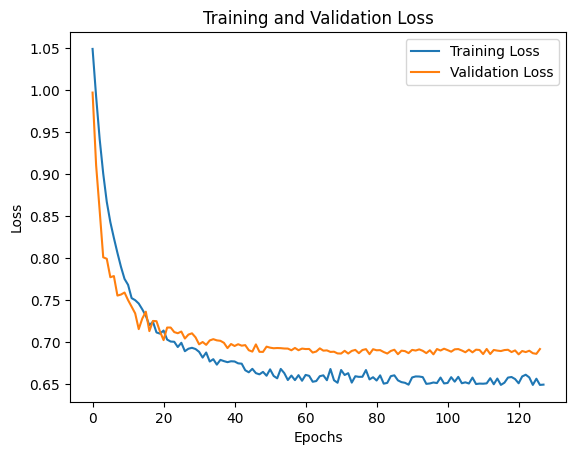

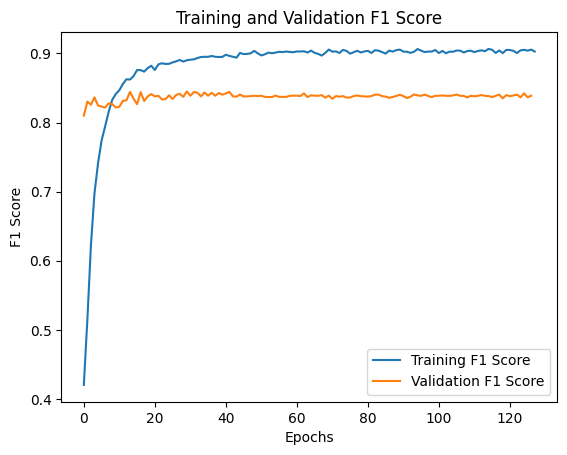

In [ ]:
# Initialize MetaClassifier and move to device
feed_forward_NN = FeedForwardNN().to(device)

# HP definition
num_epochs = 200
batch_size = 128
lr = 1e-5
weight_decay = 1e-2
model_path = "FFNN.pth"

# Training loop
train_metaclassifier(feed_forward_NN, batch_size, num_epochs, lr, weight_decay, train_dataset, val_dataset, model_path)

In [ ]:
FFNN = FeedForwardNN()
FFNN.load_state_dict(torch.load(model_path))
FFNN = FFNN.to(device)
evaluate_metaclassifier(FFNN, test_dataset)


Test Loss: 0.652498741944631
Test Macro F1 Score: 0.8841394696024517
Test Weighted F1 Score: [0.90176322 0.90991444 0.84074074]
Test Accuracy: 0.8972565895642819


As you can see above, even though the model overfits a bit, it reaches extremely good performances!

It is our new standard, and it is still second in the benchmark leaderboard, shortening the distance with the best performing model, which is now just 0.5% F1 above our model!

##### <b>Convolutional NN</b>

Here, I would like to try a Convolutional architecture.</br>The reason behind this choice is the hope that the model could be capable of extracting high-order features concerning the reliability of base models.

Let's try and see!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_1d(nn.Module):
    def __init__(self):
        super(CNN_1d, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, 3)  # Input tensor has shape [batch_size, 1, 6] after the unsqueeze
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.dropout1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv1d(16, 32, 3)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(32 * 2, 64)
        self.dropout3 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        x = x.unsqueeze(1)

        # First Convolutional Layer
        x = F.gelu(self.conv1(x))
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        # Second Convolutional Layer
        x = F.gelu(self.conv2(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FCLayers
        x = F.selu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 0: 100%|██████████| 33/33 [00:00<00:00, 83.68it/s, training_loss=0.527]



Training Loss at end of epoch 0: 1.1094573013710254
Training F1 Score at end of epoch 0: 0.31829032280199643
New best model saved with validation loss: 1.0842182040214539

Validation Loss at end of epoch 0: 1.0842182040214539
Validation Macro F1 Score at end of epoch 0: 0.40640475888718
Validation Weighted F1 Score at end of epoch 0: [0.04133545 0.37256909 0.80530973]


Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 79.05it/s, training_loss=0.614]



Training Loss at end of epoch 1: 1.1034629525560322
Training F1 Score at end of epoch 1: 0.3450334477589096
New best model saved with validation loss: 1.0710169225931168

Validation Loss at end of epoch 1: 1.0710169225931168
Validation Macro F1 Score at end of epoch 1: 0.5305708786927055
Validation Weighted F1 Score at end of epoch 1: [0.00735294 0.77584906 0.80851064]


Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 65.69it/s, training_loss=0.493]



Training Loss at end of epoch 2: 1.0890859004222986
Training F1 Score at end of epoch 2: 0.35727570558043203
New best model saved with validation loss: 1.0590017884969711

Validation Loss at end of epoch 2: 1.0590017884969711
Validation Macro F1 Score at end of epoch 2: 0.5318532382919149
Validation Weighted F1 Score at end of epoch 2: [0.00769231 0.77935677 0.80851064]


Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 74.87it/s, training_loss=0.548]



Training Loss at end of epoch 3: 1.081248604890072
Training F1 Score at end of epoch 3: 0.3766453384286838
New best model saved with validation loss: 1.0487598180770874

Validation Loss at end of epoch 3: 1.0487598180770874
Validation Macro F1 Score at end of epoch 3: 0.5322261709168378
Validation Weighted F1 Score at end of epoch 3: [0.00772201 0.78208955 0.80686695]


Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 70.62it/s, training_loss=0.522]



Training Loss at end of epoch 4: 1.0692538311987212
Training F1 Score at end of epoch 4: 0.4009923904076908
New best model saved with validation loss: 1.0380957871675491

Validation Loss at end of epoch 4: 1.0380957871675491
Validation Macro F1 Score at end of epoch 4: 0.5351598138483386
Validation Weighted F1 Score at end of epoch 4: [0.00772201 0.78390462 0.81385281]


Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 77.26it/s, training_loss=0.547]



Training Loss at end of epoch 5: 1.062862844178171
Training F1 Score at end of epoch 5: 0.42651168072770845
New best model saved with validation loss: 1.0188246667385101

Validation Loss at end of epoch 5: 1.0188246667385101
Validation Macro F1 Score at end of epoch 5: 0.532978680676049
Validation Weighted F1 Score at end of epoch 5: [0.00769231 0.78422619 0.80701754]


Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 74.51it/s, training_loss=0.612]



Training Loss at end of epoch 6: 1.0624816887306445
Training F1 Score at end of epoch 6: 0.43167054393720455
New best model saved with validation loss: 1.0125725716352463

Validation Loss at end of epoch 6: 1.0125725716352463
Validation Macro F1 Score at end of epoch 6: 0.48842179821272486
Validation Weighted F1 Score at end of epoch 6: [0.01532567 0.82742317 0.62251656]


Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 89.00it/s, training_loss=0.541]



Training Loss at end of epoch 7: 1.0460341554699522
Training F1 Score at end of epoch 7: 0.44347303057677673
New best model saved with validation loss: 1.0011862218379974

Validation Loss at end of epoch 7: 1.0011862218379974
Validation Macro F1 Score at end of epoch 7: 0.47420004473153493
Validation Weighted F1 Score at end of epoch 7: [0.02307692 0.86019737 0.53932584]


Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 81.31it/s, training_loss=0.510]



Training Loss at end of epoch 8: 1.0333571470145024
Training F1 Score at end of epoch 8: 0.47493532857518517
New best model saved with validation loss: 0.9897692278027534

Validation Loss at end of epoch 8: 0.9897692278027534
Validation Macro F1 Score at end of epoch 8: 0.49198673717156555
Validation Weighted F1 Score at end of epoch 8: [0.08058608 0.86934673 0.5260274 ]


Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 69.73it/s, training_loss=0.521]



Training Loss at end of epoch 9: 1.0263075250567812
Training F1 Score at end of epoch 9: 0.4888837513668844
New best model saved with validation loss: 0.974902056157589

Validation Loss at end of epoch 9: 0.974902056157589
Validation Macro F1 Score at end of epoch 9: 0.6541614045452003
Validation Weighted F1 Score at end of epoch 9: [0.47093023 0.88395904 0.60759494]


Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 65.53it/s, training_loss=0.449]



Training Loss at end of epoch 10: 1.0134511102329602
Training F1 Score at end of epoch 10: 0.5112704816656647
New best model saved with validation loss: 0.9619766995310783

Validation Loss at end of epoch 10: 0.9619766995310783
Validation Macro F1 Score at end of epoch 10: 0.8231249715387302
Validation Weighted F1 Score at end of epoch 10: [0.77727273 0.88679245 0.80530973]


Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 70.69it/s, training_loss=0.480]



Training Loss at end of epoch 11: 1.0082437937909907
Training F1 Score at end of epoch 11: 0.5160722144265146
New best model saved with validation loss: 0.9525200873613358

Validation Loss at end of epoch 11: 0.9525200873613358
Validation Macro F1 Score at end of epoch 11: 0.8429528668240311
Validation Weighted F1 Score at end of epoch 11: [0.81304348 0.89842382 0.8173913 ]


Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 72.66it/s, training_loss=0.438]



Training Loss at end of epoch 12: 0.9963958299521244
Training F1 Score at end of epoch 12: 0.5366334277264301
New best model saved with validation loss: 0.9462370499968529

Validation Loss at end of epoch 12: 0.9462370499968529
Validation Macro F1 Score at end of epoch 12: 0.8356864484521013
Validation Weighted F1 Score at end of epoch 12: [0.79735683 0.89391304 0.81578947]


Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 69.81it/s, training_loss=0.459]



Training Loss at end of epoch 13: 0.9826627283385305
Training F1 Score at end of epoch 13: 0.572260928998109
New best model saved with validation loss: 0.92812380194664

Validation Loss at end of epoch 13: 0.92812380194664
Validation Macro F1 Score at end of epoch 13: 0.8385571100569114
Validation Weighted F1 Score at end of epoch 13: [0.81290323 0.89745837 0.80530973]


Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 65.17it/s, training_loss=0.526]



Training Loss at end of epoch 14: 0.982427716255188
Training F1 Score at end of epoch 14: 0.5795974844857544
New best model saved with validation loss: 0.9163276106119156

Validation Loss at end of epoch 14: 0.9163276106119156
Validation Macro F1 Score at end of epoch 14: 0.8375996831969207
Validation Weighted F1 Score at end of epoch 14: [0.80842105 0.89380531 0.81057269]


Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 66.59it/s, training_loss=0.514]



Training Loss at end of epoch 15: 0.9720247496258129
Training F1 Score at end of epoch 15: 0.5942454018616792
New best model saved with validation loss: 0.9090884178876877

Validation Loss at end of epoch 15: 0.9090884178876877
Validation Macro F1 Score at end of epoch 15: 0.8380674841744877
Validation Weighted F1 Score at end of epoch 15: [0.81276596 0.89612676 0.80530973]


Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 61.14it/s, training_loss=0.596]



Training Loss at end of epoch 16: 0.9712707165515784
Training F1 Score at end of epoch 16: 0.5993028658812242
New best model saved with validation loss: 0.8985385820269585

Validation Loss at end of epoch 16: 0.8985385820269585
Validation Macro F1 Score at end of epoch 16: 0.8410060137056549
Validation Weighted F1 Score at end of epoch 16: [0.81263158 0.89459699 0.81578947]


Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 90.08it/s, training_loss=0.460]



Training Loss at end of epoch 17: 0.9542457082054832
Training F1 Score at end of epoch 17: 0.6165123540214816
New best model saved with validation loss: 0.8878066912293434

Validation Loss at end of epoch 17: 0.8878066912293434
Validation Macro F1 Score at end of epoch 17: 0.8356504641728266
Validation Weighted F1 Score at end of epoch 17: [0.81355932 0.89339207 0.8       ]


Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 86.34it/s, training_loss=0.562]



Training Loss at end of epoch 18: 0.9526342171611208
Training F1 Score at end of epoch 18: 0.6329216115557473
New best model saved with validation loss: 0.8808668553829193

Validation Loss at end of epoch 18: 0.8808668553829193
Validation Macro F1 Score at end of epoch 18: 0.8415405842699122
Validation Weighted F1 Score at end of epoch 18: [0.81893004 0.89346464 0.81222707]


Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 92.89it/s, training_loss=0.416]



Training Loss at end of epoch 19: 0.9339022293235316
Training F1 Score at end of epoch 19: 0.6573513466358448
New best model saved with validation loss: 0.8705669566988945

Validation Loss at end of epoch 19: 0.8705669566988945
Validation Macro F1 Score at end of epoch 19: 0.838359520698471
Validation Weighted F1 Score at end of epoch 19: [0.81573499 0.89403384 0.80530973]


Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 85.19it/s, training_loss=0.489]



Training Loss at end of epoch 20: 0.9283690362265615
Training F1 Score at end of epoch 20: 0.6679802278871195
New best model saved with validation loss: 0.855752483010292

Validation Loss at end of epoch 20: 0.855752483010292
Validation Macro F1 Score at end of epoch 20: 0.8428713830029619
Validation Weighted F1 Score at end of epoch 20: [0.81818182 0.89464286 0.81578947]


Epoch 21: 100%|██████████| 33/33 [00:00<00:00, 97.83it/s, training_loss=0.542]



Training Loss at end of epoch 21: 0.926257767460563
Training F1 Score at end of epoch 21: 0.6742478421895712
New best model saved with validation loss: 0.8539083898067474

Validation Loss at end of epoch 21: 0.8539083898067474
Validation Macro F1 Score at end of epoch 21: 0.8406779703502969
Validation Weighted F1 Score at end of epoch 21: [0.81742739 0.89403384 0.81057269]


Epoch 22: 100%|██████████| 33/33 [00:00<00:00, 88.21it/s, training_loss=0.404]



Training Loss at end of epoch 22: 0.9084910154342651
Training F1 Score at end of epoch 22: 0.6929724242484956
New best model saved with validation loss: 0.8450201004743576

Validation Loss at end of epoch 22: 0.8450201004743576
Validation Macro F1 Score at end of epoch 22: 0.8430579658876499
Validation Weighted F1 Score at end of epoch 22: [0.81893004 0.89445438 0.81578947]


Epoch 23: 100%|██████████| 33/33 [00:00<00:00, 77.26it/s, training_loss=0.421]



Training Loss at end of epoch 23: 0.8995142163652362
Training F1 Score at end of epoch 23: 0.706702591801203
New best model saved with validation loss: 0.8402196168899536

Validation Loss at end of epoch 23: 0.8402196168899536
Validation Macro F1 Score at end of epoch 23: 0.8415689468968249
Validation Weighted F1 Score at end of epoch 23: [0.82281059 0.89487871 0.80701754]


Epoch 24: 100%|██████████| 33/33 [00:00<00:00, 81.71it/s, training_loss=0.390]



Training Loss at end of epoch 24: 0.893693745136261
Training F1 Score at end of epoch 24: 0.7125369716878541
New best model saved with validation loss: 0.8280873149633408

Validation Loss at end of epoch 24: 0.8280873149633408
Validation Macro F1 Score at end of epoch 24: 0.840866428950542
Validation Weighted F1 Score at end of epoch 24: [0.81818182 0.89384478 0.81057269]


Epoch 25: 100%|██████████| 33/33 [00:00<00:00, 81.46it/s, training_loss=0.487]



Training Loss at end of epoch 25: 0.8916310722177679
Training F1 Score at end of epoch 25: 0.7251125914195488
New best model saved with validation loss: 0.8208638653159142

Validation Loss at end of epoch 25: 0.8208638653159142
Validation Macro F1 Score at end of epoch 25: 0.8444929235050121
Validation Weighted F1 Score at end of epoch 25: [0.82281059 0.89487871 0.81578947]


Epoch 26: 100%|██████████| 33/33 [00:00<00:00, 78.37it/s, training_loss=0.510]



Training Loss at end of epoch 26: 0.8850514509461143
Training F1 Score at end of epoch 26: 0.7338653087041836
New best model saved with validation loss: 0.8152273446321487

Validation Loss at end of epoch 26: 0.8152273446321487
Validation Macro F1 Score at end of epoch 26: 0.8430579658876499
Validation Weighted F1 Score at end of epoch 26: [0.81893004 0.89445438 0.81578947]


Epoch 27: 100%|██████████| 33/33 [00:00<00:00, 71.98it/s, training_loss=0.580]



Training Loss at end of epoch 27: 0.8860464637929742
Training F1 Score at end of epoch 27: 0.7354839923415093
New best model saved with validation loss: 0.8086920231580734

Validation Loss at end of epoch 27: 0.8086920231580734
Validation Macro F1 Score at end of epoch 27: 0.8375182943566601
Validation Weighted F1 Score at end of epoch 27: [0.81912682 0.89342806 0.8       ]


Epoch 28: 100%|██████████| 33/33 [00:00<00:00, 82.56it/s, training_loss=0.309]



Training Loss at end of epoch 28: 0.8613942157138478
Training F1 Score at end of epoch 28: 0.7530205466689455
New best model saved with validation loss: 0.8004894703626633

Validation Loss at end of epoch 28: 0.8004894703626633
Validation Macro F1 Score at end of epoch 28: 0.8410525925093202
Validation Weighted F1 Score at end of epoch 28: [0.81893004 0.89365505 0.81057269]


Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 80.56it/s, training_loss=0.407]



Training Loss at end of epoch 29: 0.859727680683136
Training F1 Score at end of epoch 29: 0.7658634170539456
New best model saved with validation loss: 0.7955911308526993

Validation Loss at end of epoch 29: 0.7955911308526993
Validation Macro F1 Score at end of epoch 29: 0.84520577105258
Validation Weighted F1 Score at end of epoch 29: [0.82377049 0.89605735 0.81578947]


Epoch 30: 100%|██████████| 33/33 [00:00<00:00, 79.50it/s, training_loss=0.469]



Training Loss at end of epoch 30: 0.8565068064313947
Training F1 Score at end of epoch 30: 0.7726000533832829
New best model saved with validation loss: 0.7860243991017342

Validation Loss at end of epoch 30: 0.7860243991017342
Validation Macro F1 Score at end of epoch 30: 0.8442686346718583
Validation Weighted F1 Score at end of epoch 30: [0.82617587 0.89605735 0.81057269]


Epoch 31: 100%|██████████| 33/33 [00:00<00:00, 75.48it/s, training_loss=0.534]



Training Loss at end of epoch 31: 0.8583952260739875
Training F1 Score at end of epoch 31: 0.7624032963837362
New best model saved with validation loss: 0.7841491773724556

Validation Loss at end of epoch 31: 0.7841491773724556
Validation Macro F1 Score at end of epoch 31: 0.840174449948373
Validation Weighted F1 Score at end of epoch 31: [0.82113821 0.8940754  0.80530973]


Epoch 32: 100%|██████████| 33/33 [00:00<00:00, 86.93it/s, training_loss=0.735]



Training Loss at end of epoch 32: 0.8637676871184147
Training F1 Score at end of epoch 32: 0.779010807805975
New best model saved with validation loss: 0.777555026113987

Validation Loss at end of epoch 32: 0.777555026113987
Validation Macro F1 Score at end of epoch 32: 0.8390323061742269
Validation Weighted F1 Score at end of epoch 32: [0.81893004 0.89285714 0.80530973]


Epoch 33: 100%|██████████| 33/33 [00:00<00:00, 77.94it/s, training_loss=0.329]



Training Loss at end of epoch 33: 0.8335614999135336
Training F1 Score at end of epoch 33: 0.7830992772082954

Validation Loss at end of epoch 33: 0.7780424505472183
Validation Macro F1 Score at end of epoch 33: 0.8390323061742269
Validation Weighted F1 Score at end of epoch 33: [0.81893004 0.89285714 0.80530973]


Epoch 34: 100%|██████████| 33/33 [00:00<00:00, 80.47it/s, training_loss=0.373]



Training Loss at end of epoch 34: 0.8303685675967823
Training F1 Score at end of epoch 34: 0.7883277803423642
New best model saved with validation loss: 0.7704652026295662

Validation Loss at end of epoch 34: 0.7704652026295662
Validation Macro F1 Score at end of epoch 34: 0.8424862272685884
Validation Weighted F1 Score at end of epoch 34: [0.82281059 0.8940754  0.81057269]


Epoch 35: 100%|██████████| 33/33 [00:00<00:00, 105.76it/s, training_loss=0.401]



Training Loss at end of epoch 35: 0.827930257175908
Training F1 Score at end of epoch 35: 0.7969171657924417
New best model saved with validation loss: 0.767021432518959

Validation Loss at end of epoch 35: 0.767021432518959
Validation Macro F1 Score at end of epoch 35: 0.8390323061742269
Validation Weighted F1 Score at end of epoch 35: [0.81893004 0.89285714 0.80530973]


Epoch 36: 100%|██████████| 33/33 [00:00<00:00, 103.03it/s, training_loss=0.365]



Training Loss at end of epoch 36: 0.8201509768312628
Training F1 Score at end of epoch 36: 0.7971772992385615
New best model saved with validation loss: 0.7610303089022636

Validation Loss at end of epoch 36: 0.7610303089022636
Validation Macro F1 Score at end of epoch 36: 0.8402100839823768
Validation Weighted F1 Score at end of epoch 36: [0.82617587 0.89445438 0.8       ]


Epoch 37: 100%|██████████| 33/33 [00:00<00:00, 103.83it/s, training_loss=0.360]



Training Loss at end of epoch 37: 0.8144748499899199
Training F1 Score at end of epoch 37: 0.8067880394272917
New best model saved with validation loss: 0.7584379985928535

Validation Loss at end of epoch 37: 0.7584379985928535
Validation Macro F1 Score at end of epoch 37: 0.8390323061742269
Validation Weighted F1 Score at end of epoch 37: [0.81893004 0.89285714 0.80530973]


Epoch 38: 100%|██████████| 33/33 [00:00<00:00, 108.76it/s, training_loss=0.491]



Training Loss at end of epoch 38: 0.8164958989981449
Training F1 Score at end of epoch 38: 0.8093055380478981
New best model saved with validation loss: 0.755622573196888

Validation Loss at end of epoch 38: 0.755622573196888
Validation Macro F1 Score at end of epoch 38: 0.845558726318047
Validation Weighted F1 Score at end of epoch 38: [0.82520325 0.89568345 0.81578947]


Epoch 39: 100%|██████████| 33/33 [00:00<00:00, 102.36it/s, training_loss=0.341]



Training Loss at end of epoch 39: 0.8010552019783945
Training F1 Score at end of epoch 39: 0.8159046389272436
New best model saved with validation loss: 0.7505002170801163

Validation Loss at end of epoch 39: 0.7505002170801163
Validation Macro F1 Score at end of epoch 39: 0.8381372513276703
Validation Weighted F1 Score at end of epoch 39: [0.82113821 0.89327354 0.8       ]


Epoch 40: 100%|██████████| 33/33 [00:00<00:00, 108.16it/s, training_loss=0.520]



Training Loss at end of epoch 40: 0.8107271935000564
Training F1 Score at end of epoch 40: 0.8171759254981691
New best model saved with validation loss: 0.7455386593937874

Validation Loss at end of epoch 40: 0.7455386593937874
Validation Macro F1 Score at end of epoch 40: 0.8401066732679775
Validation Weighted F1 Score at end of epoch 40: [0.82135524 0.89365505 0.80530973]


Epoch 41: 100%|██████████| 33/33 [00:00<00:00, 100.62it/s, training_loss=0.413]



Training Loss at end of epoch 41: 0.7991092710783987
Training F1 Score at end of epoch 41: 0.822172464834188
New best model saved with validation loss: 0.743078738451004

Validation Loss at end of epoch 41: 0.743078738451004
Validation Macro F1 Score at end of epoch 41: 0.8415294634985085
Validation Weighted F1 Score at end of epoch 41: [0.82520325 0.8940754  0.80530973]


Epoch 42: 100%|██████████| 33/33 [00:00<00:00, 102.86it/s, training_loss=0.492]



Training Loss at end of epoch 42: 0.7980042695999146
Training F1 Score at end of epoch 42: 0.8253205776399491

Validation Loss at end of epoch 42: 0.7441915273666382
Validation Macro F1 Score at end of epoch 42: 0.8369969004257172
Validation Weighted F1 Score at end of epoch 42: [0.81893004 0.89206066 0.8       ]


Epoch 43: 100%|██████████| 33/33 [00:00<00:00, 108.23it/s, training_loss=0.432]



Training Loss at end of epoch 43: 0.7911601771007885
Training F1 Score at end of epoch 43: 0.8319323871867673
New best model saved with validation loss: 0.7358562797307968

Validation Loss at end of epoch 43: 0.7358562797307968
Validation Macro F1 Score at end of epoch 43: 0.8415294634985085
Validation Weighted F1 Score at end of epoch 43: [0.82520325 0.8940754  0.80530973]


Epoch 44: 100%|██████████| 33/33 [00:00<00:00, 107.60it/s, training_loss=0.423]



Training Loss at end of epoch 44: 0.7860765330719225
Training F1 Score at end of epoch 44: 0.8378740442818332

Validation Loss at end of epoch 44: 0.7376099601387978
Validation Macro F1 Score at end of epoch 44: 0.8389957749453157
Validation Weighted F1 Score at end of epoch 44: [0.82135524 0.89206066 0.80357143]


Epoch 45: 100%|██████████| 33/33 [00:00<00:00, 103.85it/s, training_loss=0.400]



Training Loss at end of epoch 45: 0.7800399390133944
Training F1 Score at end of epoch 45: 0.8448263439696326

Validation Loss at end of epoch 45: 0.7365639433264732
Validation Macro F1 Score at end of epoch 45: 0.8390323061742269
Validation Weighted F1 Score at end of epoch 45: [0.81893004 0.89285714 0.80530973]


Epoch 46: 100%|██████████| 33/33 [00:00<00:00, 106.57it/s, training_loss=0.356]



Training Loss at end of epoch 46: 0.7742817040645715
Training F1 Score at end of epoch 46: 0.8431944693444882
New best model saved with validation loss: 0.7350888922810555

Validation Loss at end of epoch 46: 0.7350888922810555
Validation Macro F1 Score at end of epoch 46: 0.8401066732679775
Validation Weighted F1 Score at end of epoch 46: [0.82135524 0.89365505 0.80530973]


Epoch 47: 100%|██████████| 33/33 [00:00<00:00, 108.00it/s, training_loss=0.377]



Training Loss at end of epoch 47: 0.7734587499589631
Training F1 Score at end of epoch 47: 0.8376834260859786
New best model saved with validation loss: 0.7286734133958817

Validation Loss at end of epoch 47: 0.7286734133958817
Validation Macro F1 Score at end of epoch 47: 0.8422469171170094
Validation Weighted F1 Score at end of epoch 47: [0.82617587 0.89525515 0.80530973]


Epoch 48: 100%|██████████| 33/33 [00:00<00:00, 99.84it/s, training_loss=0.450] 



Training Loss at end of epoch 48: 0.7724965286977363
Training F1 Score at end of epoch 48: 0.8439770867813815
New best model saved with validation loss: 0.725452333688736

Validation Loss at end of epoch 48: 0.725452333688736
Validation Macro F1 Score at end of epoch 48: 0.8393181444466776
Validation Weighted F1 Score at end of epoch 48: [0.8244898  0.89346464 0.8       ]


Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 104.23it/s, training_loss=0.303]



Training Loss at end of epoch 49: 0.7606557950829015
Training F1 Score at end of epoch 49: 0.8532325642282123
New best model saved with validation loss: 0.7238022536039352

Validation Loss at end of epoch 49: 0.7238022536039352
Validation Macro F1 Score at end of epoch 49: 0.8380707929989244
Validation Weighted F1 Score at end of epoch 49: [0.82135524 0.89285714 0.8       ]


Epoch 50: 100%|██████████| 33/33 [00:00<00:00, 99.51it/s, training_loss=0.372]



Training Loss at end of epoch 50: 0.7629052129658785
Training F1 Score at end of epoch 50: 0.8497044689293386
New best model saved with validation loss: 0.7236952632665634

Validation Loss at end of epoch 50: 0.7236952632665634
Validation Macro F1 Score at end of epoch 50: 0.8400663544106166
Validation Weighted F1 Score at end of epoch 50: [0.82377049 0.89285714 0.80357143]


Epoch 51: 100%|██████████| 33/33 [00:00<00:00, 106.41it/s, training_loss=0.540]



Training Loss at end of epoch 51: 0.7697017445708766
Training F1 Score at end of epoch 51: 0.846301649901975
New best model saved with validation loss: 0.7206333801150322

Validation Loss at end of epoch 51: 0.7206333801150322
Validation Macro F1 Score at end of epoch 51: 0.8380707929989244
Validation Weighted F1 Score at end of epoch 51: [0.82135524 0.89285714 0.8       ]


Epoch 52: 100%|██████████| 33/33 [00:00<00:00, 104.62it/s, training_loss=0.516]



Training Loss at end of epoch 52: 0.763574789870869
Training F1 Score at end of epoch 52: 0.858309769713971
New best model saved with validation loss: 0.7176001518964767

Validation Loss at end of epoch 52: 0.7176001518964767
Validation Macro F1 Score at end of epoch 52: 0.8415294634985085
Validation Weighted F1 Score at end of epoch 52: [0.82520325 0.8940754  0.80530973]


Epoch 53: 100%|██████████| 33/33 [00:00<00:00, 99.23it/s, training_loss=0.287]



Training Loss at end of epoch 53: 0.7481556029030771
Training F1 Score at end of epoch 53: 0.8561935736581224

Validation Loss at end of epoch 53: 0.7216160744428635
Validation Macro F1 Score at end of epoch 53: 0.8401066732679775
Validation Weighted F1 Score at end of epoch 53: [0.82135524 0.89365505 0.80530973]


Epoch 54: 100%|██████████| 33/33 [00:00<00:00, 105.85it/s, training_loss=0.392]



Training Loss at end of epoch 54: 0.7502425710360209
Training F1 Score at end of epoch 54: 0.8579260922372621

Validation Loss at end of epoch 54: 0.7196987569332123
Validation Macro F1 Score at end of epoch 54: 0.8380707929989244
Validation Weighted F1 Score at end of epoch 54: [0.82135524 0.89285714 0.8       ]


Epoch 55: 100%|██████████| 33/33 [00:00<00:00, 97.24it/s, training_loss=0.368]



Training Loss at end of epoch 55: 0.7477798209045873
Training F1 Score at end of epoch 55: 0.8595658022498739
New best model saved with validation loss: 0.7153953909873962

Validation Loss at end of epoch 55: 0.7153953909873962
Validation Macro F1 Score at end of epoch 55: 0.8435515484855504
Validation Weighted F1 Score at end of epoch 55: [0.82520325 0.89487871 0.81057269]


Epoch 56: 100%|██████████| 33/33 [00:00<00:00, 106.18it/s, training_loss=0.347]



Training Loss at end of epoch 56: 0.7437493945613052
Training F1 Score at end of epoch 56: 0.8571107635167939
New best model saved with validation loss: 0.7144912555813789

Validation Loss at end of epoch 56: 0.7144912555813789
Validation Macro F1 Score at end of epoch 56: 0.8422469171170094
Validation Weighted F1 Score at end of epoch 56: [0.82617587 0.89525515 0.80530973]


Epoch 57: 100%|██████████| 33/33 [00:00<00:00, 96.40it/s, training_loss=0.313]



Training Loss at end of epoch 57: 0.7399979035059611
Training F1 Score at end of epoch 57: 0.8612059468539282

Validation Loss at end of epoch 57: 0.7146595492959023
Validation Macro F1 Score at end of epoch 57: 0.8422469171170094
Validation Weighted F1 Score at end of epoch 57: [0.82617587 0.89525515 0.80530973]


Epoch 58: 100%|██████████| 33/33 [00:00<00:00, 105.88it/s, training_loss=0.325]



Training Loss at end of epoch 58: 0.737840058225574
Training F1 Score at end of epoch 58: 0.8593464486961402
New best model saved with validation loss: 0.7106769159436226

Validation Loss at end of epoch 58: 0.7106769159436226
Validation Macro F1 Score at end of epoch 58: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 58: [0.82758621 0.89487871 0.80530973]


Epoch 59: 100%|██████████| 33/33 [00:00<00:00, 99.09it/s, training_loss=0.377]



Training Loss at end of epoch 59: 0.7362980463288047
Training F1 Score at end of epoch 59: 0.8663093386853048
New best model saved with validation loss: 0.7089320421218872

Validation Loss at end of epoch 59: 0.7089320421218872
Validation Macro F1 Score at end of epoch 59: 0.8432612688103647
Validation Weighted F1 Score at end of epoch 59: [0.83095723 0.89525515 0.80357143]


Epoch 60: 100%|██████████| 33/33 [00:00<00:00, 106.17it/s, training_loss=0.310]



Training Loss at end of epoch 60: 0.7336101604230476
Training F1 Score at end of epoch 60: 0.85932572113511

Validation Loss at end of epoch 60: 0.7107077389955521
Validation Macro F1 Score at end of epoch 60: 0.842368318076422
Validation Weighted F1 Score at end of epoch 60: [0.82926829 0.89426523 0.80357143]


Epoch 61: 100%|██████████| 33/33 [00:00<00:00, 95.20it/s, training_loss=0.613]



Training Loss at end of epoch 61: 0.7475988539782438
Training F1 Score at end of epoch 61: 0.864281185265552
New best model saved with validation loss: 0.7060787305235863

Validation Loss at end of epoch 61: 0.7060787305235863
Validation Macro F1 Score at end of epoch 61: 0.8415294634985085
Validation Weighted F1 Score at end of epoch 61: [0.82520325 0.8940754  0.80530973]


Epoch 62: 100%|██████████| 33/33 [00:00<00:00, 79.90it/s, training_loss=0.347]



Training Loss at end of epoch 62: 0.7286218711824128
Training F1 Score at end of epoch 62: 0.8684318069928253

Validation Loss at end of epoch 62: 0.7081941589713097
Validation Macro F1 Score at end of epoch 62: 0.8422469171170094
Validation Weighted F1 Score at end of epoch 62: [0.82617587 0.89525515 0.80530973]


Epoch 63: 100%|██████████| 33/33 [00:00<00:00, 83.89it/s, training_loss=0.361]



Training Loss at end of epoch 63: 0.728638464754278
Training F1 Score at end of epoch 63: 0.866470279947845
New best model saved with validation loss: 0.7049560099840164

Validation Loss at end of epoch 63: 0.7049560099840164
Validation Macro F1 Score at end of epoch 63: 0.8369969004257172
Validation Weighted F1 Score at end of epoch 63: [0.81893004 0.89206066 0.8       ]


Epoch 64: 100%|██████████| 33/33 [00:00<00:00, 77.51it/s, training_loss=0.369]



Training Loss at end of epoch 64: 0.7265134345401417
Training F1 Score at end of epoch 64: 0.868415948878606
New best model saved with validation loss: 0.7028429284691811

Validation Loss at end of epoch 64: 0.7028429284691811
Validation Macro F1 Score at end of epoch 64: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 64: [0.82758621 0.89487871 0.80530973]


Epoch 65: 100%|██████████| 33/33 [00:00<00:00, 90.18it/s, training_loss=0.609]



Training Loss at end of epoch 65: 0.7390455061739142
Training F1 Score at end of epoch 65: 0.8699603183298258
New best model saved with validation loss: 0.7019422724843025

Validation Loss at end of epoch 65: 0.7019422724843025
Validation Macro F1 Score at end of epoch 65: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 65: [0.82758621 0.89487871 0.80530973]


Epoch 66: 100%|██████████| 33/33 [00:00<00:00, 84.11it/s, training_loss=0.316]



Training Loss at end of epoch 66: 0.7201487548423536
Training F1 Score at end of epoch 66: 0.8700072707455339

Validation Loss at end of epoch 66: 0.703875444829464
Validation Macro F1 Score at end of epoch 66: 0.8401066732679775
Validation Weighted F1 Score at end of epoch 66: [0.82135524 0.89365505 0.80530973]


Epoch 67: 100%|██████████| 33/33 [00:00<00:00, 87.26it/s, training_loss=0.477]



Training Loss at end of epoch 67: 0.725209218083006
Training F1 Score at end of epoch 67: 0.8745188106672678
New best model saved with validation loss: 0.6998185738921165

Validation Loss at end of epoch 67: 0.6998185738921165
Validation Macro F1 Score at end of epoch 67: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 67: [0.82758621 0.89487871 0.80530973]


Epoch 68: 100%|██████████| 33/33 [00:00<00:00, 92.97it/s, training_loss=0.531]



Training Loss at end of epoch 68: 0.726870930556095
Training F1 Score at end of epoch 68: 0.8757835126802357

Validation Loss at end of epoch 68: 0.7008476555347443
Validation Macro F1 Score at end of epoch 68: 0.842420303158077
Validation Weighted F1 Score at end of epoch 68: [0.82688391 0.89506726 0.80530973]


Epoch 69: 100%|██████████| 33/33 [00:00<00:00, 84.89it/s, training_loss=0.290]



Training Loss at end of epoch 69: 0.7113102006189751
Training F1 Score at end of epoch 69: 0.8764072208562766

Validation Loss at end of epoch 69: 0.7005287408828735
Validation Macro F1 Score at end of epoch 69: 0.8414770593562925
Validation Weighted F1 Score at end of epoch 69: [0.82758621 0.89327354 0.80357143]


Epoch 70: 100%|██████████| 33/33 [00:00<00:00, 87.58it/s, training_loss=0.304]



Training Loss at end of epoch 70: 0.7135959990096815
Training F1 Score at end of epoch 70: 0.8667601661918102
New best model saved with validation loss: 0.6992966830730438

Validation Loss at end of epoch 70: 0.6992966830730438
Validation Macro F1 Score at end of epoch 70: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 70: [0.82758621 0.89487871 0.80530973]


Epoch 71: 100%|██████████| 33/33 [00:00<00:00, 87.71it/s, training_loss=0.381]



Training Loss at end of epoch 71: 0.7146341529759493
Training F1 Score at end of epoch 71: 0.8752023087511661
New best model saved with validation loss: 0.6979822516441345

Validation Loss at end of epoch 71: 0.6979822516441345
Validation Macro F1 Score at end of epoch 71: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 71: [0.82591093 0.89388489 0.80530973]


Epoch 72: 100%|██████████| 33/33 [00:00<00:00, 79.60it/s, training_loss=0.356]



Training Loss at end of epoch 72: 0.7115563425150785
Training F1 Score at end of epoch 72: 0.8794793177389634
New best model saved with validation loss: 0.6978560537099838

Validation Loss at end of epoch 72: 0.6978560537099838
Validation Macro F1 Score at end of epoch 72: 0.8401066732679775
Validation Weighted F1 Score at end of epoch 72: [0.82135524 0.89365505 0.80530973]


Epoch 73: 100%|██████████| 33/33 [00:00<00:00, 80.65it/s, training_loss=0.478]



Training Loss at end of epoch 73: 0.7167791850639113
Training F1 Score at end of epoch 73: 0.8725890965944482
New best model saved with validation loss: 0.6969127580523491

Validation Loss at end of epoch 73: 0.6969127580523491
Validation Macro F1 Score at end of epoch 73: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 73: [0.82591093 0.89388489 0.80530973]


Epoch 74: 100%|██████████| 33/33 [00:00<00:00, 85.61it/s, training_loss=0.398]



Training Loss at end of epoch 74: 0.7116426717151295
Training F1 Score at end of epoch 74: 0.8754103503977343

Validation Loss at end of epoch 74: 0.6975747793912888
Validation Macro F1 Score at end of epoch 74: 0.8400663544106166
Validation Weighted F1 Score at end of epoch 74: [0.82377049 0.89285714 0.80357143]


Epoch 75: 100%|██████████| 33/33 [00:00<00:00, 70.27it/s, training_loss=0.319]



Training Loss at end of epoch 75: 0.7029757409384756
Training F1 Score at end of epoch 75: 0.8804811278677341
New best model saved with validation loss: 0.6960977092385292

Validation Loss at end of epoch 75: 0.6960977092385292
Validation Macro F1 Score at end of epoch 75: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 75: [0.82758621 0.89487871 0.80530973]


Epoch 76: 100%|██████████| 33/33 [00:00<00:00, 79.53it/s, training_loss=0.294]



Training Loss at end of epoch 76: 0.7013655810645132
Training F1 Score at end of epoch 76: 0.8774863553840276

Validation Loss at end of epoch 76: 0.6962528377771378
Validation Macro F1 Score at end of epoch 76: 0.8411782030476763
Validation Weighted F1 Score at end of epoch 76: [0.82377049 0.89445438 0.80530973]


Epoch 77: 100%|██████████| 33/33 [00:01<00:00, 31.16it/s, training_loss=0.507]



Training Loss at end of epoch 77: 0.7140624794093046
Training F1 Score at end of epoch 77: 0.873907122265254
New best model saved with validation loss: 0.6944767087697983

Validation Loss at end of epoch 77: 0.6944767087697983
Validation Macro F1 Score at end of epoch 77: 0.8422469171170094
Validation Weighted F1 Score at end of epoch 77: [0.82617587 0.89525515 0.80530973]


Epoch 78: 100%|██████████| 33/33 [00:00<00:00, 76.51it/s, training_loss=0.310]



Training Loss at end of epoch 78: 0.6995402068802805
Training F1 Score at end of epoch 78: 0.8779590672455103

Validation Loss at end of epoch 78: 0.6948213577270508
Validation Macro F1 Score at end of epoch 78: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 78: [0.82591093 0.89388489 0.80530973]


Epoch 79: 100%|██████████| 33/33 [00:00<00:00, 87.32it/s, training_loss=0.333]



Training Loss at end of epoch 79: 0.698753813902537
Training F1 Score at end of epoch 79: 0.8838980064665346
New best model saved with validation loss: 0.693979874253273

Validation Loss at end of epoch 79: 0.693979874253273
Validation Macro F1 Score at end of epoch 79: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 79: [0.82591093 0.89388489 0.80530973]


Epoch 80: 100%|██████████| 33/33 [00:00<00:00, 102.04it/s, training_loss=0.433]



Training Loss at end of epoch 80: 0.7053873683467056
Training F1 Score at end of epoch 80: 0.8781474235627297

Validation Loss at end of epoch 80: 0.6949571892619133
Validation Macro F1 Score at end of epoch 80: 0.8401066732679775
Validation Weighted F1 Score at end of epoch 80: [0.82135524 0.89365505 0.80530973]


Epoch 81: 100%|██████████| 33/33 [00:00<00:00, 102.67it/s, training_loss=0.319]



Training Loss at end of epoch 81: 0.6968422784949794
Training F1 Score at end of epoch 81: 0.8776960875553278
New best model saved with validation loss: 0.693162314593792

Validation Loss at end of epoch 81: 0.693162314593792
Validation Macro F1 Score at end of epoch 81: 0.8422469171170094
Validation Weighted F1 Score at end of epoch 81: [0.82617587 0.89525515 0.80530973]


Epoch 82: 100%|██████████| 33/33 [00:00<00:00, 100.72it/s, training_loss=0.313]



Training Loss at end of epoch 82: 0.6945544698021628
Training F1 Score at end of epoch 82: 0.8819864287020517
New best model saved with validation loss: 0.6931167244911194

Validation Loss at end of epoch 82: 0.6931167244911194
Validation Macro F1 Score at end of epoch 82: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 82: [0.82591093 0.89388489 0.80530973]


Epoch 83: 100%|██████████| 33/33 [00:00<00:00, 99.24it/s, training_loss=0.312]



Training Loss at end of epoch 83: 0.6942631566163265
Training F1 Score at end of epoch 83: 0.8808864698980186
New best model saved with validation loss: 0.6914729177951813

Validation Loss at end of epoch 83: 0.6914729177951813
Validation Macro F1 Score at end of epoch 83: 0.8434272317246058
Validation Weighted F1 Score at end of epoch 83: [0.831643   0.89506726 0.80357143]


Epoch 84: 100%|██████████| 33/33 [00:00<00:00, 97.31it/s, training_loss=0.339]



Training Loss at end of epoch 84: 0.6959652268525326
Training F1 Score at end of epoch 84: 0.8767432009718794

Validation Loss at end of epoch 84: 0.69168970733881
Validation Macro F1 Score at end of epoch 84: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 84: [0.82591093 0.89388489 0.80530973]


Epoch 85: 100%|██████████| 33/33 [00:00<00:00, 98.33it/s, training_loss=0.302]



Training Loss at end of epoch 85: 0.6909224661913785
Training F1 Score at end of epoch 85: 0.8773101025257132
New best model saved with validation loss: 0.6906032711267471

Validation Loss at end of epoch 85: 0.6906032711267471
Validation Macro F1 Score at end of epoch 85: 0.8445757030861301
Validation Weighted F1 Score at end of epoch 85: [0.82995951 0.89487871 0.80888889]


Epoch 86: 100%|██████████| 33/33 [00:00<00:00, 100.03it/s, training_loss=0.283]



Training Loss at end of epoch 86: 0.688749479525017
Training F1 Score at end of epoch 86: 0.8820832333987755
New best model saved with validation loss: 0.6900906413793564

Validation Loss at end of epoch 86: 0.6900906413793564
Validation Macro F1 Score at end of epoch 86: 0.8434272317246058
Validation Weighted F1 Score at end of epoch 86: [0.831643   0.89506726 0.80357143]


Epoch 87: 100%|██████████| 33/33 [00:00<00:00, 100.22it/s, training_loss=0.430]



Training Loss at end of epoch 87: 0.6962818810434053
Training F1 Score at end of epoch 87: 0.8827246462092898

Validation Loss at end of epoch 87: 0.6912312358617783
Validation Macro F1 Score at end of epoch 87: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 87: [0.82758621 0.89487871 0.80530973]


Epoch 88: 100%|██████████| 33/33 [00:00<00:00, 103.40it/s, training_loss=0.292]



Training Loss at end of epoch 88: 0.685745737769387
Training F1 Score at end of epoch 88: 0.8869511796090338

Validation Loss at end of epoch 88: 0.6907586678862572
Validation Macro F1 Score at end of epoch 88: 0.8433128369183179
Validation Weighted F1 Score at end of epoch 88: [0.82857143 0.89605735 0.80530973]


Epoch 89: 100%|██████████| 33/33 [00:00<00:00, 76.52it/s, training_loss=0.297]



Training Loss at end of epoch 89: 0.6862174561529448
Training F1 Score at end of epoch 89: 0.8870745703223973

Validation Loss at end of epoch 89: 0.6903041899204254
Validation Macro F1 Score at end of epoch 89: 0.8422469171170094
Validation Weighted F1 Score at end of epoch 89: [0.82617587 0.89525515 0.80530973]


Epoch 90: 100%|██████████| 33/33 [00:00<00:00, 84.31it/s, training_loss=0.310]



Training Loss at end of epoch 90: 0.6859617630640665
Training F1 Score at end of epoch 90: 0.8846075204605492
New best model saved with validation loss: 0.6895605847239494

Validation Loss at end of epoch 90: 0.6895605847239494
Validation Macro F1 Score at end of epoch 90: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 90: [0.82591093 0.89388489 0.80530973]


Epoch 91: 100%|██████████| 33/33 [00:00<00:00, 78.01it/s, training_loss=0.355]



Training Loss at end of epoch 91: 0.6867191339984084
Training F1 Score at end of epoch 91: 0.8863653709595253

Validation Loss at end of epoch 91: 0.6896865889430046
Validation Macro F1 Score at end of epoch 91: 0.8425354488970666
Validation Weighted F1 Score at end of epoch 91: [0.82995951 0.8940754  0.80357143]


Epoch 92: 100%|██████████| 33/33 [00:00<00:00, 78.97it/s, training_loss=0.537]



Training Loss at end of epoch 92: 0.697501641331297
Training F1 Score at end of epoch 92: 0.8858227022407802

Validation Loss at end of epoch 92: 0.689838595688343
Validation Macro F1 Score at end of epoch 92: 0.8433128369183179
Validation Weighted F1 Score at end of epoch 92: [0.82857143 0.89605735 0.80530973]


Epoch 93: 100%|██████████| 33/33 [00:00<00:00, 84.04it/s, training_loss=0.524]



Training Loss at end of epoch 93: 0.6948379856167417
Training F1 Score at end of epoch 93: 0.8881863679473563
New best model saved with validation loss: 0.6887680515646935

Validation Loss at end of epoch 93: 0.6887680515646935
Validation Macro F1 Score at end of epoch 93: 0.8415294634985085
Validation Weighted F1 Score at end of epoch 93: [0.82520325 0.8940754  0.80530973]


Epoch 94: 100%|██████████| 33/33 [00:00<00:00, 77.88it/s, training_loss=0.308]



Training Loss at end of epoch 94: 0.6809047839858315
Training F1 Score at end of epoch 94: 0.8884907104039991

Validation Loss at end of epoch 94: 0.6891031041741371
Validation Macro F1 Score at end of epoch 94: 0.8401066732679775
Validation Weighted F1 Score at end of epoch 94: [0.82135524 0.89365505 0.80530973]


Epoch 95: 100%|██████████| 33/33 [00:00<00:00, 93.65it/s, training_loss=0.412]



Training Loss at end of epoch 95: 0.6863995375055255
Training F1 Score at end of epoch 95: 0.8902662164704706
New best model saved with validation loss: 0.6885160580277443

Validation Loss at end of epoch 95: 0.6885160580277443
Validation Macro F1 Score at end of epoch 95: 0.8380707929989244
Validation Weighted F1 Score at end of epoch 95: [0.82135524 0.89285714 0.8       ]


Epoch 96: 100%|██████████| 33/33 [00:00<00:00, 92.91it/s, training_loss=0.305]



Training Loss at end of epoch 96: 0.6801680579329982
Training F1 Score at end of epoch 96: 0.8857706098943958
New best model saved with validation loss: 0.6881801560521126

Validation Loss at end of epoch 96: 0.6881801560521126
Validation Macro F1 Score at end of epoch 96: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 96: [0.82591093 0.89388489 0.80530973]


Epoch 97: 100%|██████████| 33/33 [00:00<00:00, 91.40it/s, training_loss=0.278]



Training Loss at end of epoch 97: 0.6775764859083927
Training F1 Score at end of epoch 97: 0.88396358912434

Validation Loss at end of epoch 97: 0.6882742494344711
Validation Macro F1 Score at end of epoch 97: 0.8433128369183179
Validation Weighted F1 Score at end of epoch 97: [0.82857143 0.89605735 0.80530973]


Epoch 98: 100%|██████████| 33/33 [00:00<00:00, 86.06it/s, training_loss=0.305]



Training Loss at end of epoch 98: 0.678199108802911
Training F1 Score at end of epoch 98: 0.8913537214156996
New best model saved with validation loss: 0.6877596527338028

Validation Loss at end of epoch 98: 0.6877596527338028
Validation Macro F1 Score at end of epoch 98: 0.842420303158077
Validation Weighted F1 Score at end of epoch 98: [0.82688391 0.89506726 0.80530973]


Epoch 99: 100%|██████████| 33/33 [00:00<00:00, 78.53it/s, training_loss=0.528]



Training Loss at end of epoch 99: 0.6896890239282087
Training F1 Score at end of epoch 99: 0.8912955405660323
New best model saved with validation loss: 0.6873054280877113

Validation Loss at end of epoch 99: 0.6873054280877113
Validation Macro F1 Score at end of epoch 99: 0.842420303158077
Validation Weighted F1 Score at end of epoch 99: [0.82688391 0.89506726 0.80530973]


Epoch 100: 100%|██████████| 33/33 [00:00<00:00, 83.08it/s, training_loss=0.294]



Training Loss at end of epoch 100: 0.6753993738781322
Training F1 Score at end of epoch 100: 0.8892778490356253

Validation Loss at end of epoch 100: 0.6876143142580986
Validation Macro F1 Score at end of epoch 100: 0.8422469171170094
Validation Weighted F1 Score at end of epoch 100: [0.82617587 0.89525515 0.80530973]


Epoch 101: 100%|██████████| 33/33 [00:00<00:00, 80.48it/s, training_loss=0.481]



Training Loss at end of epoch 101: 0.6882197026050452
Training F1 Score at end of epoch 101: 0.8881300694205753

Validation Loss at end of epoch 101: 0.6873321160674095
Validation Macro F1 Score at end of epoch 101: 0.8401066732679775
Validation Weighted F1 Score at end of epoch 101: [0.82135524 0.89365505 0.80530973]


Epoch 102: 100%|██████████| 33/33 [00:00<00:00, 73.88it/s, training_loss=0.296]



Training Loss at end of epoch 102: 0.6730207349314834
Training F1 Score at end of epoch 102: 0.8907914940772256
New best model saved with validation loss: 0.6869167685508728

Validation Loss at end of epoch 102: 0.6869167685508728
Validation Macro F1 Score at end of epoch 102: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 102: [0.82591093 0.89388489 0.80530973]


Epoch 103: 100%|██████████| 33/33 [00:00<00:00, 79.00it/s, training_loss=0.758]



Training Loss at end of epoch 103: 0.7017559084025297
Training F1 Score at end of epoch 103: 0.8896531044263992
New best model saved with validation loss: 0.6858550682663918

Validation Loss at end of epoch 103: 0.6858550682663918
Validation Macro F1 Score at end of epoch 103: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 103: [0.82758621 0.89487871 0.80530973]


Epoch 104: 100%|██████████| 33/33 [00:00<00:00, 74.95it/s, training_loss=0.331]



Training Loss at end of epoch 104: 0.6749599738554521
Training F1 Score at end of epoch 104: 0.889496674330927

Validation Loss at end of epoch 104: 0.686344601213932
Validation Macro F1 Score at end of epoch 104: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 104: [0.82591093 0.89388489 0.80530973]


Epoch 105: 100%|██████████| 33/33 [00:00<00:00, 74.53it/s, training_loss=0.474]



Training Loss at end of epoch 105: 0.6826354680639325
Training F1 Score at end of epoch 105: 0.8909237787281593
New best model saved with validation loss: 0.6854767203330994

Validation Loss at end of epoch 105: 0.6854767203330994
Validation Macro F1 Score at end of epoch 105: 0.8432612688103647
Validation Weighted F1 Score at end of epoch 105: [0.83095723 0.89525515 0.80357143]


Epoch 106: 100%|██████████| 33/33 [00:00<00:00, 75.81it/s, training_loss=0.341]



Training Loss at end of epoch 106: 0.6740068558490637
Training F1 Score at end of epoch 106: 0.8865500269747163

Validation Loss at end of epoch 106: 0.685716412961483
Validation Macro F1 Score at end of epoch 106: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 106: [0.82758621 0.89487871 0.80530973]


Epoch 107: 100%|██████████| 33/33 [00:00<00:00, 73.43it/s, training_loss=0.469]



Training Loss at end of epoch 107: 0.6827445915251067
Training F1 Score at end of epoch 107: 0.8882816345152232
New best model saved with validation loss: 0.6853223070502281

Validation Loss at end of epoch 107: 0.6853223070502281
Validation Macro F1 Score at end of epoch 107: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 107: [0.82758621 0.89487871 0.80530973]


Epoch 108: 100%|██████████| 33/33 [00:00<00:00, 76.32it/s, training_loss=0.421]



Training Loss at end of epoch 108: 0.6782168637622487
Training F1 Score at end of epoch 108: 0.8915834134755922

Validation Loss at end of epoch 108: 0.6856692582368851
Validation Macro F1 Score at end of epoch 108: 0.8432612688103647
Validation Weighted F1 Score at end of epoch 108: [0.83095723 0.89525515 0.80357143]


Epoch 109: 100%|██████████| 33/33 [00:00<00:00, 75.33it/s, training_loss=0.301]



Training Loss at end of epoch 109: 0.6706585811846184
Training F1 Score at end of epoch 109: 0.8898018829744495

Validation Loss at end of epoch 109: 0.6856432557106018
Validation Macro F1 Score at end of epoch 109: 0.8467917592069271
Validation Weighted F1 Score at end of epoch 109: [0.82828283 0.89630298 0.81578947]


Epoch 110: 100%|██████████| 33/33 [00:00<00:00, 68.56it/s, training_loss=0.298]



Training Loss at end of epoch 110: 0.6701009725079392
Training F1 Score at end of epoch 110: 0.8873495293798644

Validation Loss at end of epoch 110: 0.6855185031890869
Validation Macro F1 Score at end of epoch 110: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 110: [0.82591093 0.8954955  0.81578947]


Epoch 111: 100%|██████████| 33/33 [00:00<00:00, 81.65it/s, training_loss=0.299]



Training Loss at end of epoch 111: 0.6703070167339209
Training F1 Score at end of epoch 111: 0.8845192539561509
New best model saved with validation loss: 0.6849053800106049

Validation Loss at end of epoch 111: 0.6849053800106049
Validation Macro F1 Score at end of epoch 111: 0.8434272317246058
Validation Weighted F1 Score at end of epoch 111: [0.831643   0.89506726 0.80357143]


Epoch 112: 100%|██████████| 33/33 [00:00<00:00, 83.60it/s, training_loss=0.283]



Training Loss at end of epoch 112: 0.6682168227253538
Training F1 Score at end of epoch 112: 0.88998289623687
New best model saved with validation loss: 0.6848945319652557

Validation Loss at end of epoch 112: 0.6848945319652557
Validation Macro F1 Score at end of epoch 112: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 112: [0.82591093 0.89388489 0.80530973]


Epoch 113: 100%|██████████| 33/33 [00:00<00:00, 78.96it/s, training_loss=0.519]



Training Loss at end of epoch 113: 0.6817527359182184
Training F1 Score at end of epoch 113: 0.8884374908129771

Validation Loss at end of epoch 113: 0.6848951801657677
Validation Macro F1 Score at end of epoch 113: 0.8433128369183179
Validation Weighted F1 Score at end of epoch 113: [0.82857143 0.89605735 0.80530973]


Epoch 114: 100%|██████████| 33/33 [00:00<00:00, 77.61it/s, training_loss=0.377]



Training Loss at end of epoch 114: 0.6711105451439366
Training F1 Score at end of epoch 114: 0.8900500200622661
New best model saved with validation loss: 0.6847520023584366

Validation Loss at end of epoch 114: 0.6847520023584366
Validation Macro F1 Score at end of epoch 114: 0.8380707929989244
Validation Weighted F1 Score at end of epoch 114: [0.82135524 0.89285714 0.8       ]


Epoch 115: 100%|██████████| 33/33 [00:00<00:00, 83.01it/s, training_loss=0.315]



Training Loss at end of epoch 115: 0.6680967970327898
Training F1 Score at end of epoch 115: 0.8907178440650906
New best model saved with validation loss: 0.6844162791967392

Validation Loss at end of epoch 115: 0.6844162791967392
Validation Macro F1 Score at end of epoch 115: 0.8380707929989244
Validation Weighted F1 Score at end of epoch 115: [0.82135524 0.89285714 0.8       ]


Epoch 116: 100%|██████████| 33/33 [00:00<00:00, 75.57it/s, training_loss=0.277]



Training Loss at end of epoch 116: 0.6649771928787231
Training F1 Score at end of epoch 116: 0.8888862929025692

Validation Loss at end of epoch 116: 0.6847812160849571
Validation Macro F1 Score at end of epoch 116: 0.8467917592069271
Validation Weighted F1 Score at end of epoch 116: [0.82828283 0.89630298 0.81578947]


Epoch 117: 100%|██████████| 33/33 [00:00<00:00, 82.65it/s, training_loss=0.415]



Training Loss at end of epoch 117: 0.6721817544012358
Training F1 Score at end of epoch 117: 0.8920867341575763
New best model saved with validation loss: 0.6839446574449539

Validation Loss at end of epoch 117: 0.6839446574449539
Validation Macro F1 Score at end of epoch 117: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 117: [0.82591093 0.8954955  0.81578947]


Epoch 118: 100%|██████████| 33/33 [00:00<00:00, 81.52it/s, training_loss=0.569]



Training Loss at end of epoch 118: 0.6806180910630659
Training F1 Score at end of epoch 118: 0.8932785560989208

Validation Loss at end of epoch 118: 0.6840986013412476
Validation Macro F1 Score at end of epoch 118: 0.8433128369183179
Validation Weighted F1 Score at end of epoch 118: [0.82857143 0.89605735 0.80530973]


Epoch 119: 100%|██████████| 33/33 [00:00<00:00, 77.34it/s, training_loss=0.289]



Training Loss at end of epoch 119: 0.6662596030668779
Training F1 Score at end of epoch 119: 0.8888529259793211

Validation Loss at end of epoch 119: 0.684093527495861
Validation Macro F1 Score at end of epoch 119: 0.8425354488970666
Validation Weighted F1 Score at end of epoch 119: [0.82995951 0.8940754  0.80357143]


Epoch 120: 100%|██████████| 33/33 [00:00<00:00, 73.32it/s, training_loss=0.295]



Training Loss at end of epoch 120: 0.6644300601699136
Training F1 Score at end of epoch 120: 0.8898620462516114
New best model saved with validation loss: 0.6839120984077454

Validation Loss at end of epoch 120: 0.6839120984077454
Validation Macro F1 Score at end of epoch 120: 0.8434829210941258
Validation Weighted F1 Score at end of epoch 120: [0.82926829 0.89587074 0.80530973]


Epoch 121: 100%|██████████| 33/33 [00:00<00:00, 78.56it/s, training_loss=0.285]



Training Loss at end of epoch 121: 0.6634213689601782
Training F1 Score at end of epoch 121: 0.889877210450261

Validation Loss at end of epoch 121: 0.6840099841356277
Validation Macro F1 Score at end of epoch 121: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 121: [0.82591093 0.89388489 0.80530973]


Epoch 122: 100%|██████████| 33/33 [00:00<00:00, 78.34it/s, training_loss=0.291]



Training Loss at end of epoch 122: 0.6648326895453713
Training F1 Score at end of epoch 122: 0.8911439821980052
New best model saved with validation loss: 0.6835550740361214

Validation Loss at end of epoch 122: 0.6835550740361214
Validation Macro F1 Score at end of epoch 122: 0.8445757030861301
Validation Weighted F1 Score at end of epoch 122: [0.82995951 0.89487871 0.80888889]


Epoch 123: 100%|██████████| 33/33 [00:00<00:00, 74.28it/s, training_loss=0.283]



Training Loss at end of epoch 123: 0.6621943350994226
Training F1 Score at end of epoch 123: 0.8952426362754787

Validation Loss at end of epoch 123: 0.6837479993700981
Validation Macro F1 Score at end of epoch 123: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 123: [0.82591093 0.89388489 0.80530973]


Epoch 124: 100%|██████████| 33/33 [00:00<00:00, 80.78it/s, training_loss=0.669]



Training Loss at end of epoch 124: 0.6848184917912339
Training F1 Score at end of epoch 124: 0.8893499868777691
New best model saved with validation loss: 0.6833309605717659

Validation Loss at end of epoch 124: 0.6833309605717659
Validation Macro F1 Score at end of epoch 124: 0.8433128369183179
Validation Weighted F1 Score at end of epoch 124: [0.82857143 0.89605735 0.80530973]


Epoch 125: 100%|██████████| 33/33 [00:00<00:00, 74.31it/s, training_loss=0.292]



Training Loss at end of epoch 125: 0.6609844962755839
Training F1 Score at end of epoch 125: 0.8915822443647606

Validation Loss at end of epoch 125: 0.6836246028542519
Validation Macro F1 Score at end of epoch 125: 0.8402100839823768
Validation Weighted F1 Score at end of epoch 125: [0.82617587 0.89445438 0.8       ]


Epoch 126: 100%|██████████| 33/33 [00:00<00:00, 74.24it/s, training_loss=0.527]



Training Loss at end of epoch 126: 0.6766076268571796
Training F1 Score at end of epoch 126: 0.8920778013029199

Validation Loss at end of epoch 126: 0.6835012957453728
Validation Macro F1 Score at end of epoch 126: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 126: [0.82758621 0.89487871 0.80530973]


Epoch 127: 100%|██████████| 33/33 [00:00<00:00, 73.00it/s, training_loss=0.276]



Training Loss at end of epoch 127: 0.6593791914708687
Training F1 Score at end of epoch 127: 0.8925714862374926

Validation Loss at end of epoch 127: 0.6835083961486816
Validation Macro F1 Score at end of epoch 127: 0.8443759837343087
Validation Weighted F1 Score at end of epoch 127: [0.83095723 0.89686099 0.80530973]


Epoch 128: 100%|██████████| 33/33 [00:00<00:00, 72.09it/s, training_loss=0.395]



Training Loss at end of epoch 128: 0.6673428524624218
Training F1 Score at end of epoch 128: 0.8926370541963408
New best model saved with validation loss: 0.6832508221268654

Validation Loss at end of epoch 128: 0.6832508221268654
Validation Macro F1 Score at end of epoch 128: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 128: [0.82758621 0.89487871 0.80530973]


Epoch 129: 100%|██████████| 33/33 [00:00<00:00, 62.68it/s, training_loss=0.471]



Training Loss at end of epoch 129: 0.6716162074695934
Training F1 Score at end of epoch 129: 0.894734101659663
New best model saved with validation loss: 0.6830594316124916

Validation Loss at end of epoch 129: 0.6830594316124916
Validation Macro F1 Score at end of epoch 129: 0.8459030787052644
Validation Weighted F1 Score at end of epoch 129: [0.8266129  0.89530686 0.81578947]


Epoch 130: 100%|██████████| 33/33 [00:00<00:00, 65.83it/s, training_loss=0.279]



Training Loss at end of epoch 130: 0.6579207091620474
Training F1 Score at end of epoch 130: 0.8937091653075359

Validation Loss at end of epoch 130: 0.6830607280135155
Validation Macro F1 Score at end of epoch 130: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 130: [0.82591093 0.8954955  0.81578947]


Epoch 131: 100%|██████████| 33/33 [00:00<00:00, 69.15it/s, training_loss=0.493]



Training Loss at end of epoch 131: 0.6719009840127194
Training F1 Score at end of epoch 131: 0.8951360348251893
New best model saved with validation loss: 0.682748019695282

Validation Loss at end of epoch 131: 0.682748019695282
Validation Macro F1 Score at end of epoch 131: 0.8434829210941258
Validation Weighted F1 Score at end of epoch 131: [0.82926829 0.89587074 0.80530973]


Epoch 132: 100%|██████████| 33/33 [00:00<00:00, 74.80it/s, training_loss=0.436]



Training Loss at end of epoch 132: 0.6677652109753002
Training F1 Score at end of epoch 132: 0.8920176282582971

Validation Loss at end of epoch 132: 0.6831454262137413
Validation Macro F1 Score at end of epoch 132: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 132: [0.82591093 0.8954955  0.81578947]


Epoch 133: 100%|██████████| 33/33 [00:00<00:00, 71.58it/s, training_loss=0.280]



Training Loss at end of epoch 133: 0.6583214907935171
Training F1 Score at end of epoch 133: 0.8920197540909861

Validation Loss at end of epoch 133: 0.6829444468021393
Validation Macro F1 Score at end of epoch 133: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 133: [0.82591093 0.89388489 0.80530973]


Epoch 134: 100%|██████████| 33/33 [00:00<00:00, 70.56it/s, training_loss=0.364]



Training Loss at end of epoch 134: 0.6646561586495602
Training F1 Score at end of epoch 134: 0.8909313828237583

Validation Loss at end of epoch 134: 0.6831180080771446
Validation Macro F1 Score at end of epoch 134: 0.8459030787052644
Validation Weighted F1 Score at end of epoch 134: [0.8266129  0.89530686 0.81578947]


Epoch 135: 100%|██████████| 33/33 [00:00<00:00, 74.84it/s, training_loss=0.401]



Training Loss at end of epoch 135: 0.6666218475861982
Training F1 Score at end of epoch 135: 0.8898281444663129

Validation Loss at end of epoch 135: 0.6827758774161339
Validation Macro F1 Score at end of epoch 135: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 135: [0.82591093 0.8954955  0.81578947]


Epoch 136: 100%|██████████| 33/33 [00:00<00:00, 64.90it/s, training_loss=0.304]



Training Loss at end of epoch 136: 0.6583609310063449
Training F1 Score at end of epoch 136: 0.8948023998282029
New best model saved with validation loss: 0.6823465451598167

Validation Loss at end of epoch 136: 0.6823465451598167
Validation Macro F1 Score at end of epoch 136: 0.8437243624485511
Validation Weighted F1 Score at end of epoch 136: [0.82591093 0.89468947 0.81057269]


Epoch 137: 100%|██████████| 33/33 [00:00<00:00, 71.36it/s, training_loss=0.306]



Training Loss at end of epoch 137: 0.6587193427663861
Training F1 Score at end of epoch 137: 0.8920470242946524

Validation Loss at end of epoch 137: 0.6828566044569016
Validation Macro F1 Score at end of epoch 137: 0.8467917592069271
Validation Weighted F1 Score at end of epoch 137: [0.82828283 0.89630298 0.81578947]


Epoch 138: 100%|██████████| 33/33 [00:00<00:00, 71.66it/s, training_loss=0.497]



Training Loss at end of epoch 138: 0.6703508171168241
Training F1 Score at end of epoch 138: 0.8917842041146596
New best model saved with validation loss: 0.6823415011167526

Validation Loss at end of epoch 138: 0.6823415011167526
Validation Macro F1 Score at end of epoch 138: 0.8422469171170094
Validation Weighted F1 Score at end of epoch 138: [0.82617587 0.89525515 0.80530973]


Epoch 139: 100%|██████████| 33/33 [00:00<00:00, 76.94it/s, training_loss=0.290]



Training Loss at end of epoch 139: 0.6569082375728723
Training F1 Score at end of epoch 139: 0.8948090154808647

Validation Loss at end of epoch 139: 0.682778388261795
Validation Macro F1 Score at end of epoch 139: 0.8433128369183179
Validation Weighted F1 Score at end of epoch 139: [0.82857143 0.89605735 0.80530973]


Epoch 140: 100%|██████████| 33/33 [00:00<00:00, 74.37it/s, training_loss=0.366]



Training Loss at end of epoch 140: 0.6590824416189482
Training F1 Score at end of epoch 140: 0.8901498218880582
New best model saved with validation loss: 0.682266466319561

Validation Loss at end of epoch 140: 0.682266466319561
Validation Macro F1 Score at end of epoch 140: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 140: [0.82591093 0.8954955  0.81578947]


Epoch 141: 100%|██████████| 33/33 [00:00<00:00, 77.55it/s, training_loss=0.284]



Training Loss at end of epoch 141: 0.6552044532515786
Training F1 Score at end of epoch 141: 0.8938631175829524
New best model saved with validation loss: 0.6821904256939888

Validation Loss at end of epoch 141: 0.6821904256939888
Validation Macro F1 Score at end of epoch 141: 0.8443759837343087
Validation Weighted F1 Score at end of epoch 141: [0.83095723 0.89686099 0.80530973]


Epoch 142: 100%|██████████| 33/33 [00:00<00:00, 69.76it/s, training_loss=0.365]



Training Loss at end of epoch 142: 0.6605031869628213
Training F1 Score at end of epoch 142: 0.8933972799143297

Validation Loss at end of epoch 142: 0.6824814528226852
Validation Macro F1 Score at end of epoch 142: 0.8443829735170151
Validation Weighted F1 Score at end of epoch 142: [0.8266129  0.89430894 0.81222707]


Epoch 143: 100%|██████████| 33/33 [00:00<00:00, 65.02it/s, training_loss=0.279]



Training Loss at end of epoch 143: 0.6554810386715513
Training F1 Score at end of epoch 143: 0.8937843999112299
New best model saved with validation loss: 0.6820095330476761

Validation Loss at end of epoch 143: 0.6820095330476761
Validation Macro F1 Score at end of epoch 143: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 143: [0.82591093 0.89388489 0.80530973]


Epoch 144: 100%|██████████| 33/33 [00:00<00:00, 74.69it/s, training_loss=0.326]



Training Loss at end of epoch 144: 0.6570459405581156
Training F1 Score at end of epoch 144: 0.8908409815709554

Validation Loss at end of epoch 144: 0.6821426078677177
Validation Macro F1 Score at end of epoch 144: 0.8443759837343087
Validation Weighted F1 Score at end of epoch 144: [0.83095723 0.89686099 0.80530973]


Epoch 145: 100%|██████████| 33/33 [00:00<00:00, 67.88it/s, training_loss=0.292]



Training Loss at end of epoch 145: 0.65523146499287
Training F1 Score at end of epoch 145: 0.8931556283538326

Validation Loss at end of epoch 145: 0.6823292970657349
Validation Macro F1 Score at end of epoch 145: 0.8467917592069271
Validation Weighted F1 Score at end of epoch 145: [0.82828283 0.89630298 0.81578947]


Epoch 146: 100%|██████████| 33/33 [00:00<00:00, 61.86it/s, training_loss=0.276]



Training Loss at end of epoch 146: 0.6547876686760874
Training F1 Score at end of epoch 146: 0.8935679300221019

Validation Loss at end of epoch 146: 0.6821470558643341
Validation Macro F1 Score at end of epoch 146: 0.8434829210941258
Validation Weighted F1 Score at end of epoch 146: [0.82926829 0.89587074 0.80530973]


Epoch 147: 100%|██████████| 33/33 [00:00<00:00, 52.96it/s, training_loss=0.290]



Training Loss at end of epoch 147: 0.6534630331126127
Training F1 Score at end of epoch 147: 0.8938626928969237
New best model saved with validation loss: 0.6818242371082306

Validation Loss at end of epoch 147: 0.6818242371082306
Validation Macro F1 Score at end of epoch 147: 0.8445757030861301
Validation Weighted F1 Score at end of epoch 147: [0.82995951 0.89487871 0.80888889]


Epoch 148: 100%|██████████| 33/33 [00:00<00:00, 50.41it/s, training_loss=0.510]



Training Loss at end of epoch 148: 0.6676930604559003
Training F1 Score at end of epoch 148: 0.8945308061448597

Validation Loss at end of epoch 148: 0.6820213794708252
Validation Macro F1 Score at end of epoch 148: 0.8401066732679775
Validation Weighted F1 Score at end of epoch 148: [0.82135524 0.89365505 0.80530973]


Epoch 149: 100%|██████████| 33/33 [00:00<00:00, 48.54it/s, training_loss=0.373]



Training Loss at end of epoch 149: 0.6593753460681799
Training F1 Score at end of epoch 149: 0.8903094267179159

Validation Loss at end of epoch 149: 0.6821101754903793
Validation Macro F1 Score at end of epoch 149: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 149: [0.82591093 0.8954955  0.81578947]


Epoch 150: 100%|██████████| 33/33 [00:00<00:00, 54.45it/s, training_loss=0.281]



Training Loss at end of epoch 150: 0.6538313410498879
Training F1 Score at end of epoch 150: 0.8947690482445623

Validation Loss at end of epoch 150: 0.6820735037326813
Validation Macro F1 Score at end of epoch 150: 0.8467917592069271
Validation Weighted F1 Score at end of epoch 150: [0.82828283 0.89630298 0.81578947]


Epoch 151: 100%|██████████| 33/33 [00:00<00:00, 56.49it/s, training_loss=0.277]



Training Loss at end of epoch 151: 0.6505956812338396
Training F1 Score at end of epoch 151: 0.8941843194646656

Validation Loss at end of epoch 151: 0.6820407509803772
Validation Macro F1 Score at end of epoch 151: 0.8434829210941258
Validation Weighted F1 Score at end of epoch 151: [0.82926829 0.89587074 0.80530973]


Epoch 152: 100%|██████████| 33/33 [00:00<00:00, 49.25it/s, training_loss=0.306]



Training Loss at end of epoch 152: 0.6552152073744572
Training F1 Score at end of epoch 152: 0.8940266642424938
New best model saved with validation loss: 0.6816564053297043

Validation Loss at end of epoch 152: 0.6816564053297043
Validation Macro F1 Score at end of epoch 152: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 152: [0.82758621 0.89487871 0.80530973]


Epoch 153: 100%|██████████| 33/33 [00:00<00:00, 56.68it/s, training_loss=0.526]



Training Loss at end of epoch 153: 0.6677962252587983
Training F1 Score at end of epoch 153: 0.893521870987636

Validation Loss at end of epoch 153: 0.6817745864391327
Validation Macro F1 Score at end of epoch 153: 0.8434829210941258
Validation Weighted F1 Score at end of epoch 153: [0.82926829 0.89587074 0.80530973]


Epoch 154: 100%|██████████| 33/33 [00:00<00:00, 52.79it/s, training_loss=0.283]



Training Loss at end of epoch 154: 0.6504713802626638
Training F1 Score at end of epoch 154: 0.8948218804350309

Validation Loss at end of epoch 154: 0.6817892119288445
Validation Macro F1 Score at end of epoch 154: 0.8434829210941258
Validation Weighted F1 Score at end of epoch 154: [0.82926829 0.89587074 0.80530973]


Epoch 155: 100%|██████████| 33/33 [00:00<00:00, 51.06it/s, training_loss=0.286]



Training Loss at end of epoch 155: 0.6521558797720707
Training F1 Score at end of epoch 155: 0.8947899601910865

Validation Loss at end of epoch 155: 0.6817330121994019
Validation Macro F1 Score at end of epoch 155: 0.8434829210941258
Validation Weighted F1 Score at end of epoch 155: [0.82926829 0.89587074 0.80530973]


Epoch 156: 100%|██████████| 33/33 [00:00<00:00, 53.88it/s, training_loss=0.286]



Training Loss at end of epoch 156: 0.6527685956521467
Training F1 Score at end of epoch 156: 0.8912706466754928

Validation Loss at end of epoch 156: 0.6816817373037338
Validation Macro F1 Score at end of epoch 156: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 156: [0.82591093 0.8954955  0.81578947]


Epoch 157: 100%|██████████| 33/33 [00:00<00:00, 54.22it/s, training_loss=0.332]



Training Loss at end of epoch 157: 0.654678899230379
Training F1 Score at end of epoch 157: 0.892752460604472
New best model saved with validation loss: 0.6815566048026085

Validation Loss at end of epoch 157: 0.6815566048026085
Validation Macro F1 Score at end of epoch 157: 0.8437243624485511
Validation Weighted F1 Score at end of epoch 157: [0.82591093 0.89468947 0.81057269]


Epoch 158: 100%|██████████| 33/33 [00:00<00:00, 51.15it/s, training_loss=0.526]



Training Loss at end of epoch 158: 0.665543258190155
Training F1 Score at end of epoch 158: 0.8935589153090696
New best model saved with validation loss: 0.681551918387413

Validation Loss at end of epoch 158: 0.681551918387413
Validation Macro F1 Score at end of epoch 158: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 158: [0.82758621 0.89487871 0.80530973]


Epoch 159: 100%|██████████| 33/33 [00:00<00:00, 49.58it/s, training_loss=0.361]



Training Loss at end of epoch 159: 0.6564437945683798
Training F1 Score at end of epoch 159: 0.8941603085003024

Validation Loss at end of epoch 159: 0.6817082986235619
Validation Macro F1 Score at end of epoch 159: 0.8467917592069271
Validation Weighted F1 Score at end of epoch 159: [0.82828283 0.89630298 0.81578947]


Epoch 160: 100%|██████████| 33/33 [00:00<00:00, 46.38it/s, training_loss=0.280]



Training Loss at end of epoch 160: 0.6505303545431658
Training F1 Score at end of epoch 160: 0.8960004254602499

Validation Loss at end of epoch 160: 0.6815896332263947
Validation Macro F1 Score at end of epoch 160: 0.8467917592069271
Validation Weighted F1 Score at end of epoch 160: [0.82828283 0.89630298 0.81578947]


Epoch 161: 100%|██████████| 33/33 [00:00<00:00, 51.55it/s, training_loss=0.460]



Training Loss at end of epoch 161: 0.6603159470991655
Training F1 Score at end of epoch 161: 0.8974494387017765
New best model saved with validation loss: 0.681012935936451

Validation Loss at end of epoch 161: 0.681012935936451
Validation Macro F1 Score at end of epoch 161: 0.8414451857523061
Validation Weighted F1 Score at end of epoch 161: [0.82926829 0.89506726 0.8       ]


Epoch 162: 100%|██████████| 33/33 [00:00<00:00, 54.26it/s, training_loss=0.476]



Training Loss at end of epoch 162: 0.6624602711561954
Training F1 Score at end of epoch 162: 0.8962720019475876

Validation Loss at end of epoch 162: 0.6814284175634384
Validation Macro F1 Score at end of epoch 162: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 162: [0.82591093 0.89388489 0.80530973]


Epoch 163: 100%|██████████| 33/33 [00:00<00:00, 54.90it/s, training_loss=0.697]



Training Loss at end of epoch 163: 0.6754217852245678
Training F1 Score at end of epoch 163: 0.8960073807094896

Validation Loss at end of epoch 163: 0.6812849789857864
Validation Macro F1 Score at end of epoch 163: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 163: [0.82591093 0.8954955  0.81578947]


Epoch 164: 100%|██████████| 33/33 [00:00<00:00, 52.17it/s, training_loss=0.520]



Training Loss at end of epoch 164: 0.6646458759452357
Training F1 Score at end of epoch 164: 0.896543388992438

Validation Loss at end of epoch 164: 0.6813912242650986
Validation Macro F1 Score at end of epoch 164: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 164: [0.82591093 0.89388489 0.80530973]


Epoch 165: 100%|██████████| 33/33 [00:00<00:00, 58.47it/s, training_loss=0.525]



Training Loss at end of epoch 165: 0.6661959218256401
Training F1 Score at end of epoch 165: 0.8921105955213857

Validation Loss at end of epoch 165: 0.6812206581234932
Validation Macro F1 Score at end of epoch 165: 0.8443759837343087
Validation Weighted F1 Score at end of epoch 165: [0.83095723 0.89686099 0.80530973]


Epoch 166: 100%|██████████| 33/33 [00:00<00:00, 65.72it/s, training_loss=0.317]



Training Loss at end of epoch 166: 0.6523215246923042
Training F1 Score at end of epoch 166: 0.8927011356867216

Validation Loss at end of epoch 166: 0.681388795375824
Validation Macro F1 Score at end of epoch 166: 0.8467917592069271
Validation Weighted F1 Score at end of epoch 166: [0.82828283 0.89630298 0.81578947]


Epoch 167: 100%|██████████| 33/33 [00:00<00:00, 58.62it/s, training_loss=0.286]



Training Loss at end of epoch 167: 0.6505256114584027
Training F1 Score at end of epoch 167: 0.8979567639291481

Validation Loss at end of epoch 167: 0.6811522841453552
Validation Macro F1 Score at end of epoch 167: 0.8412755254295092
Validation Weighted F1 Score at end of epoch 167: [0.82857143 0.89525515 0.8       ]


Epoch 168: 100%|██████████| 33/33 [00:00<00:00, 65.41it/s, training_loss=0.276]



Training Loss at end of epoch 168: 0.6489303960944667
Training F1 Score at end of epoch 168: 0.8954182393490527

Validation Loss at end of epoch 168: 0.6813711076974869
Validation Macro F1 Score at end of epoch 168: 0.8434829210941258
Validation Weighted F1 Score at end of epoch 168: [0.82926829 0.89587074 0.80530973]


Epoch 169: 100%|██████████| 33/33 [00:00<00:00, 56.86it/s, training_loss=0.301]



Training Loss at end of epoch 169: 0.6493829163638029
Training F1 Score at end of epoch 169: 0.8957986542810942

Validation Loss at end of epoch 169: 0.681359238922596
Validation Macro F1 Score at end of epoch 169: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 169: [0.82591093 0.8954955  0.81578947]


Epoch 170: 100%|██████████| 33/33 [00:00<00:00, 60.75it/s, training_loss=0.279]



Training Loss at end of epoch 170: 0.6503876718607816
Training F1 Score at end of epoch 170: 0.8965196397455196

Validation Loss at end of epoch 170: 0.6812718063592911
Validation Macro F1 Score at end of epoch 170: 0.8434829210941258
Validation Weighted F1 Score at end of epoch 170: [0.82926829 0.89587074 0.80530973]


Epoch 171: 100%|██████████| 33/33 [00:00<00:00, 63.53it/s, training_loss=0.278]



Training Loss at end of epoch 171: 0.6491481101874149
Training F1 Score at end of epoch 171: 0.8920837901105297

Validation Loss at end of epoch 171: 0.6813446655869484
Validation Macro F1 Score at end of epoch 171: 0.8433128369183179
Validation Weighted F1 Score at end of epoch 171: [0.82857143 0.89605735 0.80530973]


Epoch 172: 100%|██████████| 33/33 [00:00<00:00, 52.85it/s, training_loss=0.280]



Training Loss at end of epoch 172: 0.6495170250083461
Training F1 Score at end of epoch 172: 0.8955690427423714

Validation Loss at end of epoch 172: 0.6812975332140923
Validation Macro F1 Score at end of epoch 172: 0.8434829210941258
Validation Weighted F1 Score at end of epoch 172: [0.82926829 0.89587074 0.80530973]
Epoch 00173: reducing learning rate of group 0 to 1.0000e-06.


Epoch 173: 100%|██████████| 33/33 [00:00<00:00, 63.49it/s, training_loss=0.276]



Training Loss at end of epoch 173: 0.6497386423024264
Training F1 Score at end of epoch 173: 0.8933626460387808

Validation Loss at end of epoch 173: 0.6810989752411842
Validation Macro F1 Score at end of epoch 173: 0.8434829210941258
Validation Weighted F1 Score at end of epoch 173: [0.82926829 0.89587074 0.80530973]


Epoch 174: 100%|██████████| 33/33 [00:00<00:00, 65.52it/s, training_loss=0.606]



Training Loss at end of epoch 174: 0.668078975244002
Training F1 Score at end of epoch 174: 0.8957599583489314

Validation Loss at end of epoch 174: 0.6810160353779793
Validation Macro F1 Score at end of epoch 174: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 174: [0.82758621 0.89487871 0.80530973]


Epoch 175: 100%|██████████| 33/33 [00:00<00:00, 33.36it/s, training_loss=0.278]



Training Loss at end of epoch 175: 0.6487087643507755
Training F1 Score at end of epoch 175: 0.894226062690583
New best model saved with validation loss: 0.6809719130396843

Validation Loss at end of epoch 175: 0.6809719130396843
Validation Macro F1 Score at end of epoch 175: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 175: [0.82758621 0.89487871 0.80530973]


Epoch 176: 100%|██████████| 33/33 [00:00<00:00, 92.84it/s, training_loss=0.277]



Training Loss at end of epoch 176: 0.6481903231505192
Training F1 Score at end of epoch 176: 0.8932244167903427

Validation Loss at end of epoch 176: 0.6812300831079483
Validation Macro F1 Score at end of epoch 176: 0.8443759837343087
Validation Weighted F1 Score at end of epoch 176: [0.83095723 0.89686099 0.80530973]


Epoch 177: 100%|██████████| 33/33 [00:00<00:00, 93.66it/s, training_loss=0.528]



Training Loss at end of epoch 177: 0.6632053382468946
Training F1 Score at end of epoch 177: 0.8953007668504762

Validation Loss at end of epoch 177: 0.681126669049263
Validation Macro F1 Score at end of epoch 177: 0.8446141157862105
Validation Weighted F1 Score at end of epoch 177: [0.82758621 0.89568345 0.81057269]


Epoch 178: 100%|██████████| 33/33 [00:00<00:00, 103.97it/s, training_loss=0.280]



Training Loss at end of epoch 178: 0.6466369285727992
Training F1 Score at end of epoch 178: 0.8990268328245358

Validation Loss at end of epoch 178: 0.6811322346329689
Validation Macro F1 Score at end of epoch 178: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 178: [0.82591093 0.8954955  0.81578947]


Epoch 179: 100%|██████████| 33/33 [00:00<00:00, 95.51it/s, training_loss=0.295]



Training Loss at end of epoch 179: 0.6481803438880227
Training F1 Score at end of epoch 179: 0.8989030793465983

Validation Loss at end of epoch 179: 0.6814124882221222
Validation Macro F1 Score at end of epoch 179: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 179: [0.82591093 0.8954955  0.81578947]


Epoch 180: 100%|██████████| 33/33 [00:00<00:00, 89.03it/s, training_loss=0.303]



Training Loss at end of epoch 180: 0.649887001875675
Training F1 Score at end of epoch 180: 0.8952511733963698

Validation Loss at end of epoch 180: 0.6812532916665077
Validation Macro F1 Score at end of epoch 180: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 180: [0.82591093 0.8954955  0.81578947]


Epoch 181: 100%|██████████| 33/33 [00:00<00:00, 96.12it/s, training_loss=0.395]



Training Loss at end of epoch 181: 0.6560416907975168
Training F1 Score at end of epoch 181: 0.8948243655709539

Validation Loss at end of epoch 181: 0.6810379028320312
Validation Macro F1 Score at end of epoch 181: 0.8433128369183179
Validation Weighted F1 Score at end of epoch 181: [0.82857143 0.89605735 0.80530973]


Epoch 182: 100%|██████████| 33/33 [00:00<00:00, 95.96it/s, training_loss=0.281]



Training Loss at end of epoch 182: 0.6488133921767726
Training F1 Score at end of epoch 182: 0.8953792513220226

Validation Loss at end of epoch 182: 0.6811847761273384
Validation Macro F1 Score at end of epoch 182: 0.8434829210941258
Validation Weighted F1 Score at end of epoch 182: [0.82926829 0.89587074 0.80530973]


Epoch 183: 100%|██████████| 33/33 [00:00<00:00, 79.13it/s, training_loss=0.279]



Training Loss at end of epoch 183: 0.6479474667346838
Training F1 Score at end of epoch 183: 0.8954872480265307

Validation Loss at end of epoch 183: 0.6811606734991074
Validation Macro F1 Score at end of epoch 183: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 183: [0.82591093 0.8954955  0.81578947]


Epoch 184: 100%|██████████| 33/33 [00:00<00:00, 81.63it/s, training_loss=0.284]



Training Loss at end of epoch 184: 0.6493398998722886
Training F1 Score at end of epoch 184: 0.894228438168216

Validation Loss at end of epoch 184: 0.6812001764774323
Validation Macro F1 Score at end of epoch 184: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 184: [0.82758621 0.89487871 0.80530973]


Epoch 185: 100%|██████████| 33/33 [00:00<00:00, 80.35it/s, training_loss=0.527]



Training Loss at end of epoch 185: 0.6631154056751367
Training F1 Score at end of epoch 185: 0.8959710943809994

Validation Loss at end of epoch 185: 0.6812538504600525
Validation Macro F1 Score at end of epoch 185: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 185: [0.82591093 0.8954955  0.81578947]


Epoch 186: 100%|██████████| 33/33 [00:00<00:00, 90.60it/s, training_loss=0.283]



Training Loss at end of epoch 186: 0.6483639677365621
Training F1 Score at end of epoch 186: 0.8971876695968918

Validation Loss at end of epoch 186: 0.6810112297534943
Validation Macro F1 Score at end of epoch 186: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 186: [0.82591093 0.89388489 0.80530973]


Epoch 187: 100%|██████████| 33/33 [00:00<00:00, 77.56it/s, training_loss=0.548]



Training Loss at end of epoch 187: 0.6650505029793942
Training F1 Score at end of epoch 187: 0.8943236444591718

Validation Loss at end of epoch 187: 0.6813263967633247
Validation Macro F1 Score at end of epoch 187: 0.8466217765152196
Validation Weighted F1 Score at end of epoch 187: [0.82758621 0.89648965 0.81578947]


Epoch 188: 100%|██████████| 33/33 [00:00<00:00, 81.17it/s, training_loss=0.417]



Training Loss at end of epoch 188: 0.6553697658307625
Training F1 Score at end of epoch 188: 0.8960031286819611

Validation Loss at end of epoch 188: 0.6811148151755333
Validation Macro F1 Score at end of epoch 188: 0.8411782030476763
Validation Weighted F1 Score at end of epoch 188: [0.82377049 0.89445438 0.80530973]
Epoch 00189: reducing learning rate of group 0 to 1.0000e-07.


Epoch 189: 100%|██████████| 33/33 [00:00<00:00, 54.23it/s, training_loss=0.277]



Training Loss at end of epoch 189: 0.6473942001660665
Training F1 Score at end of epoch 189: 0.8969660599390913

Validation Loss at end of epoch 189: 0.6809719353914261
Validation Macro F1 Score at end of epoch 189: 0.8417018525912314
Validation Weighted F1 Score at end of epoch 189: [0.82591093 0.89388489 0.80530973]


Epoch 190: 100%|██████████| 33/33 [00:00<00:00, 50.07it/s, training_loss=0.293]



Training Loss at end of epoch 190: 0.6486567258834839
Training F1 Score at end of epoch 190: 0.8963806130353428

Validation Loss at end of epoch 190: 0.6813409477472305
Validation Macro F1 Score at end of epoch 190: 0.8442125181844231
Validation Weighted F1 Score at end of epoch 190: [0.82591093 0.89449955 0.81222707]


Epoch 191: 100%|██████████| 33/33 [00:00<00:00, 52.49it/s, training_loss=0.538]



Training Loss at end of epoch 191: 0.6628741278792872
Training F1 Score at end of epoch 191: 0.8974206350500707
New best model saved with validation loss: 0.6809514537453651

Validation Loss at end of epoch 191: 0.6809514537453651
Validation Macro F1 Score at end of epoch 191: 0.8446141157862105
Validation Weighted F1 Score at end of epoch 191: [0.82758621 0.89568345 0.81057269]


Epoch 192: 100%|██████████| 33/33 [00:00<00:00, 51.27it/s, training_loss=0.477]



Training Loss at end of epoch 192: 0.6588100032372908
Training F1 Score at end of epoch 192: 0.8961273322213957

Validation Loss at end of epoch 192: 0.6809682473540306
Validation Macro F1 Score at end of epoch 192: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 192: [0.82758621 0.89487871 0.80530973]


Epoch 193: 100%|██████████| 33/33 [00:00<00:00, 47.93it/s, training_loss=0.348]



Training Loss at end of epoch 193: 0.6523942839015614
Training F1 Score at end of epoch 193: 0.8939112441548764

Validation Loss at end of epoch 193: 0.6812838688492775
Validation Macro F1 Score at end of epoch 193: 0.8457319667845984
Validation Weighted F1 Score at end of epoch 193: [0.82591093 0.8954955  0.81578947]


Epoch 194: 100%|██████████| 33/33 [00:00<00:00, 47.00it/s, training_loss=0.304]



Training Loss at end of epoch 194: 0.6499990622202555
Training F1 Score at end of epoch 194: 0.8961146204084982
New best model saved with validation loss: 0.6808511912822723

Validation Loss at end of epoch 194: 0.6808511912822723
Validation Macro F1 Score at end of epoch 194: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 194: [0.82758621 0.89487871 0.80530973]


Epoch 195: 100%|██████████| 33/33 [00:00<00:00, 50.53it/s, training_loss=0.527]



Training Loss at end of epoch 195: 0.6621655586994055
Training F1 Score at end of epoch 195: 0.8947404082564386

Validation Loss at end of epoch 195: 0.6809270158410072
Validation Macro F1 Score at end of epoch 195: 0.8425915492030956
Validation Weighted F1 Score at end of epoch 195: [0.82758621 0.89487871 0.80530973]


Epoch 196: 100%|██████████| 33/33 [00:00<00:00, 46.64it/s, training_loss=0.304]



Training Loss at end of epoch 196: 0.648852957017494
Training F1 Score at end of epoch 196: 0.8957428681969336

Validation Loss at end of epoch 196: 0.6810375973582268
Validation Macro F1 Score at end of epoch 196: 0.8434829210941258
Validation Weighted F1 Score at end of epoch 196: [0.82926829 0.89587074 0.80530973]


Epoch 197: 100%|██████████| 33/33 [00:00<00:00, 48.09it/s, training_loss=0.281]



Training Loss at end of epoch 197: 0.6478511004736929
Training F1 Score at end of epoch 197: 0.8969637838078665

Validation Loss at end of epoch 197: 0.6812265813350677
Validation Macro F1 Score at end of epoch 197: 0.845505543766743
Validation Weighted F1 Score at end of epoch 197: [0.82926829 0.89667565 0.81057269]


Epoch 198: 100%|██████████| 33/33 [00:00<00:00, 49.08it/s, training_loss=0.356]



Training Loss at end of epoch 198: 0.6519588683590745
Training F1 Score at end of epoch 198: 0.8980277167454999

Validation Loss at end of epoch 198: 0.681024581193924
Validation Macro F1 Score at end of epoch 198: 0.8412755254295092
Validation Weighted F1 Score at end of epoch 198: [0.82857143 0.89525515 0.8       ]


Epoch 199: 100%|██████████| 33/33 [00:00<00:00, 46.78it/s, training_loss=0.398]



Training Loss at end of epoch 199: 0.6534778529947455
Training F1 Score at end of epoch 199: 0.8956554351272583

Validation Loss at end of epoch 199: 0.6809590384364128
Validation Macro F1 Score at end of epoch 199: 0.8405538702820943
Validation Weighted F1 Score at end of epoch 199: [0.82758621 0.8940754  0.8       ]


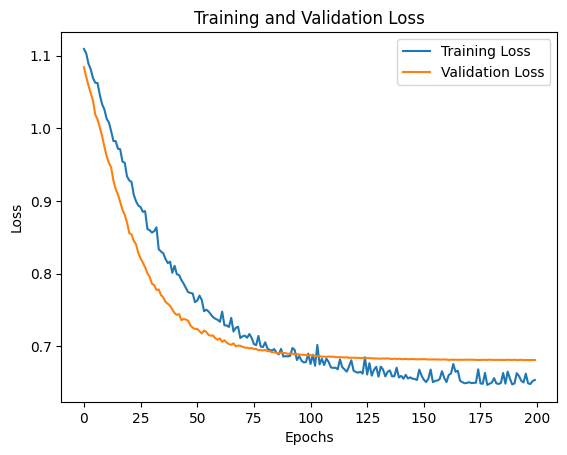

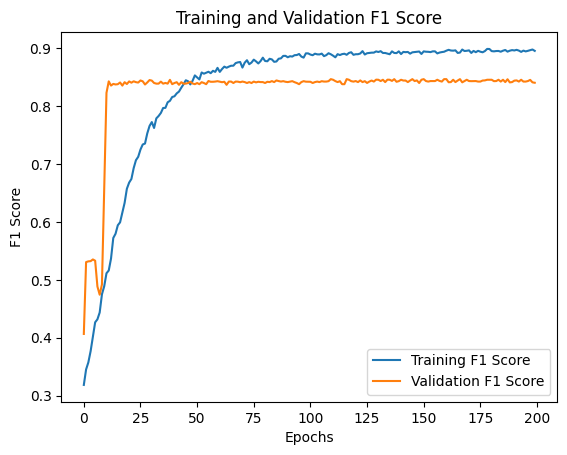

In [ ]:
# Initialize MetaClassifier and move to device
CNN_1D = CNN_1d().to(device)

# HP definition
num_epochs = 200
batch_size = 256
lr = 1e-5
weight_decay = 1e-3
model_path = "CNN.pth"

# Training loop
train_metaclassifier(CNN_1D, batch_size, num_epochs, lr, weight_decay, train_dataset, val_dataset, model_path)

A bit of overfitting can be seen by means of the two plots above. The model's generalization capabilities seems to find a plateau pretty early in the training loop, but this is probably due to the simplicity of the input tensor.

In [ ]:
CNN_model = CNN_1d()
CNN_model.load_state_dict(torch.load(model_path))
CNN_model = CNN_model.to(device)

evaluate_metaclassifier(CNN_model, test_dataset)


Test Loss: 0.6470688382784525
Test Macro F1 Score: 0.8899487798369782
Test Weighted F1 Score: [0.90585242 0.91527094 0.84872299]
Test Accuracy: 0.9031737493275955


As you can see above we have surpassed the state of the art results for the SciCite benchmark dataset. Now, the final model is the best performing overall for the Citation intent classification task.

### <b>Conclusions</b>

We have been able to outperform a bit the SOTA model for the Citation Intent Classification task. This is, yet per-se, a really good result, building a base block for possible further analysis involving more than one type of PLM for base predictions.
Additionally, could be also interesting to integrate base predictions in PLM's Prompt, or integreting vector representation of the sentence inside the final meta-classifier. Finally, the ensemble technique could be re-arranged to perfect training of base models with respect to the final outcome of the meta classifier.

With this, we may consider the project concluded.

Thank you for your attention.